In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import data, exposure
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


from time import time
from matplotlib import offsetbox
from sklearn import manifold

## Loading data

In [2]:
# data-loading
images = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/images.npy')
labels = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/labels.npy')

## Creating binary images by applying adaptive thresholding

In [3]:
#binary images
from skimage.filters import threshold_local
thresh_images = np.zeros(images.shape, dtype='uint')


for i in range(len(thresh_images)):
    
    threshed = np.zeros((28, 28), dtype='uint')
    im = images[i, :, :]
    
    
    threshed[im<80] = 1
    threshed[im>80] = 0
    
    thresh_images[i, :, :] = threshed
    
     

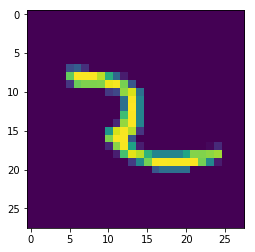

In [4]:
plt.imshow(images[558, :, :])

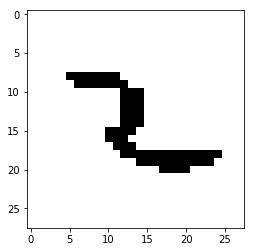

In [5]:
plt.imshow(thresh_images[558,:,:], cmap='gray')

## Creating HOG feature vector for dimentionality reduction

In [6]:
hog_results = np.zeros((392, 60000), dtype='float64')

for i in range(60000):
    hog_results[:, i] = hog(thresh_images[i, :, :], orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=True, multichannel=False)


/home/andrii/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


## To visualize our high-dimentional HOG matrix, lets use t-distributed Stochastic Neighbor Embedding

In [ ]:
X = np.transpose(hog_results)
y = labels
n_samples, n_features = X.shape
n_neighbors = 30

In [ ]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(hog_results[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity=50,early_exaggeration = 4.0, n_iter = 250, init='pca', random_state=0)

X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)

plt.show()
np.save('./X_tsne.npy',X_tsne)

## PCA 

In [ ]:
#apply PCA to reduce dimentionality 
X = np.transpose(hog_results)
y = labels

pca = PCA(n_components = 16, svd_solver='full')
a = pca.fit_transform(X)


## Next step is to implement SGD classifier

In [7]:
#split dataset into training and test sets

X = np.transpose(hog_results)
y = labels
X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]

In [12]:
sgd_clf = SGDClassifier(random_state=55, validation_fraction=0.2, verbose = 1, max_iter=100, n_jobs=12, shuffle=True)
sgd_clf.fit(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1-- Epoch 1

-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1


-- Epoch 1
Norm: 20.92, NNZs: 184, Bias: -27.679620, T: 50000, Avg. loss: 0.264960Norm: 13.98, NNZs: 182, Bias: -12.823330, T: 50000, Avg. loss: 0.072529
Total training time: 0.04 seconds.
-- Epoch 2

Total training time: 0.04 seconds.
-- Epoch 2
Norm: 16.97, NNZs: 190, Bias: -3.546453, T: 50000, Avg. loss: 0.119194
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 20.40, NNZs: 187, Bias: -17.903144, T: 50000, Avg. loss: 0.227986Norm: 18.11, NNZs: 186, Bias: -11.685094, T: 50000, Avg. loss: 0.161000Norm: 17.69, NNZs: 186, Bias: -14.252429, T: 50000, Avg. loss: 0.116365Norm: 13.08, NNZs: 177, Bias: 0.403798, T: 50000, Avg. loss: 0.064404
Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 2
-- Epoch 2

Total training time: 0.05 seconds.

Total training time: 0.05 seconds.
-- Epoch 2
-- Epoch 2
Norm: 20.45, NNZs: 183, Bias: -26.022970, T: 50000, Avg. loss: 0.09

Norm: 10.73, NNZs: 187, Bias: -10.230301, T: 500000, Avg. loss: 0.047799
Total training time: 0.40 seconds.
-- Epoch 11
Norm: 7.51, NNZs: 183, Bias: -5.632504, T: 550000, Avg. loss: 0.015059Norm: 10.20, NNZs: 187, Bias: -12.489842, T: 550000, Avg. loss: 0.057137
Total training time: 0.41 seconds.
-- Epoch 12

Total training time: 0.41 seconds.
-- Epoch 12
Norm: 8.78, NNZs: 184, Bias: -3.314981, T: 500000, Avg. loss: 0.034765
Total training time: 0.42 seconds.
-- Epoch 11
Norm: 7.91, NNZs: 188, Bias: 1.946635, T: 550000, Avg. loss: 0.014189Norm: 10.40, NNZs: 187, Bias: -12.522627, T: 550000, Avg. loss: 0.015556Norm: 8.86, NNZs: 190, Bias: -2.651537, T: 550000, Avg. loss: 0.032389Norm: 9.57, NNZs: 188, Bias: -7.281994, T: 550000, Avg. loss: 0.027314
Total training time: 0.42 seconds.

Total training time: 0.43 seconds.
-- Epoch 12

Total training time: 0.42 seconds.

Total training time: 0.42 seconds.
-- Epoch 12
-- Epoch 12
-- Epoch 12
Norm: 9.84, NNZs: 188, Bias: -7.324055, T: 550000, 

Norm: 7.71, NNZs: 188, Bias: 2.024292, T: 1050000, Avg. loss: 0.013682
Total training time: 0.82 seconds.
-- Epoch 22
Norm: 8.37, NNZs: 190, Bias: -2.006919, T: 1050000, Avg. loss: 0.031030
Total training time: 0.82 seconds.
-- Epoch 22
Norm: 9.32, NNZs: 187, Bias: -10.103518, T: 1050000, Avg. loss: 0.014551
Total training time: 0.82 seconds.
-- Epoch 22
Norm: 10.01, NNZs: 187, Bias: -8.628776, T: 1000000, Avg. loss: 0.046050
Total training time: 0.82 seconds.
-- Epoch 21
Norm: 9.07, NNZs: 188, Bias: -6.386144, T: 1050000, Avg. loss: 0.026367
Total training time: 0.83 seconds.
-- Epoch 22
Norm: 9.09, NNZs: 187, Bias: -10.198623, T: 1100000, Avg. loss: 0.054867Norm: 7.02, NNZs: 183, Bias: -4.558169, T: 1100000, Avg. loss: 0.014282
Total training time: 0.84 seconds.

Total training time: 0.84 seconds.
-- Epoch 23
-- Epoch 23
Norm: 8.35, NNZs: 184, Bias: -2.564154, T: 1000000, Avg. loss: 0.033190
Total training time: 0.84 seconds.
-- Epoch 21
Norm: 9.19, NNZs: 189, Bias: -5.950966, T: 105

Norm: 8.85, NNZs: 189, Bias: -5.547437, T: 1500000, Avg. loss: 0.040921
Total training time: 1.23 seconds.
-- Epoch 31
Norm: 8.20, NNZs: 184, Bias: -2.306896, T: 1450000, Avg. loss: 0.032644
Total training time: 1.23 seconds.
-- Epoch 30
Norm: 6.88, NNZs: 183, Bias: -4.145297, T: 1600000, Avg. loss: 0.014172
Total training time: 1.24 seconds.
-- Epoch 33
Norm: 7.64, NNZs: 188, Bias: 2.088870, T: 1550000, Avg. loss: 0.013540
Total training time: 1.24 seconds.
-- Epoch 32
Norm: 8.23, NNZs: 190, Bias: -1.770442, T: 1550000, Avg. loss: 0.030540
Total training time: 1.24 seconds.
-- Epoch 32
Norm: 8.92, NNZs: 187, Bias: -8.875697, T: 1550000, Avg. loss: 0.014083
Total training time: 1.24 seconds.
-- Epoch 32
Norm: 8.70, NNZs: 187, Bias: -9.378790, T: 1600000, Avg. loss: 0.054023
Total training time: 1.25 seconds.
-- Epoch 33
Norm: 8.47, NNZs: 190, Bias: -0.030341, T: 1500000, Avg. loss: 0.023988
Total training time: 1.25 seconds.
-- Epoch 31
Norm: 9.75, NNZs: 187, Bias: -7.972211, T: 150000

Norm: 8.56, NNZs: 187, Bias: -8.909344, T: 2050000, Avg. loss: 0.053783
Total training time: 1.64 seconds.
-- Epoch 42
Norm: 9.61, NNZs: 187, Bias: -7.648878, T: 1950000, Avg. loss: 0.044975
Total training time: 1.64 seconds.
-- Epoch 40
Norm: 6.77, NNZs: 184, Bias: -3.920556, T: 2100000, Avg. loss: 0.014091
Total training time: 1.66 seconds.
-- Epoch 43
Norm: 7.61, NNZs: 188, Bias: 2.167400, T: 2050000, Avg. loss: 0.013373Norm: 8.69, NNZs: 187, Bias: -8.114756, T: 2050000, Avg. loss: 0.013947
Total training time: 1.66 seconds.
-- Epoch 42

Total training time: 1.66 seconds.
-- Epoch 42
Norm: 8.16, NNZs: 190, Bias: -1.708852, T: 2050000, Avg. loss: 0.030373
Total training time: 1.67 seconds.
-- Epoch 42
Norm: 8.75, NNZs: 189, Bias: -5.204715, T: 2050000, Avg. loss: 0.040581Norm: 8.75, NNZs: 188, Bias: -5.759475, T: 2050000, Avg. loss: 0.025862
Total training time: 1.67 seconds.

Total training time: 1.68 seconds.
-- Epoch 42
-- Epoch 42
Norm: 8.41, NNZs: 190, Bias: 0.019483, T: 2000000

Norm: 8.39, NNZs: 190, Bias: 0.025871, T: 2450000, Avg. loss: 0.023663
Total training time: 2.06 seconds.
-- Epoch 50
Norm: 9.56, NNZs: 187, Bias: -7.415855, T: 2450000, Avg. loss: 0.044613
Total training time: 2.06 seconds.
-- Epoch 50
Norm: 8.39, NNZs: 187, Bias: -8.652906, T: 2550000, Avg. loss: 0.053488
Total training time: 2.06 seconds.
-- Epoch 52
Norm: 6.72, NNZs: 184, Bias: -3.747397, T: 2600000, Avg. loss: 0.014031
Total training time: 2.06 seconds.
-- Epoch 53
Norm: 7.58, NNZs: 188, Bias: 2.214898, T: 2550000, Avg. loss: 0.013352Norm: 8.67, NNZs: 189, Bias: -5.052450, T: 2550000, Avg. loss: 0.040290Norm: 8.12, NNZs: 190, Bias: -1.663225, T: 2550000, Avg. loss: 0.030233
Total training time: 2.06 seconds.

Total training time: 2.06 seconds.
-- Epoch 52
-- Epoch 52

Total training time: 2.06 seconds.
-- Epoch 52
Norm: 8.52, NNZs: 187, Bias: -7.621731, T: 2550000, Avg. loss: 0.013776
Total training time: 2.06 seconds.
-- Epoch 52
Norm: 8.10, NNZs: 184, Bias: -1.997019, T: 2400000

Norm: 6.71, NNZs: 184, Bias: -3.632752, T: 3100000, Avg. loss: 0.014012
Total training time: 2.47 seconds.
-- Epoch 63
Norm: 8.45, NNZs: 187, Bias: -7.228443, T: 3050000, Avg. loss: 0.013706
Total training time: 2.47 seconds.
-- Epoch 62
Norm: 9.47, NNZs: 187, Bias: -7.253508, T: 2950000, Avg. loss: 0.044603Norm: 8.35, NNZs: 190, Bias: 0.042087, T: 2950000, Avg. loss: 0.023471

Total training time: 2.47 seconds.
Total training time: 2.47 seconds.
-- Epoch 60
-- Epoch 60
Norm: 8.35, NNZs: 187, Bias: -8.401222, T: 3050000, Avg. loss: 0.053398
Total training time: 2.48 seconds.
-- Epoch 62
Norm: 8.61, NNZs: 189, Bias: -4.927227, T: 3100000, Avg. loss: 0.040253Norm: 7.56, NNZs: 188, Bias: 2.195712, T: 3100000, Avg. loss: 0.013332
Total training time: 2.49 seconds.
-- Epoch 63

Total training time: 2.49 seconds.
-- Epoch 63
Norm: 8.11, NNZs: 190, Bias: -1.581514, T: 3100000, Avg. loss: 0.030142
Total training time: 2.49 seconds.
-- Epoch 63
Norm: 8.04, NNZs: 184, Bias: -1.943030, T: 2900000

Norm: 8.10, NNZs: 190, Bias: -1.566045, T: 3550000, Avg. loss: 0.030020
Total training time: 2.87 seconds.
-- Epoch 72
Norm: 8.64, NNZs: 188, Bias: -5.410565, T: 3500000, Avg. loss: 0.025703
Total training time: 2.88 seconds.
-- Epoch 71
Norm: 6.69, NNZs: 184, Bias: -3.542377, T: 3600000, Avg. loss: 0.013950
Total training time: 2.88 seconds.
-- Epoch 73
Norm: 8.58, NNZs: 189, Bias: -4.852849, T: 3600000, Avg. loss: 0.040164Norm: 7.55, NNZs: 188, Bias: 2.237763, T: 3600000, Avg. loss: 0.013281
Total training time: 2.88 seconds.

Total training time: 2.88 seconds.
-- Epoch 73
-- Epoch 73
Norm: 8.35, NNZs: 187, Bias: -6.940620, T: 3550000, Avg. loss: 0.013630
Total training time: 2.88 seconds.
-- Epoch 72
Norm: 8.03, NNZs: 184, Bias: -1.931711, T: 3350000, Avg. loss: 0.032217
Total training time: 2.89 seconds.
-- Epoch 68
Norm: 9.45, NNZs: 187, Bias: -7.107352, T: 3450000, Avg. loss: 0.044535Norm: 8.34, NNZs: 190, Bias: 0.028386, T: 3450000, Avg. loss: 0.023514
Total training time: 2.89 

Norm: 8.32, NNZs: 190, Bias: 0.043831, T: 3900000, Avg. loss: 0.023458Norm: 9.43, NNZs: 187, Bias: -7.015843, T: 3900000, Avg. loss: 0.044443
Total training time: 3.28 seconds.

Total training time: 3.28 seconds.
-- Epoch 79
-- Epoch 79
Norm: 7.55, NNZs: 188, Bias: 2.254229, T: 4100000, Avg. loss: 0.013274
Total training time: 3.29 seconds.
-- Epoch 83
Norm: 8.01, NNZs: 184, Bias: -1.892891, T: 3800000, Avg. loss: 0.032138
Total training time: 3.29 seconds.
-- Epoch 77
Norm: 8.54, NNZs: 189, Bias: -4.785338, T: 4100000, Avg. loss: 0.040056
Total training time: 3.29 seconds.
-- Epoch 83
Norm: 8.24, NNZs: 187, Bias: -8.133768, T: 4000000, Avg. loss: 0.053237
Total training time: 3.29 seconds.
-- Epoch 81
Norm: 6.67, NNZs: 184, Bias: -3.463175, T: 4100000, Avg. loss: 0.013915
Total training time: 3.30 seconds.
-- Epoch 83
Norm: 8.08, NNZs: 190, Bias: -1.534450, T: 4050000, Avg. loss: 0.030002
Total training time: 3.30 seconds.
-- Epoch 82
Norm: 8.61, NNZs: 188, Bias: -5.348821, T: 4000000

Norm: 8.31, NNZs: 190, Bias: 0.038797, T: 4400000, Avg. loss: 0.023403Norm: 9.41, NNZs: 187, Bias: -6.904406, T: 4400000, Avg. loss: 0.044427
Total training time: 3.71 seconds.

Total training time: 3.71 seconds.
-- Epoch 89
-- Epoch 89
Norm: 6.66, NNZs: 184, Bias: -3.393627, T: 4600000, Avg. loss: 0.013876
Total training time: 3.71 seconds.
-- Epoch 93
Norm: 7.55, NNZs: 188, Bias: 2.241568, T: 4600000, Avg. loss: 0.013194
Total training time: 3.71 seconds.
-- Epoch 93
Norm: 8.53, NNZs: 189, Bias: -4.739351, T: 4600000, Avg. loss: 0.040055
Total training time: 3.72 seconds.
-- Epoch 93
Norm: 8.21, NNZs: 187, Bias: -8.035835, T: 4500000, Avg. loss: 0.053108
Total training time: 3.72 seconds.
-- Epoch 91
Norm: 8.06, NNZs: 190, Bias: -1.534860, T: 4550000, Avg. loss: 0.029860Norm: 8.24, NNZs: 187, Bias: -6.497787, T: 4550000, Avg. loss: 0.013544
Total training time: 3.73 seconds.

Total training time: 3.73 seconds.
-- Epoch 92
-- Epoch 92
Norm: 8.00, NNZs: 184, Bias: -1.863623, T: 4300000

Norm: 8.05, NNZs: 190, Bias: -1.527667, T: 5000000, Avg. loss: 0.029915
Total training time: 4.11 seconds.
Norm: 8.58, NNZs: 188, Bias: -5.249802, T: 4950000, Avg. loss: 0.025553
Total training time: 4.13 seconds.
-- Epoch 100
Norm: 8.01, NNZs: 184, Bias: -1.804049, T: 4750000, Avg. loss: 0.031885
Total training time: 4.12 seconds.
-- Epoch 96
Norm: 8.30, NNZs: 190, Bias: 0.082389, T: 4900000, Avg. loss: 0.023358Norm: 9.37, NNZs: 187, Bias: -6.851945, T: 4900000, Avg. loss: 0.044376
Total training time: 4.13 seconds.

Total training time: 4.13 seconds.
-- Epoch 99
-- Epoch 99
Norm: 8.18, NNZs: 187, Bias: -7.971307, T: 5000000, Avg. loss: 0.053134
Total training time: 4.14 seconds.
Norm: 8.57, NNZs: 188, Bias: -5.257865, T: 5000000, Avg. loss: 0.025554
Total training time: 4.16 seconds.
Norm: 8.00, NNZs: 184, Bias: -1.846119, T: 4800000, Avg. loss: 0.032060
Total training time: 4.16 seconds.
-- Epoch 97
Norm: 9.38, NNZs: 187, Bias: -6.837532, T: 4950000, Avg. loss: 0.044397Norm: 8.30, N

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:    4.3s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=12, penalty='l2',
       power_t=0.5, random_state=55, shuffle=True, tol=None,
       validation_fraction=0.2, verbose=1, warm_start=False)

In [61]:
sgd_clf.predict(X_test)[6544]

9

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring='accuracy')

[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 19.85, NNZs: 189, Bias: -25.150479, T: 44995, Avg. loss: 0.104937
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.62, NNZs: 190, Bias: -21.061156, T: 89990, Avg. loss: 0.026137
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 14.16, NNZs: 191, Bias: -18.586237, T: 134985, Avg. loss: 0.021831
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.83, NNZs: 191, Bias: -17.171646, T: 179980, Avg. loss: 0.019533
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.37, NNZs: 191, Bias: -15.899979, T: 224975, Avg. loss: 0.018316
Total training time: 0.13 seconds.
-- Epoch 6
Norm: 11.71, NNZs: 191, Bias: -15.167459, T: 269970, Avg. loss: 0.017166
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 11.45, NNZs: 191, Bias: -14.276106, T: 314965, Avg. loss: 0.016978
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 11.02, NNZs: 191, Bias: -13.746416, T: 359960, Avg. loss: 0.016732
Total training time: 0.21 seconds.
-- Epoch 9
Norm: 10.77, NNZs: 191, Bias: -13.19600

Norm: 8.37, NNZs: 191, Bias: -6.878117, T: 3464615, Avg. loss: 0.013654
Total training time: 2.20 seconds.
-- Epoch 78
Norm: 8.37, NNZs: 191, Bias: -6.846779, T: 3509610, Avg. loss: 0.013657
Total training time: 2.23 seconds.
-- Epoch 79
Norm: 8.35, NNZs: 191, Bias: -6.849691, T: 3554605, Avg. loss: 0.013643
Total training time: 2.26 seconds.
-- Epoch 80
Norm: 8.36, NNZs: 191, Bias: -6.810595, T: 3599600, Avg. loss: 0.013667
Total training time: 2.29 seconds.
-- Epoch 81
Norm: 8.35, NNZs: 191, Bias: -6.796919, T: 3644595, Avg. loss: 0.013654
Total training time: 2.31 seconds.
-- Epoch 82
Norm: 8.32, NNZs: 191, Bias: -6.796808, T: 3689590, Avg. loss: 0.013621
Total training time: 2.34 seconds.
-- Epoch 83
Norm: 8.34, NNZs: 191, Bias: -6.759004, T: 3734585, Avg. loss: 0.013643
Total training time: 2.37 seconds.
-- Epoch 84
Norm: 8.34, NNZs: 191, Bias: -6.724469, T: 3779580, Avg. loss: 0.013646
Total training time: 2.40 seconds.
-- Epoch 85
Norm: 8.34, NNZs: 191, Bias: -6.706205, T: 38245

Norm: 7.73, NNZs: 187, Bias: 2.275944, T: 2159760, Avg. loss: 0.012937
Total training time: 1.35 seconds.
-- Epoch 49
Norm: 7.73, NNZs: 187, Bias: 2.317275, T: 2204755, Avg. loss: 0.012918
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 7.72, NNZs: 187, Bias: 2.317078, T: 2249750, Avg. loss: 0.012936
Total training time: 1.40 seconds.
-- Epoch 51
Norm: 7.72, NNZs: 187, Bias: 2.325547, T: 2294745, Avg. loss: 0.012886
Total training time: 1.43 seconds.
-- Epoch 52
Norm: 7.72, NNZs: 187, Bias: 2.295367, T: 2339740, Avg. loss: 0.012872
Total training time: 1.46 seconds.
-- Epoch 53
Norm: 7.71, NNZs: 187, Bias: 2.312509, T: 2384735, Avg. loss: 0.012865
Total training time: 1.48 seconds.
-- Epoch 54
Norm: 7.72, NNZs: 187, Bias: 2.304430, T: 2429730, Avg. loss: 0.012855
Total training time: 1.51 seconds.
-- Epoch 55
Norm: 7.72, NNZs: 187, Bias: 2.296581, T: 2474725, Avg. loss: 0.012844
Total training time: 1.54 seconds.
-- Epoch 56
Norm: 7.72, NNZs: 187, Bias: 2.304866, T: 2519720, Avg. 

Norm: 8.47, NNZs: 191, Bias: -2.144969, T: 899900, Avg. loss: 0.030596
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.42, NNZs: 191, Bias: -2.079020, T: 944895, Avg. loss: 0.030749
Total training time: 0.59 seconds.
-- Epoch 22
Norm: 8.41, NNZs: 191, Bias: -2.058260, T: 989890, Avg. loss: 0.030817
Total training time: 0.61 seconds.
-- Epoch 23
Norm: 8.39, NNZs: 191, Bias: -2.027697, T: 1034885, Avg. loss: 0.030824
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 8.38, NNZs: 191, Bias: -1.961877, T: 1079880, Avg. loss: 0.030529
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 8.37, NNZs: 191, Bias: -1.926788, T: 1124875, Avg. loss: 0.030591
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 8.35, NNZs: 191, Bias: -1.969208, T: 1169870, Avg. loss: 0.030493
Total training time: 0.73 seconds.
-- Epoch 27
Norm: 8.33, NNZs: 191, Bias: -1.876331, T: 1214865, Avg. loss: 0.030468
Total training time: 0.75 seconds.
-- Epoch 28
Norm: 8.30, NNZs: 191, Bias: -1.876257, T: 1259860,

Norm: 8.11, NNZs: 191, Bias: -1.500690, T: 4094545, Avg. loss: 0.029573
Total training time: 2.56 seconds.
-- Epoch 92
Norm: 8.11, NNZs: 191, Bias: -1.469215, T: 4139540, Avg. loss: 0.029596
Total training time: 2.59 seconds.
-- Epoch 93
Norm: 8.11, NNZs: 191, Bias: -1.500374, T: 4184535, Avg. loss: 0.029506
Total training time: 2.62 seconds.
-- Epoch 94
Norm: 8.11, NNZs: 191, Bias: -1.464761, T: 4229530, Avg. loss: 0.029551
Total training time: 2.65 seconds.
-- Epoch 95
Norm: 8.11, NNZs: 191, Bias: -1.483642, T: 4274525, Avg. loss: 0.029518
Total training time: 2.69 seconds.
-- Epoch 96
Norm: 8.11, NNZs: 191, Bias: -1.465055, T: 4319520, Avg. loss: 0.029542
Total training time: 2.71 seconds.
-- Epoch 97
Norm: 8.11, NNZs: 191, Bias: -1.478969, T: 4364515, Avg. loss: 0.029533
Total training time: 2.74 seconds.
-- Epoch 98
Norm: 8.11, NNZs: 191, Bias: -1.487965, T: 4409510, Avg. loss: 0.029513
Total training time: 2.77 seconds.
-- Epoch 99
Norm: 8.11, NNZs: 191, Bias: -1.463174, T: 44545

Norm: 8.62, NNZs: 188, Bias: -4.750993, T: 2744695, Avg. loss: 0.040238
Total training time: 1.72 seconds.
-- Epoch 62
Norm: 8.62, NNZs: 188, Bias: -4.736697, T: 2789690, Avg. loss: 0.040325
Total training time: 1.74 seconds.
-- Epoch 63
Norm: 8.60, NNZs: 188, Bias: -4.743822, T: 2834685, Avg. loss: 0.040333
Total training time: 1.77 seconds.
-- Epoch 64
Norm: 8.61, NNZs: 188, Bias: -4.719400, T: 2879680, Avg. loss: 0.040311
Total training time: 1.80 seconds.
-- Epoch 65
Norm: 8.58, NNZs: 188, Bias: -4.760409, T: 2924675, Avg. loss: 0.040283
Total training time: 1.83 seconds.
-- Epoch 66
Norm: 8.59, NNZs: 188, Bias: -4.715969, T: 2969670, Avg. loss: 0.040305
Total training time: 1.86 seconds.
-- Epoch 67
Norm: 8.60, NNZs: 188, Bias: -4.709101, T: 3014665, Avg. loss: 0.040227
Total training time: 1.89 seconds.
-- Epoch 68
Norm: 8.60, NNZs: 188, Bias: -4.692708, T: 3059660, Avg. loss: 0.040218
Total training time: 1.91 seconds.
-- Epoch 69
Norm: 8.57, NNZs: 188, Bias: -4.718488, T: 31046

Norm: 8.97, NNZs: 188, Bias: -6.498248, T: 1484835, Avg. loss: 0.026186
Total training time: 0.92 seconds.
-- Epoch 34
Norm: 8.99, NNZs: 188, Bias: -6.425245, T: 1529830, Avg. loss: 0.026229
Total training time: 0.95 seconds.
-- Epoch 35
Norm: 8.98, NNZs: 188, Bias: -6.399811, T: 1574825, Avg. loss: 0.026086
Total training time: 0.98 seconds.
-- Epoch 36
Norm: 8.98, NNZs: 188, Bias: -6.331520, T: 1619820, Avg. loss: 0.025913
Total training time: 1.00 seconds.
-- Epoch 37
Norm: 8.97, NNZs: 188, Bias: -6.307973, T: 1664815, Avg. loss: 0.026027
Total training time: 1.03 seconds.
-- Epoch 38
Norm: 8.94, NNZs: 188, Bias: -6.308108, T: 1709810, Avg. loss: 0.026093
Total training time: 1.06 seconds.
-- Epoch 39
Norm: 8.92, NNZs: 188, Bias: -6.273291, T: 1754805, Avg. loss: 0.026009
Total training time: 1.09 seconds.
-- Epoch 40
Norm: 8.92, NNZs: 188, Bias: -6.228424, T: 1799800, Avg. loss: 0.026031
Total training time: 1.12 seconds.
-- Epoch 41
Norm: 8.91, NNZs: 188, Bias: -6.206803, T: 18447

Norm: 10.27, NNZs: 189, Bias: -1.366878, T: 224975, Avg. loss: 0.028685
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.88, NNZs: 189, Bias: -1.039005, T: 269970, Avg. loss: 0.027739
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 9.63, NNZs: 189, Bias: -0.799540, T: 314965, Avg. loss: 0.026915
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 9.43, NNZs: 189, Bias: -0.710460, T: 359960, Avg. loss: 0.026506
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 9.32, NNZs: 189, Bias: -0.577884, T: 404955, Avg. loss: 0.026077
Total training time: 0.25 seconds.
-- Epoch 10
Norm: 9.14, NNZs: 189, Bias: -0.461594, T: 449950, Avg. loss: 0.025604
Total training time: 0.28 seconds.
-- Epoch 11
Norm: 9.11, NNZs: 189, Bias: -0.359498, T: 494945, Avg. loss: 0.025533
Total training time: 0.30 seconds.
-- Epoch 12
Norm: 8.94, NNZs: 189, Bias: -0.321752, T: 539940, Avg. loss: 0.025223
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 8.86, NNZs: 189, Bias: -0.321663, T: 584935, Avg. los

Norm: 8.34, NNZs: 189, Bias: 0.140199, T: 3419620, Avg. loss: 0.023639
Total training time: 2.14 seconds.
-- Epoch 77
Norm: 8.34, NNZs: 189, Bias: 0.140380, T: 3464615, Avg. loss: 0.023615
Total training time: 2.17 seconds.
-- Epoch 78
Norm: 8.34, NNZs: 189, Bias: 0.163253, T: 3509610, Avg. loss: 0.023658
Total training time: 2.20 seconds.
-- Epoch 79
Norm: 8.34, NNZs: 189, Bias: 0.154682, T: 3554605, Avg. loss: 0.023610
Total training time: 2.23 seconds.
-- Epoch 80
Norm: 8.33, NNZs: 189, Bias: 0.143579, T: 3599600, Avg. loss: 0.023642
Total training time: 2.25 seconds.
-- Epoch 81
Norm: 8.33, NNZs: 189, Bias: 0.162875, T: 3644595, Avg. loss: 0.023597
Total training time: 2.28 seconds.
-- Epoch 82
Norm: 8.33, NNZs: 189, Bias: 0.130304, T: 3689590, Avg. loss: 0.023595
Total training time: 2.31 seconds.
-- Epoch 83
Norm: 8.33, NNZs: 189, Bias: 0.133359, T: 3734585, Avg. loss: 0.023560
Total training time: 2.34 seconds.
-- Epoch 84
Norm: 8.33, NNZs: 189, Bias: 0.162616, T: 3779580, Avg. 

Norm: 6.83, NNZs: 183, Bias: -4.147195, T: 2159760, Avg. loss: 0.014143
Total training time: 1.33 seconds.
-- Epoch 49
Norm: 6.83, NNZs: 183, Bias: -4.110487, T: 2204755, Avg. loss: 0.014136
Total training time: 1.36 seconds.
-- Epoch 50
Norm: 6.82, NNZs: 183, Bias: -4.097109, T: 2249750, Avg. loss: 0.014231
Total training time: 1.38 seconds.
-- Epoch 51
Norm: 6.81, NNZs: 183, Bias: -4.079576, T: 2294745, Avg. loss: 0.014119
Total training time: 1.42 seconds.
-- Epoch 52
Norm: 6.82, NNZs: 183, Bias: -4.028179, T: 2339740, Avg. loss: 0.014172
Total training time: 1.45 seconds.
-- Epoch 53
Norm: 6.81, NNZs: 183, Bias: -4.028454, T: 2384735, Avg. loss: 0.014135
Total training time: 1.48 seconds.
-- Epoch 54
Norm: 6.80, NNZs: 183, Bias: -4.008006, T: 2429730, Avg. loss: 0.014185
Total training time: 1.51 seconds.
-- Epoch 55
Norm: 6.78, NNZs: 183, Bias: -4.024335, T: 2474725, Avg. loss: 0.014099
Total training time: 1.53 seconds.
-- Epoch 56
Norm: 6.78, NNZs: 183, Bias: -3.996282, T: 25197

Norm: 8.42, NNZs: 183, Bias: -2.802223, T: 809910, Avg. loss: 0.033607
Total training time: 0.52 seconds.
-- Epoch 19
Norm: 8.41, NNZs: 183, Bias: -2.720737, T: 854905, Avg. loss: 0.033510
Total training time: 0.55 seconds.
-- Epoch 20
Norm: 8.36, NNZs: 183, Bias: -2.755026, T: 899900, Avg. loss: 0.033439
Total training time: 0.58 seconds.
-- Epoch 21
Norm: 8.32, NNZs: 183, Bias: -2.698718, T: 944895, Avg. loss: 0.033018
Total training time: 0.60 seconds.
-- Epoch 22
Norm: 8.31, NNZs: 183, Bias: -2.626912, T: 989890, Avg. loss: 0.033265
Total training time: 0.63 seconds.
-- Epoch 23
Norm: 8.26, NNZs: 183, Bias: -2.637104, T: 1034885, Avg. loss: 0.033039
Total training time: 0.66 seconds.
-- Epoch 24
Norm: 8.29, NNZs: 183, Bias: -2.570476, T: 1079880, Avg. loss: 0.033110
Total training time: 0.69 seconds.
-- Epoch 25
Norm: 8.27, NNZs: 183, Bias: -2.517506, T: 1124875, Avg. loss: 0.033159
Total training time: 0.72 seconds.
-- Epoch 26
Norm: 8.23, NNZs: 183, Bias: -2.542713, T: 1169870, A

Norm: 8.00, NNZs: 183, Bias: -2.068816, T: 4049550, Avg. loss: 0.032208
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 7.99, NNZs: 183, Bias: -2.059000, T: 4094545, Avg. loss: 0.032198
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 7.99, NNZs: 183, Bias: -2.063775, T: 4139540, Avg. loss: 0.032133
Total training time: 2.60 seconds.
-- Epoch 93
Norm: 7.98, NNZs: 183, Bias: -2.085168, T: 4184535, Avg. loss: 0.032044
Total training time: 2.62 seconds.
-- Epoch 94
Norm: 7.98, NNZs: 183, Bias: -2.061174, T: 4229530, Avg. loss: 0.032235
Total training time: 2.65 seconds.
-- Epoch 95
Norm: 7.99, NNZs: 183, Bias: -2.054043, T: 4274525, Avg. loss: 0.032128
Total training time: 2.68 seconds.
-- Epoch 96
Norm: 7.99, NNZs: 183, Bias: -2.067956, T: 4319520, Avg. loss: 0.032145
Total training time: 2.71 seconds.
-- Epoch 97
Norm: 7.99, NNZs: 183, Bias: -2.044882, T: 4364515, Avg. loss: 0.032162
Total training time: 2.74 seconds.
-- Epoch 98
Norm: 8.00, NNZs: 183, Bias: -2.033646, T: 44095

Norm: 8.38, NNZs: 187, Bias: -8.407139, T: 2789690, Avg. loss: 0.054552
Total training time: 1.75 seconds.
-- Epoch 63
Norm: 8.41, NNZs: 187, Bias: -8.354262, T: 2834685, Avg. loss: 0.054616
Total training time: 1.78 seconds.
-- Epoch 64
Norm: 8.37, NNZs: 187, Bias: -8.375569, T: 2879680, Avg. loss: 0.054778
Total training time: 1.81 seconds.
-- Epoch 65
Norm: 8.38, NNZs: 187, Bias: -8.351616, T: 2924675, Avg. loss: 0.054648
Total training time: 1.84 seconds.
-- Epoch 66
Norm: 8.34, NNZs: 187, Bias: -8.371929, T: 2969670, Avg. loss: 0.054472
Total training time: 1.87 seconds.
-- Epoch 67
Norm: 8.35, NNZs: 187, Bias: -8.338331, T: 3014665, Avg. loss: 0.054519
Total training time: 1.90 seconds.
-- Epoch 68
Norm: 8.35, NNZs: 187, Bias: -8.315328, T: 3059660, Avg. loss: 0.054467
Total training time: 1.92 seconds.
-- Epoch 69
Norm: 8.33, NNZs: 187, Bias: -8.315291, T: 3104655, Avg. loss: 0.054545
Total training time: 1.95 seconds.
-- Epoch 70
Norm: 8.34, NNZs: 187, Bias: -8.292926, T: 31496

Norm: 9.82, NNZs: 185, Bias: -8.441652, T: 1529830, Avg. loss: 0.045542
Total training time: 0.95 seconds.
-- Epoch 35
Norm: 9.85, NNZs: 185, Bias: -8.338785, T: 1574825, Avg. loss: 0.045403
Total training time: 0.98 seconds.
-- Epoch 36
Norm: 9.77, NNZs: 185, Bias: -8.351220, T: 1619820, Avg. loss: 0.045501
Total training time: 1.01 seconds.
-- Epoch 37
Norm: 9.76, NNZs: 185, Bias: -8.296041, T: 1664815, Avg. loss: 0.045483
Total training time: 1.04 seconds.
-- Epoch 38
Norm: 9.78, NNZs: 185, Bias: -8.219223, T: 1709810, Avg. loss: 0.045446
Total training time: 1.07 seconds.
-- Epoch 39
Norm: 9.73, NNZs: 185, Bias: -8.208034, T: 1754805, Avg. loss: 0.045395
Total training time: 1.09 seconds.
-- Epoch 40
Norm: 9.71, NNZs: 185, Bias: -8.168700, T: 1799800, Avg. loss: 0.045336
Total training time: 1.12 seconds.
-- Epoch 41
Norm: 9.75, NNZs: 185, Bias: -8.086983, T: 1844795, Avg. loss: 0.045122
Total training time: 1.15 seconds.
-- Epoch 42
Norm: 9.72, NNZs: 185, Bias: -8.092706, T: 18897

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.1s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 20.03, NNZs: 187, Bias: -25.550968, T: 44997, Avg. loss: 0.111898
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.86, NNZs: 188, Bias: -21.224593, T: 89994, Avg. loss: 0.026665
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 14.04, NNZs: 188, Bias: -18.990801, T: 134991, Avg. loss: 0.020993
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.90, NNZs: 188, Bias: -17.468156, T: 179988, Avg. loss: 0.019266
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.20, NNZs: 188, Bias: -16.236908, T: 224985, Avg. loss: 0.018589
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.71, NNZs: 188, Bias: -15.372272, T: 269982, Avg. loss: 0.017370
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 11.42, NNZs: 188, Bias: -14.516979, T: 314979, Avg. loss: 0.016628
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 11.07, NNZs: 188, Bias: -13.977932, T: 359976, Avg. loss: 0.016250
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 10.90, NNZs: 188, Bias: -13.34849

Norm: 8.44, NNZs: 188, Bias: -7.001981, T: 3149790, Avg. loss: 0.013410
Total training time: 1.97 seconds.
-- Epoch 71
Norm: 8.42, NNZs: 188, Bias: -6.995514, T: 3194787, Avg. loss: 0.013365
Total training time: 1.99 seconds.
-- Epoch 72
Norm: 8.43, NNZs: 188, Bias: -6.954936, T: 3239784, Avg. loss: 0.013431
Total training time: 2.02 seconds.
-- Epoch 73
Norm: 8.44, NNZs: 188, Bias: -6.902927, T: 3284781, Avg. loss: 0.013382
Total training time: 2.05 seconds.
-- Epoch 74
Norm: 8.41, NNZs: 188, Bias: -6.915073, T: 3329778, Avg. loss: 0.013404
Total training time: 2.08 seconds.
-- Epoch 75
Norm: 8.41, NNZs: 188, Bias: -6.876202, T: 3374775, Avg. loss: 0.013351
Total training time: 2.11 seconds.
-- Epoch 76
Norm: 8.40, NNZs: 188, Bias: -6.852708, T: 3419772, Avg. loss: 0.013379
Total training time: 2.13 seconds.
-- Epoch 77
Norm: 8.39, NNZs: 188, Bias: -6.832381, T: 3464769, Avg. loss: 0.013380
Total training time: 2.16 seconds.
-- Epoch 78
Norm: 8.40, NNZs: 188, Bias: -6.797937, T: 35097

Norm: 7.55, NNZs: 186, Bias: 2.001686, T: 1889874, Avg. loss: 0.013242
Total training time: 1.16 seconds.
-- Epoch 43
Norm: 7.57, NNZs: 186, Bias: 1.944484, T: 1934871, Avg. loss: 0.013266
Total training time: 1.19 seconds.
-- Epoch 44
Norm: 7.55, NNZs: 186, Bias: 2.015917, T: 1979868, Avg. loss: 0.013321
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 7.56, NNZs: 186, Bias: 2.000435, T: 2024865, Avg. loss: 0.013165
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 7.55, NNZs: 186, Bias: 2.005061, T: 2069862, Avg. loss: 0.013286
Total training time: 1.27 seconds.
-- Epoch 47
Norm: 7.55, NNZs: 186, Bias: 1.995344, T: 2114859, Avg. loss: 0.013197
Total training time: 1.30 seconds.
-- Epoch 48
Norm: 7.56, NNZs: 186, Bias: 1.971968, T: 2159856, Avg. loss: 0.013229
Total training time: 1.33 seconds.
-- Epoch 49
Norm: 7.56, NNZs: 186, Bias: 1.985931, T: 2204853, Avg. loss: 0.013186
Total training time: 1.36 seconds.
-- Epoch 50
Norm: 7.56, NNZs: 186, Bias: 1.963799, T: 2249850, Avg. 

Norm: 8.53, NNZs: 192, Bias: -2.249308, T: 854943, Avg. loss: 0.031149
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.50, NNZs: 192, Bias: -2.136370, T: 899940, Avg. loss: 0.031201
Total training time: 0.55 seconds.
-- Epoch 21
Norm: 8.48, NNZs: 192, Bias: -2.158791, T: 944937, Avg. loss: 0.030983
Total training time: 0.58 seconds.
-- Epoch 22
Norm: 8.45, NNZs: 192, Bias: -2.086881, T: 989934, Avg. loss: 0.031052
Total training time: 0.61 seconds.
-- Epoch 23
Norm: 8.43, NNZs: 192, Bias: -2.076723, T: 1034931, Avg. loss: 0.030895
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 8.42, NNZs: 192, Bias: -2.048165, T: 1079928, Avg. loss: 0.030933
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 8.38, NNZs: 192, Bias: -2.038610, T: 1124925, Avg. loss: 0.030928
Total training time: 0.69 seconds.
-- Epoch 26
Norm: 8.38, NNZs: 192, Bias: -1.977091, T: 1169922, Avg. loss: 0.030732
Total training time: 0.72 seconds.
-- Epoch 27
Norm: 8.36, NNZs: 192, Bias: -1.943963, T: 1214919, 

Norm: 8.15, NNZs: 192, Bias: -1.507083, T: 4049730, Avg. loss: 0.029760
Total training time: 2.52 seconds.
-- Epoch 91
Norm: 8.15, NNZs: 192, Bias: -1.536635, T: 4094727, Avg. loss: 0.029785
Total training time: 2.55 seconds.
-- Epoch 92
Norm: 8.15, NNZs: 192, Bias: -1.534110, T: 4139724, Avg. loss: 0.029809
Total training time: 2.57 seconds.
-- Epoch 93
Norm: 8.15, NNZs: 192, Bias: -1.510139, T: 4184721, Avg. loss: 0.029729
Total training time: 2.60 seconds.
-- Epoch 94
Norm: 8.15, NNZs: 192, Bias: -1.522124, T: 4229718, Avg. loss: 0.029789
Total training time: 2.63 seconds.
-- Epoch 95
Norm: 8.14, NNZs: 192, Bias: -1.529242, T: 4274715, Avg. loss: 0.029786
Total training time: 2.66 seconds.
-- Epoch 96
Norm: 8.15, NNZs: 192, Bias: -1.533845, T: 4319712, Avg. loss: 0.029762
Total training time: 2.68 seconds.
-- Epoch 97
Norm: 8.14, NNZs: 192, Bias: -1.531517, T: 4364709, Avg. loss: 0.029789
Total training time: 2.71 seconds.
-- Epoch 98
Norm: 8.15, NNZs: 192, Bias: -1.499708, T: 44097

Norm: 8.76, NNZs: 190, Bias: -5.012832, T: 2744817, Avg. loss: 0.039146
Total training time: 1.73 seconds.
-- Epoch 62
Norm: 8.76, NNZs: 190, Bias: -4.979934, T: 2789814, Avg. loss: 0.039300
Total training time: 1.77 seconds.
-- Epoch 63
Norm: 8.77, NNZs: 190, Bias: -4.955066, T: 2834811, Avg. loss: 0.039194
Total training time: 1.79 seconds.
-- Epoch 64
Norm: 8.77, NNZs: 190, Bias: -4.934240, T: 2879808, Avg. loss: 0.039229
Total training time: 1.82 seconds.
-- Epoch 65
Norm: 8.74, NNZs: 190, Bias: -4.968650, T: 2924805, Avg. loss: 0.039103
Total training time: 1.85 seconds.
-- Epoch 66
Norm: 8.75, NNZs: 190, Bias: -4.941364, T: 2969802, Avg. loss: 0.039259
Total training time: 1.88 seconds.
-- Epoch 67
Norm: 8.74, NNZs: 190, Bias: -4.957811, T: 3014799, Avg. loss: 0.039116
Total training time: 1.91 seconds.
-- Epoch 68
Norm: 8.73, NNZs: 190, Bias: -4.941019, T: 3059796, Avg. loss: 0.039178
Total training time: 1.93 seconds.
-- Epoch 69
Norm: 8.74, NNZs: 190, Bias: -4.914970, T: 31047

Norm: 9.04, NNZs: 187, Bias: -6.582218, T: 1349910, Avg. loss: 0.025832
Total training time: 0.85 seconds.
-- Epoch 31
Norm: 9.01, NNZs: 187, Bias: -6.553300, T: 1394907, Avg. loss: 0.025878
Total training time: 0.88 seconds.
-- Epoch 32
Norm: 8.98, NNZs: 187, Bias: -6.525032, T: 1439904, Avg. loss: 0.025741
Total training time: 0.91 seconds.
-- Epoch 33
Norm: 8.96, NNZs: 187, Bias: -6.483421, T: 1484901, Avg. loss: 0.025670
Total training time: 0.94 seconds.
-- Epoch 34
Norm: 8.98, NNZs: 187, Bias: -6.403905, T: 1529898, Avg. loss: 0.025748
Total training time: 0.97 seconds.
-- Epoch 35
Norm: 8.95, NNZs: 187, Bias: -6.385014, T: 1574895, Avg. loss: 0.025606
Total training time: 1.01 seconds.
-- Epoch 36
Norm: 8.94, NNZs: 187, Bias: -6.360250, T: 1619892, Avg. loss: 0.025623
Total training time: 1.04 seconds.
-- Epoch 37
Norm: 8.95, NNZs: 187, Bias: -6.299808, T: 1664889, Avg. loss: 0.025693
Total training time: 1.07 seconds.
-- Epoch 38
Norm: 8.90, NNZs: 187, Bias: -6.335341, T: 17098

Norm: 18.65, NNZs: 189, Bias: -6.570494, T: 44997, Avg. loss: 0.135175
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.65, NNZs: 191, Bias: -4.031020, T: 89994, Avg. loss: 0.039017
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 11.72, NNZs: 191, Bias: -2.868540, T: 134991, Avg. loss: 0.032925
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.95, NNZs: 191, Bias: -2.122465, T: 179988, Avg. loss: 0.029834
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.37, NNZs: 191, Bias: -1.830307, T: 224985, Avg. loss: 0.028599
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.91, NNZs: 191, Bias: -1.614013, T: 269982, Avg. loss: 0.027709
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 9.67, NNZs: 191, Bias: -1.264758, T: 314979, Avg. loss: 0.026403
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 9.56, NNZs: 191, Bias: -1.172650, T: 359976, Avg. loss: 0.026127
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 9.36, NNZs: 191, Bias: -1.082702, T: 404973, Avg. loss:

Norm: 8.43, NNZs: 192, Bias: -0.018680, T: 3194787, Avg. loss: 0.023365
Total training time: 1.99 seconds.
-- Epoch 72
Norm: 8.42, NNZs: 192, Bias: -0.003268, T: 3239784, Avg. loss: 0.023438
Total training time: 2.02 seconds.
-- Epoch 73
Norm: 8.43, NNZs: 192, Bias: -0.015554, T: 3284781, Avg. loss: 0.023386
Total training time: 2.05 seconds.
-- Epoch 74
Norm: 8.43, NNZs: 192, Bias: -0.018636, T: 3329778, Avg. loss: 0.023385
Total training time: 2.08 seconds.
-- Epoch 75
Norm: 8.43, NNZs: 192, Bias: 0.002109, T: 3374775, Avg. loss: 0.023397
Total training time: 2.11 seconds.
-- Epoch 76
Norm: 8.43, NNZs: 192, Bias: -0.044786, T: 3419772, Avg. loss: 0.023314
Total training time: 2.13 seconds.
-- Epoch 77
Norm: 8.43, NNZs: 192, Bias: -0.027087, T: 3464769, Avg. loss: 0.023413
Total training time: 2.16 seconds.
-- Epoch 78
Norm: 8.42, NNZs: 192, Bias: -0.029752, T: 3509766, Avg. loss: 0.023366
Total training time: 2.19 seconds.
-- Epoch 79
Norm: 8.42, NNZs: 192, Bias: -0.009762, T: 355476

Norm: 6.83, NNZs: 183, Bias: -4.254268, T: 1844877, Avg. loss: 0.013877
Total training time: 1.16 seconds.
-- Epoch 42
Norm: 6.84, NNZs: 183, Bias: -4.221941, T: 1889874, Avg. loss: 0.013928
Total training time: 1.18 seconds.
-- Epoch 43
Norm: 6.83, NNZs: 183, Bias: -4.195797, T: 1934871, Avg. loss: 0.013872
Total training time: 1.21 seconds.
-- Epoch 44
Norm: 6.81, NNZs: 183, Bias: -4.185379, T: 1979868, Avg. loss: 0.013885
Total training time: 1.24 seconds.
-- Epoch 45
Norm: 6.81, NNZs: 183, Bias: -4.145235, T: 2024865, Avg. loss: 0.013870
Total training time: 1.27 seconds.
-- Epoch 46
Norm: 6.81, NNZs: 183, Bias: -4.125649, T: 2069862, Avg. loss: 0.013796
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 6.79, NNZs: 183, Bias: -4.101478, T: 2114859, Avg. loss: 0.013857
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 6.82, NNZs: 183, Bias: -4.045595, T: 2159856, Avg. loss: 0.013814
Total training time: 1.35 seconds.
-- Epoch 49
Norm: 6.79, NNZs: 183, Bias: -4.068647, T: 22048

Norm: 8.56, NNZs: 184, Bias: -2.849402, T: 584961, Avg. loss: 0.033225
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.48, NNZs: 184, Bias: -2.896497, T: 629958, Avg. loss: 0.033251
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.45, NNZs: 184, Bias: -2.728432, T: 674955, Avg. loss: 0.033292
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.40, NNZs: 184, Bias: -2.645318, T: 719952, Avg. loss: 0.032910
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.38, NNZs: 184, Bias: -2.620867, T: 764949, Avg. loss: 0.032565
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.33, NNZs: 184, Bias: -2.595935, T: 809946, Avg. loss: 0.032759
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.27, NNZs: 184, Bias: -2.618904, T: 854943, Avg. loss: 0.032583
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.29, NNZs: 184, Bias: -2.492191, T: 899940, Avg. loss: 0.032602
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.29, NNZs: 184, Bias: -2.481307, T: 944937, Avg. 

Norm: 7.95, NNZs: 184, Bias: -1.833432, T: 3824745, Avg. loss: 0.031453
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 7.95, NNZs: 184, Bias: -1.812681, T: 3869742, Avg. loss: 0.031451
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 7.95, NNZs: 184, Bias: -1.823033, T: 3914739, Avg. loss: 0.031492
Total training time: 2.44 seconds.
-- Epoch 88
Norm: 7.96, NNZs: 184, Bias: -1.790121, T: 3959736, Avg. loss: 0.031467
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 7.95, NNZs: 184, Bias: -1.802799, T: 4004733, Avg. loss: 0.031455
Total training time: 2.49 seconds.
-- Epoch 90
Norm: 7.94, NNZs: 184, Bias: -1.815259, T: 4049730, Avg. loss: 0.031467
Total training time: 2.52 seconds.
-- Epoch 91
Norm: 7.95, NNZs: 184, Bias: -1.790766, T: 4094727, Avg. loss: 0.031498
Total training time: 2.56 seconds.
-- Epoch 92
Norm: 7.95, NNZs: 184, Bias: -1.802950, T: 4139724, Avg. loss: 0.031362
Total training time: 2.59 seconds.
-- Epoch 93
Norm: 7.95, NNZs: 184, Bias: -1.776730, T: 41847

Norm: 8.53, NNZs: 188, Bias: -8.887755, T: 2519832, Avg. loss: 0.052334
Total training time: 1.58 seconds.
-- Epoch 57
Norm: 8.54, NNZs: 188, Bias: -8.848210, T: 2564829, Avg. loss: 0.052350
Total training time: 1.61 seconds.
-- Epoch 58
Norm: 8.54, NNZs: 188, Bias: -8.817387, T: 2609826, Avg. loss: 0.052133
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 8.56, NNZs: 188, Bias: -8.772247, T: 2654823, Avg. loss: 0.051964
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 8.53, NNZs: 188, Bias: -8.776222, T: 2699820, Avg. loss: 0.052096
Total training time: 1.69 seconds.
-- Epoch 61
Norm: 8.52, NNZs: 188, Bias: -8.754370, T: 2744817, Avg. loss: 0.052141
Total training time: 1.72 seconds.
-- Epoch 62
Norm: 8.49, NNZs: 188, Bias: -8.750667, T: 2789814, Avg. loss: 0.052203
Total training time: 1.75 seconds.
-- Epoch 63
Norm: 8.51, NNZs: 188, Bias: -8.704651, T: 2834811, Avg. loss: 0.052247
Total training time: 1.78 seconds.
-- Epoch 64
Norm: 8.49, NNZs: 188, Bias: -8.708227, T: 28798

Norm: 9.94, NNZs: 183, Bias: -8.847674, T: 1169922, Avg. loss: 0.045812
Total training time: 0.75 seconds.
-- Epoch 27
Norm: 9.92, NNZs: 183, Bias: -8.772162, T: 1214919, Avg. loss: 0.045654
Total training time: 0.79 seconds.
-- Epoch 28
Norm: 9.92, NNZs: 183, Bias: -8.667299, T: 1259916, Avg. loss: 0.045649
Total training time: 0.81 seconds.
-- Epoch 29
Norm: 9.87, NNZs: 183, Bias: -8.643097, T: 1304913, Avg. loss: 0.045726
Total training time: 0.84 seconds.
-- Epoch 30
Norm: 9.90, NNZs: 183, Bias: -8.515779, T: 1349910, Avg. loss: 0.045528
Total training time: 0.87 seconds.
-- Epoch 31
Norm: 9.88, NNZs: 183, Bias: -8.480290, T: 1394907, Avg. loss: 0.045470
Total training time: 0.90 seconds.
-- Epoch 32
Norm: 9.83, NNZs: 183, Bias: -8.458615, T: 1439904, Avg. loss: 0.045320
Total training time: 0.93 seconds.
-- Epoch 33
Norm: 9.80, NNZs: 183, Bias: -8.403652, T: 1484901, Avg. loss: 0.045257
Total training time: 0.96 seconds.
-- Epoch 34
Norm: 9.75, NNZs: 183, Bias: -8.369638, T: 15298

Norm: 9.44, NNZs: 183, Bias: -7.030362, T: 4274715, Avg. loss: 0.044540
Total training time: 2.72 seconds.
-- Epoch 96
Norm: 9.43, NNZs: 183, Bias: -7.030355, T: 4319712, Avg. loss: 0.044467
Total training time: 2.75 seconds.
-- Epoch 97
Norm: 9.44, NNZs: 183, Bias: -7.002736, T: 4364709, Avg. loss: 0.044586
Total training time: 2.78 seconds.
-- Epoch 98
Norm: 9.45, NNZs: 183, Bias: -6.982425, T: 4409706, Avg. loss: 0.044498
Total training time: 2.80 seconds.
-- Epoch 99
Norm: 9.43, NNZs: 183, Bias: -6.991612, T: 4454703, Avg. loss: 0.044383
Total training time: 2.83 seconds.
-- Epoch 100
Norm: 9.42, NNZs: 183, Bias: -6.993851, T: 4499700, Avg. loss: 0.044522
Total training time: 2.86 seconds.


[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.2s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 20.32, NNZs: 183, Bias: -24.129555, T: 44999, Avg. loss: 0.109825
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.27, NNZs: 186, Bias: -20.390891, T: 89998, Avg. loss: 0.026101
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.73, NNZs: 187, Bias: -18.032723, T: 134997, Avg. loss: 0.021776
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 12.82, NNZs: 187, Bias: -16.517394, T: 179996, Avg. loss: 0.019413
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 11.90, NNZs: 187, Bias: -15.504824, T: 224995, Avg. loss: 0.017981
Total training time: 0.15 seconds.
-- Epoch 6
Norm: 11.58, NNZs: 187, Bias: -14.479868, T: 269994, Avg. loss: 0.017591
Total training time: 0.18 seconds.
-- Epoch 7
Norm: 11.22, NNZs: 187, Bias: -13.765550, T: 314993, Avg. loss: 0.016933
Total training time: 0.21 seconds.
-- Epoch 8
Norm: 10.92, NNZs: 187, Bias: -13.180565, T: 359992, Avg. loss: 0.016423
Total training time: 0.24 seconds.
-- Epoch 9
Norm: 10.64, NNZs: 187, Bias: -12.65829

Norm: 8.36, NNZs: 187, Bias: -6.621456, T: 3419924, Avg. loss: 0.013657
Total training time: 2.19 seconds.
-- Epoch 77
Norm: 8.35, NNZs: 187, Bias: -6.604074, T: 3464923, Avg. loss: 0.013644
Total training time: 2.21 seconds.
-- Epoch 78
Norm: 8.34, NNZs: 187, Bias: -6.589634, T: 3509922, Avg. loss: 0.013673
Total training time: 2.24 seconds.
-- Epoch 79
Norm: 8.34, NNZs: 187, Bias: -6.561235, T: 3554921, Avg. loss: 0.013618
Total training time: 2.27 seconds.
-- Epoch 80
Norm: 8.34, NNZs: 187, Bias: -6.533285, T: 3599920, Avg. loss: 0.013632
Total training time: 2.30 seconds.
-- Epoch 81
Norm: 8.33, NNZs: 187, Bias: -6.511307, T: 3644919, Avg. loss: 0.013621
Total training time: 2.33 seconds.
-- Epoch 82
Norm: 8.33, NNZs: 187, Bias: -6.492244, T: 3689918, Avg. loss: 0.013602
Total training time: 2.35 seconds.
-- Epoch 83
Norm: 8.32, NNZs: 187, Bias: -6.486746, T: 3734917, Avg. loss: 0.013641
Total training time: 2.38 seconds.
-- Epoch 84
Norm: 8.31, NNZs: 187, Bias: -6.462685, T: 37799

Norm: 7.75, NNZs: 187, Bias: 2.210707, T: 2069954, Avg. loss: 0.013171
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 7.74, NNZs: 187, Bias: 2.225097, T: 2114953, Avg. loss: 0.013138
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 7.74, NNZs: 187, Bias: 2.220615, T: 2159952, Avg. loss: 0.013173
Total training time: 1.35 seconds.
-- Epoch 49
Norm: 7.75, NNZs: 187, Bias: 2.225416, T: 2204951, Avg. loss: 0.013139
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 7.74, NNZs: 187, Bias: 2.238873, T: 2249950, Avg. loss: 0.013138
Total training time: 1.40 seconds.
-- Epoch 51
Norm: 7.73, NNZs: 187, Bias: 2.264968, T: 2294949, Avg. loss: 0.013139
Total training time: 1.43 seconds.
-- Epoch 52
Norm: 7.73, NNZs: 187, Bias: 2.255891, T: 2339948, Avg. loss: 0.013105
Total training time: 1.46 seconds.
-- Epoch 53
Norm: 7.74, NNZs: 187, Bias: 2.251430, T: 2384947, Avg. loss: 0.013113
Total training time: 1.48 seconds.
-- Epoch 54
Norm: 7.75, NNZs: 187, Bias: 2.238983, T: 2429946, Avg. 

Norm: 8.62, NNZs: 191, Bias: -2.312615, T: 764983, Avg. loss: 0.031061
Total training time: 0.49 seconds.
-- Epoch 18
Norm: 8.56, NNZs: 191, Bias: -2.277614, T: 809982, Avg. loss: 0.030826
Total training time: 0.52 seconds.
-- Epoch 19
Norm: 8.51, NNZs: 191, Bias: -2.289668, T: 854981, Avg. loss: 0.030918
Total training time: 0.54 seconds.
-- Epoch 20
Norm: 8.46, NNZs: 191, Bias: -2.242668, T: 899980, Avg. loss: 0.030968
Total training time: 0.57 seconds.
-- Epoch 21
Norm: 8.42, NNZs: 191, Bias: -2.187358, T: 944979, Avg. loss: 0.030702
Total training time: 0.60 seconds.
-- Epoch 22
Norm: 8.40, NNZs: 191, Bias: -2.186715, T: 989978, Avg. loss: 0.030576
Total training time: 0.63 seconds.
-- Epoch 23
Norm: 8.41, NNZs: 191, Bias: -2.165766, T: 1034977, Avg. loss: 0.030542
Total training time: 0.65 seconds.
-- Epoch 24
Norm: 8.42, NNZs: 191, Bias: -2.089566, T: 1079976, Avg. loss: 0.030479
Total training time: 0.68 seconds.
-- Epoch 25
Norm: 8.41, NNZs: 191, Bias: -2.062876, T: 1124975, Av

Norm: 8.13, NNZs: 191, Bias: -1.643210, T: 3959912, Avg. loss: 0.029459
Total training time: 2.49 seconds.
-- Epoch 89
Norm: 8.12, NNZs: 191, Bias: -1.666030, T: 4004911, Avg. loss: 0.029537
Total training time: 2.52 seconds.
-- Epoch 90
Norm: 8.13, NNZs: 191, Bias: -1.671087, T: 4049910, Avg. loss: 0.029476
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 8.12, NNZs: 191, Bias: -1.690677, T: 4094909, Avg. loss: 0.029443
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 8.12, NNZs: 191, Bias: -1.690466, T: 4139908, Avg. loss: 0.029408
Total training time: 2.60 seconds.
-- Epoch 93
Norm: 8.12, NNZs: 191, Bias: -1.675920, T: 4184907, Avg. loss: 0.029490
Total training time: 2.63 seconds.
-- Epoch 94
Norm: 8.12, NNZs: 191, Bias: -1.656995, T: 4229906, Avg. loss: 0.029490
Total training time: 2.66 seconds.
-- Epoch 95
Norm: 8.12, NNZs: 191, Bias: -1.640739, T: 4274905, Avg. loss: 0.029429
Total training time: 2.68 seconds.
-- Epoch 96
Norm: 8.11, NNZs: 191, Bias: -1.691837, T: 43199

Norm: 8.77, NNZs: 189, Bias: -5.114083, T: 2699940, Avg. loss: 0.039720
Total training time: 1.68 seconds.
-- Epoch 61
Norm: 8.77, NNZs: 189, Bias: -5.077738, T: 2744939, Avg. loss: 0.039604
Total training time: 1.71 seconds.
-- Epoch 62
Norm: 8.75, NNZs: 189, Bias: -5.103161, T: 2789938, Avg. loss: 0.039612
Total training time: 1.74 seconds.
-- Epoch 63
Norm: 8.76, NNZs: 189, Bias: -5.071197, T: 2834937, Avg. loss: 0.039610
Total training time: 1.77 seconds.
-- Epoch 64
Norm: 8.75, NNZs: 189, Bias: -5.064422, T: 2879936, Avg. loss: 0.039589
Total training time: 1.79 seconds.
-- Epoch 65
Norm: 8.74, NNZs: 189, Bias: -5.050695, T: 2924935, Avg. loss: 0.039587
Total training time: 1.82 seconds.
-- Epoch 66
Norm: 8.74, NNZs: 189, Bias: -5.043906, T: 2969934, Avg. loss: 0.039663
Total training time: 1.85 seconds.
-- Epoch 67
Norm: 8.74, NNZs: 189, Bias: -5.013890, T: 3014933, Avg. loss: 0.039601
Total training time: 1.88 seconds.
-- Epoch 68
Norm: 8.74, NNZs: 189, Bias: -5.020674, T: 30599

Norm: 8.99, NNZs: 188, Bias: -6.566551, T: 1394969, Avg. loss: 0.025864
Total training time: 0.86 seconds.
-- Epoch 32
Norm: 8.98, NNZs: 188, Bias: -6.517635, T: 1439968, Avg. loss: 0.025895
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 8.96, NNZs: 188, Bias: -6.476670, T: 1484967, Avg. loss: 0.025711
Total training time: 0.92 seconds.
-- Epoch 34
Norm: 8.93, NNZs: 188, Bias: -6.470036, T: 1529966, Avg. loss: 0.025726
Total training time: 0.95 seconds.
-- Epoch 35
Norm: 8.93, NNZs: 188, Bias: -6.411950, T: 1574965, Avg. loss: 0.025886
Total training time: 0.99 seconds.
-- Epoch 36
Norm: 8.92, NNZs: 188, Bias: -6.387027, T: 1619964, Avg. loss: 0.025857
Total training time: 1.02 seconds.
-- Epoch 37
Norm: 8.91, NNZs: 188, Bias: -6.350404, T: 1664963, Avg. loss: 0.025804
Total training time: 1.04 seconds.
-- Epoch 38
Norm: 8.91, NNZs: 188, Bias: -6.309046, T: 1709962, Avg. loss: 0.025704
Total training time: 1.07 seconds.
-- Epoch 39
Norm: 8.90, NNZs: 188, Bias: -6.274783, T: 17549

Norm: 13.26, NNZs: 189, Bias: -2.378886, T: 89998, Avg. loss: 0.039084
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 11.57, NNZs: 189, Bias: -1.469289, T: 134997, Avg. loss: 0.032643
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.78, NNZs: 189, Bias: -1.081646, T: 179996, Avg. loss: 0.029707
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.24, NNZs: 189, Bias: -0.795853, T: 224995, Avg. loss: 0.028598
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.91, NNZs: 189, Bias: -0.633791, T: 269994, Avg. loss: 0.027982
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 9.59, NNZs: 190, Bias: -0.561743, T: 314993, Avg. loss: 0.027020
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 9.40, NNZs: 190, Bias: -0.405267, T: 359992, Avg. loss: 0.026612
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 9.34, NNZs: 190, Bias: -0.307886, T: 404991, Avg. loss: 0.026305
Total training time: 0.25 seconds.
-- Epoch 10
Norm: 9.19, NNZs: 190, Bias: -0.244639, T: 449990, Avg. loss

Norm: 8.38, NNZs: 190, Bias: 0.041603, T: 3329926, Avg. loss: 0.023742
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 8.39, NNZs: 190, Bias: 0.050737, T: 3374925, Avg. loss: 0.023738
Total training time: 2.09 seconds.
-- Epoch 76
Norm: 8.39, NNZs: 190, Bias: 0.074097, T: 3419924, Avg. loss: 0.023681
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 8.38, NNZs: 190, Bias: 0.068076, T: 3464923, Avg. loss: 0.023725
Total training time: 2.14 seconds.
-- Epoch 78
Norm: 8.39, NNZs: 190, Bias: 0.085080, T: 3509922, Avg. loss: 0.023604
Total training time: 2.17 seconds.
-- Epoch 79
Norm: 8.38, NNZs: 190, Bias: 0.062252, T: 3554921, Avg. loss: 0.023730
Total training time: 2.20 seconds.
-- Epoch 80
Norm: 8.38, NNZs: 190, Bias: 0.056659, T: 3599920, Avg. loss: 0.023703
Total training time: 2.23 seconds.
-- Epoch 81
Norm: 8.37, NNZs: 190, Bias: 0.075879, T: 3644919, Avg. loss: 0.023597
Total training time: 2.26 seconds.
-- Epoch 82
Norm: 8.37, NNZs: 190, Bias: 0.045947, T: 3689918, Avg. 

Norm: 6.73, NNZs: 186, Bias: -4.244000, T: 2069954, Avg. loss: 0.014218
Total training time: 1.27 seconds.
-- Epoch 47
Norm: 6.71, NNZs: 186, Bias: -4.239837, T: 2114953, Avg. loss: 0.014317
Total training time: 1.30 seconds.
-- Epoch 48
Norm: 6.69, NNZs: 186, Bias: -4.253920, T: 2159952, Avg. loss: 0.014233
Total training time: 1.32 seconds.
-- Epoch 49
Norm: 6.69, NNZs: 186, Bias: -4.212657, T: 2204951, Avg. loss: 0.014287
Total training time: 1.35 seconds.
-- Epoch 50
Norm: 6.68, NNZs: 186, Bias: -4.203717, T: 2249950, Avg. loss: 0.014315
Total training time: 1.38 seconds.
-- Epoch 51
Norm: 6.69, NNZs: 186, Bias: -4.164381, T: 2294949, Avg. loss: 0.014235
Total training time: 1.41 seconds.
-- Epoch 52
Norm: 6.69, NNZs: 186, Bias: -4.164677, T: 2339948, Avg. loss: 0.014244
Total training time: 1.43 seconds.
-- Epoch 53
Norm: 6.67, NNZs: 186, Bias: -4.164628, T: 2384947, Avg. loss: 0.014279
Total training time: 1.46 seconds.
-- Epoch 54
Norm: 6.68, NNZs: 186, Bias: -4.131398, T: 24299

Norm: 8.48, NNZs: 184, Bias: -2.555455, T: 809982, Avg. loss: 0.033766
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.44, NNZs: 184, Bias: -2.518702, T: 854981, Avg. loss: 0.033602
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.41, NNZs: 184, Bias: -2.418752, T: 899980, Avg. loss: 0.033587
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.38, NNZs: 184, Bias: -2.441524, T: 944979, Avg. loss: 0.033543
Total training time: 0.59 seconds.
-- Epoch 22
Norm: 8.35, NNZs: 184, Bias: -2.441197, T: 989978, Avg. loss: 0.033508
Total training time: 0.61 seconds.
-- Epoch 23
Norm: 8.32, NNZs: 184, Bias: -2.420467, T: 1034977, Avg. loss: 0.033420
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 8.32, NNZs: 184, Bias: -2.353992, T: 1079976, Avg. loss: 0.033272
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 8.31, NNZs: 184, Bias: -2.353064, T: 1124975, Avg. loss: 0.033225
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 8.30, NNZs: 184, Bias: -2.334868, T: 1169974, A

Norm: 8.05, NNZs: 184, Bias: -1.835639, T: 4049910, Avg. loss: 0.032337
Total training time: 2.53 seconds.
-- Epoch 91
Norm: 8.06, NNZs: 184, Bias: -1.833248, T: 4094909, Avg. loss: 0.032431
Total training time: 2.56 seconds.
-- Epoch 92
Norm: 8.06, NNZs: 184, Bias: -1.826161, T: 4139908, Avg. loss: 0.032328
Total training time: 2.58 seconds.
-- Epoch 93
Norm: 8.06, NNZs: 184, Bias: -1.828716, T: 4184907, Avg. loss: 0.032381
Total training time: 2.61 seconds.
-- Epoch 94
Norm: 8.06, NNZs: 184, Bias: -1.824103, T: 4229906, Avg. loss: 0.032354
Total training time: 2.64 seconds.
-- Epoch 95
Norm: 8.05, NNZs: 184, Bias: -1.845301, T: 4274905, Avg. loss: 0.032367
Total training time: 2.67 seconds.
-- Epoch 96
Norm: 8.06, NNZs: 184, Bias: -1.828943, T: 4319904, Avg. loss: 0.032240
Total training time: 2.70 seconds.
-- Epoch 97
Norm: 8.05, NNZs: 184, Bias: -1.845054, T: 4364903, Avg. loss: 0.032363
Total training time: 2.72 seconds.
-- Epoch 98
Norm: 8.05, NNZs: 184, Bias: -1.833549, T: 44099

Norm: 8.39, NNZs: 187, Bias: -8.597696, T: 2789938, Avg. loss: 0.053496
Total training time: 1.75 seconds.
-- Epoch 63
Norm: 8.39, NNZs: 187, Bias: -8.569067, T: 2834937, Avg. loss: 0.053500
Total training time: 1.78 seconds.
-- Epoch 64
Norm: 8.36, NNZs: 187, Bias: -8.561852, T: 2879936, Avg. loss: 0.053580
Total training time: 1.81 seconds.
-- Epoch 65
Norm: 8.38, NNZs: 187, Bias: -8.530722, T: 2924935, Avg. loss: 0.053458
Total training time: 1.83 seconds.
-- Epoch 66
Norm: 8.38, NNZs: 187, Bias: -8.503747, T: 2969934, Avg. loss: 0.053538
Total training time: 1.86 seconds.
-- Epoch 67
Norm: 8.40, NNZs: 187, Bias: -8.467284, T: 3014933, Avg. loss: 0.053519
Total training time: 1.89 seconds.
-- Epoch 68
Norm: 8.35, NNZs: 187, Bias: -8.503512, T: 3059932, Avg. loss: 0.053565
Total training time: 1.92 seconds.
-- Epoch 69
Norm: 8.38, NNZs: 187, Bias: -8.445165, T: 3104931, Avg. loss: 0.053403
Total training time: 1.95 seconds.
-- Epoch 70
Norm: 8.36, NNZs: 187, Bias: -8.448533, T: 31499

Norm: 9.82, NNZs: 182, Bias: -8.850898, T: 1439968, Avg. loss: 0.044959
Total training time: 0.92 seconds.
-- Epoch 33
Norm: 9.78, NNZs: 182, Bias: -8.796446, T: 1484967, Avg. loss: 0.044948
Total training time: 0.94 seconds.
-- Epoch 34
Norm: 9.69, NNZs: 182, Bias: -8.809045, T: 1529966, Avg. loss: 0.044963
Total training time: 0.97 seconds.
-- Epoch 35
Norm: 9.75, NNZs: 182, Bias: -8.672902, T: 1574965, Avg. loss: 0.044976
Total training time: 1.00 seconds.
-- Epoch 36
Norm: 9.75, NNZs: 182, Bias: -8.622999, T: 1619964, Avg. loss: 0.044944
Total training time: 1.03 seconds.
-- Epoch 37
Norm: 9.73, NNZs: 182, Bias: -8.574679, T: 1664963, Avg. loss: 0.044695
Total training time: 1.06 seconds.
-- Epoch 38
Norm: 9.69, NNZs: 182, Bias: -8.527513, T: 1709962, Avg. loss: 0.044763
Total training time: 1.09 seconds.
-- Epoch 39
Norm: 9.70, NNZs: 182, Bias: -8.470259, T: 1754961, Avg. loss: 0.044663
Total training time: 1.11 seconds.
-- Epoch 40
Norm: 9.67, NNZs: 182, Bias: -8.442445, T: 17999

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.1s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 20.34, NNZs: 186, Bias: -24.685713, T: 44999, Avg. loss: 0.107155
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.45, NNZs: 188, Bias: -20.853639, T: 89998, Avg. loss: 0.024845
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.84, NNZs: 188, Bias: -18.469135, T: 134997, Avg. loss: 0.020997
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.83, NNZs: 188, Bias: -16.872794, T: 179996, Avg. loss: 0.018614
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.00, NNZs: 188, Bias: -15.806374, T: 224995, Avg. loss: 0.017619
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.68, NNZs: 188, Bias: -14.815236, T: 269994, Avg. loss: 0.016855
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.30, NNZs: 188, Bias: -14.028619, T: 314993, Avg. loss: 0.016429
Total training time: 0.21 seconds.
-- Epoch 8
Norm: 11.03, NNZs: 188, Bias: -13.355642, T: 359992, Avg. loss: 0.015717
Total training time: 0.23 seconds.
-- Epoch 9
Norm: 10.73, NNZs: 188, Bias: -12.86221

Norm: 8.40, NNZs: 188, Bias: -6.762894, T: 3194929, Avg. loss: 0.013095
Total training time: 1.97 seconds.
-- Epoch 72
Norm: 8.40, NNZs: 188, Bias: -6.734994, T: 3239928, Avg. loss: 0.013130
Total training time: 2.00 seconds.
-- Epoch 73
Norm: 8.39, NNZs: 188, Bias: -6.713581, T: 3284927, Avg. loss: 0.013085
Total training time: 2.03 seconds.
-- Epoch 74
Norm: 8.38, NNZs: 188, Bias: -6.683351, T: 3329926, Avg. loss: 0.013082
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 8.38, NNZs: 188, Bias: -6.659570, T: 3374925, Avg. loss: 0.013076
Total training time: 2.08 seconds.
-- Epoch 76
Norm: 8.37, NNZs: 188, Bias: -6.636087, T: 3419924, Avg. loss: 0.013140
Total training time: 2.11 seconds.
-- Epoch 77
Norm: 8.36, NNZs: 188, Bias: -6.618734, T: 3464923, Avg. loss: 0.013116
Total training time: 2.14 seconds.
-- Epoch 78
Norm: 8.34, NNZs: 188, Bias: -6.612942, T: 3509922, Avg. loss: 0.013095
Total training time: 2.17 seconds.
-- Epoch 79
Norm: 8.33, NNZs: 188, Bias: -6.592981, T: 35549

Norm: 7.63, NNZs: 187, Bias: 1.874590, T: 1844959, Avg. loss: 0.013418
Total training time: 1.15 seconds.
-- Epoch 42
Norm: 7.60, NNZs: 187, Bias: 1.923356, T: 1889958, Avg. loss: 0.013462
Total training time: 1.18 seconds.
-- Epoch 43
Norm: 7.60, NNZs: 187, Bias: 1.918022, T: 1934957, Avg. loss: 0.013451
Total training time: 1.21 seconds.
-- Epoch 44
Norm: 7.60, NNZs: 187, Bias: 1.958210, T: 1979956, Avg. loss: 0.013274
Total training time: 1.23 seconds.
-- Epoch 45
Norm: 7.60, NNZs: 187, Bias: 1.952442, T: 2024955, Avg. loss: 0.013405
Total training time: 1.26 seconds.
-- Epoch 46
Norm: 7.61, NNZs: 187, Bias: 1.908464, T: 2069954, Avg. loss: 0.013402
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 7.60, NNZs: 187, Bias: 1.937254, T: 2114953, Avg. loss: 0.013419
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 7.61, NNZs: 187, Bias: 1.923375, T: 2159952, Avg. loss: 0.013389
Total training time: 1.34 seconds.
-- Epoch 49
Norm: 7.61, NNZs: 187, Bias: 1.932737, T: 2204951, Avg. 

Norm: 8.84, NNZs: 193, Bias: -2.649269, T: 539988, Avg. loss: 0.032533
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 8.79, NNZs: 193, Bias: -2.490609, T: 584987, Avg. loss: 0.032695
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.69, NNZs: 193, Bias: -2.408708, T: 629986, Avg. loss: 0.032287
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.59, NNZs: 193, Bias: -2.258345, T: 674985, Avg. loss: 0.032118
Total training time: 0.41 seconds.
-- Epoch 16
Norm: 8.54, NNZs: 193, Bias: -2.203747, T: 719984, Avg. loss: 0.032197
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 8.51, NNZs: 193, Bias: -2.111327, T: 764983, Avg. loss: 0.031884
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.45, NNZs: 193, Bias: -2.075958, T: 809982, Avg. loss: 0.031744
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.45, NNZs: 193, Bias: -2.088956, T: 854981, Avg. loss: 0.031782
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.41, NNZs: 193, Bias: -2.052492, T: 899980, Avg. 

Norm: 8.06, NNZs: 193, Bias: -1.460252, T: 3779916, Avg. loss: 0.030374
Total training time: 2.33 seconds.
-- Epoch 85
Norm: 8.05, NNZs: 193, Bias: -1.460234, T: 3824915, Avg. loss: 0.030379
Total training time: 2.36 seconds.
-- Epoch 86
Norm: 8.06, NNZs: 193, Bias: -1.452356, T: 3869914, Avg. loss: 0.030330
Total training time: 2.39 seconds.
-- Epoch 87
Norm: 8.05, NNZs: 193, Bias: -1.439548, T: 3914913, Avg. loss: 0.030361
Total training time: 2.41 seconds.
-- Epoch 88
Norm: 8.05, NNZs: 193, Bias: -1.421913, T: 3959912, Avg. loss: 0.030314
Total training time: 2.44 seconds.
-- Epoch 89
Norm: 8.05, NNZs: 193, Bias: -1.429585, T: 4004911, Avg. loss: 0.030384
Total training time: 2.47 seconds.
-- Epoch 90
Norm: 8.05, NNZs: 193, Bias: -1.442037, T: 4049910, Avg. loss: 0.030318
Total training time: 2.50 seconds.
-- Epoch 91
Norm: 8.04, NNZs: 193, Bias: -1.451782, T: 4094909, Avg. loss: 0.030324
Total training time: 2.53 seconds.
-- Epoch 92
Norm: 8.04, NNZs: 193, Bias: -1.446751, T: 41399

Norm: 8.61, NNZs: 188, Bias: -4.905852, T: 2474945, Avg. loss: 0.040550
Total training time: 1.56 seconds.
-- Epoch 56
Norm: 8.63, NNZs: 188, Bias: -4.857788, T: 2519944, Avg. loss: 0.040545
Total training time: 1.59 seconds.
-- Epoch 57
Norm: 8.61, NNZs: 188, Bias: -4.865826, T: 2564943, Avg. loss: 0.040616
Total training time: 1.62 seconds.
-- Epoch 58
Norm: 8.60, NNZs: 188, Bias: -4.861903, T: 2609942, Avg. loss: 0.040577
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 8.59, NNZs: 188, Bias: -4.880555, T: 2654941, Avg. loss: 0.040607
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 8.60, NNZs: 188, Bias: -4.842936, T: 2699940, Avg. loss: 0.040660
Total training time: 1.70 seconds.
-- Epoch 61
Norm: 8.60, NNZs: 188, Bias: -4.821028, T: 2744939, Avg. loss: 0.040571
Total training time: 1.73 seconds.
-- Epoch 62
Norm: 8.58, NNZs: 188, Bias: -4.828251, T: 2789938, Avg. loss: 0.040537
Total training time: 1.75 seconds.
-- Epoch 63
Norm: 8.58, NNZs: 188, Bias: -4.813945, T: 28349

Norm: 9.18, NNZs: 188, Bias: -6.872022, T: 1214973, Avg. loss: 0.026338
Total training time: 0.75 seconds.
-- Epoch 28
Norm: 9.18, NNZs: 188, Bias: -6.798222, T: 1259972, Avg. loss: 0.026224
Total training time: 0.78 seconds.
-- Epoch 29
Norm: 9.20, NNZs: 188, Bias: -6.697118, T: 1304971, Avg. loss: 0.026256
Total training time: 0.81 seconds.
-- Epoch 30
Norm: 9.13, NNZs: 188, Bias: -6.704614, T: 1349970, Avg. loss: 0.026236
Total training time: 0.84 seconds.
-- Epoch 31
Norm: 9.14, NNZs: 188, Bias: -6.609719, T: 1394969, Avg. loss: 0.026194
Total training time: 0.87 seconds.
-- Epoch 32
Norm: 9.11, NNZs: 188, Bias: -6.602899, T: 1439968, Avg. loss: 0.026058
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 9.11, NNZs: 188, Bias: -6.514015, T: 1484967, Avg. loss: 0.026096
Total training time: 0.92 seconds.
-- Epoch 34
Norm: 9.07, NNZs: 188, Bias: -6.501213, T: 1529966, Avg. loss: 0.025990
Total training time: 0.95 seconds.
-- Epoch 35
Norm: 9.05, NNZs: 188, Bias: -6.456075, T: 15749

Norm: 8.73, NNZs: 188, Bias: -5.493500, T: 4409902, Avg. loss: 0.025633
Total training time: 2.76 seconds.
-- Epoch 99
Norm: 8.73, NNZs: 188, Bias: -5.480042, T: 4454901, Avg. loss: 0.025631
Total training time: 2.79 seconds.
-- Epoch 100
Norm: 8.73, NNZs: 188, Bias: -5.471249, T: 4499900, Avg. loss: 0.025654
Total training time: 2.82 seconds.
-- Epoch 1
Norm: 18.36, NNZs: 188, Bias: -3.575144, T: 44999, Avg. loss: 0.133294
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.14, NNZs: 189, Bias: -2.043394, T: 89998, Avg. loss: 0.039223
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 11.53, NNZs: 189, Bias: -1.403085, T: 134997, Avg. loss: 0.031722
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.55, NNZs: 189, Bias: -0.901702, T: 179996, Avg. loss: 0.028923
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.10, NNZs: 189, Bias: -0.806104, T: 224995, Avg. loss: 0.028335
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.72, NNZs: 189, Bias: -0.599678, T: 269994, Avg.

Norm: 8.30, NNZs: 190, Bias: 0.114705, T: 3149930, Avg. loss: 0.023458
Total training time: 1.95 seconds.
-- Epoch 71
Norm: 8.31, NNZs: 190, Bias: 0.111486, T: 3194929, Avg. loss: 0.023439
Total training time: 1.98 seconds.
-- Epoch 72
Norm: 8.30, NNZs: 190, Bias: 0.111540, T: 3239928, Avg. loss: 0.023479
Total training time: 2.01 seconds.
-- Epoch 73
Norm: 8.30, NNZs: 190, Bias: 0.111602, T: 3284927, Avg. loss: 0.023386
Total training time: 2.04 seconds.
-- Epoch 74
Norm: 8.30, NNZs: 190, Bias: 0.102694, T: 3329926, Avg. loss: 0.023462
Total training time: 2.07 seconds.
-- Epoch 75
Norm: 8.30, NNZs: 190, Bias: 0.111844, T: 3374925, Avg. loss: 0.023461
Total training time: 2.09 seconds.
-- Epoch 76
Norm: 8.30, NNZs: 190, Bias: 0.123515, T: 3419924, Avg. loss: 0.023452
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 8.30, NNZs: 190, Bias: 0.135033, T: 3464923, Avg. loss: 0.023470
Total training time: 2.15 seconds.
-- Epoch 78
Norm: 8.30, NNZs: 190, Bias: 0.143390, T: 3509922, Avg. 

Norm: 6.81, NNZs: 182, Bias: -3.999480, T: 1799960, Avg. loss: 0.013885
Total training time: 1.15 seconds.
-- Epoch 41
Norm: 6.82, NNZs: 182, Bias: -3.972460, T: 1844959, Avg. loss: 0.013860
Total training time: 1.17 seconds.
-- Epoch 42
Norm: 6.83, NNZs: 182, Bias: -3.935427, T: 1889958, Avg. loss: 0.013907
Total training time: 1.20 seconds.
-- Epoch 43
Norm: 6.81, NNZs: 182, Bias: -3.925559, T: 1934957, Avg. loss: 0.013861
Total training time: 1.23 seconds.
-- Epoch 44
Norm: 6.79, NNZs: 182, Bias: -3.920767, T: 1979956, Avg. loss: 0.013842
Total training time: 1.26 seconds.
-- Epoch 45
Norm: 6.78, NNZs: 182, Bias: -3.915691, T: 2024955, Avg. loss: 0.013832
Total training time: 1.28 seconds.
-- Epoch 46
Norm: 6.80, NNZs: 182, Bias: -3.852525, T: 2069954, Avg. loss: 0.013788
Total training time: 1.31 seconds.
-- Epoch 47
Norm: 6.79, NNZs: 182, Bias: -3.857725, T: 2114953, Avg. loss: 0.013816
Total training time: 1.34 seconds.
-- Epoch 48
Norm: 6.77, NNZs: 182, Bias: -3.857796, T: 21599

Norm: 8.94, NNZs: 186, Bias: -2.927949, T: 494989, Avg. loss: 0.034849
Total training time: 0.32 seconds.
-- Epoch 12
Norm: 8.82, NNZs: 186, Bias: -2.774807, T: 539988, Avg. loss: 0.034516
Total training time: 0.35 seconds.
-- Epoch 13
Norm: 8.75, NNZs: 186, Bias: -2.844862, T: 584987, Avg. loss: 0.034245
Total training time: 0.37 seconds.
-- Epoch 14
Norm: 8.71, NNZs: 186, Bias: -2.600452, T: 629986, Avg. loss: 0.034258
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 8.65, NNZs: 186, Bias: -2.708469, T: 674985, Avg. loss: 0.034067
Total training time: 0.43 seconds.
-- Epoch 16
Norm: 8.63, NNZs: 186, Bias: -2.589028, T: 719984, Avg. loss: 0.034010
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.58, NNZs: 186, Bias: -2.441699, T: 764983, Avg. loss: 0.033609
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.53, NNZs: 186, Bias: -2.506380, T: 809982, Avg. loss: 0.033759
Total training time: 0.51 seconds.
-- Epoch 19
Norm: 8.50, NNZs: 186, Bias: -2.445815, T: 854981, Avg. 

Norm: 8.21, NNZs: 186, Bias: -1.896314, T: 3689918, Avg. loss: 0.032379
Total training time: 2.29 seconds.
-- Epoch 83
Norm: 8.21, NNZs: 186, Bias: -1.866643, T: 3734917, Avg. loss: 0.032441
Total training time: 2.32 seconds.
-- Epoch 84
Norm: 8.21, NNZs: 186, Bias: -1.877238, T: 3779916, Avg. loss: 0.032342
Total training time: 2.35 seconds.
-- Epoch 85
Norm: 8.22, NNZs: 186, Bias: -1.869140, T: 3824915, Avg. loss: 0.032370
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 8.22, NNZs: 186, Bias: -1.866488, T: 3869914, Avg. loss: 0.032348
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 8.22, NNZs: 186, Bias: -1.858780, T: 3914913, Avg. loss: 0.032328
Total training time: 2.43 seconds.
-- Epoch 88
Norm: 8.22, NNZs: 186, Bias: -1.866317, T: 3959912, Avg. loss: 0.032387
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 8.22, NNZs: 186, Bias: -1.856164, T: 4004911, Avg. loss: 0.032327
Total training time: 2.50 seconds.
-- Epoch 90
Norm: 8.22, NNZs: 186, Bias: -1.843788, T: 40499

Norm: 8.48, NNZs: 190, Bias: -8.449490, T: 2339948, Avg. loss: 0.053652
Total training time: 1.48 seconds.
-- Epoch 53
Norm: 8.52, NNZs: 190, Bias: -8.382214, T: 2384947, Avg. loss: 0.053612
Total training time: 1.51 seconds.
-- Epoch 54
Norm: 8.44, NNZs: 190, Bias: -8.428065, T: 2429946, Avg. loss: 0.053697
Total training time: 1.54 seconds.
-- Epoch 55
Norm: 8.47, NNZs: 190, Bias: -8.379041, T: 2474945, Avg. loss: 0.053544
Total training time: 1.56 seconds.
-- Epoch 56
Norm: 8.48, NNZs: 190, Bias: -8.339424, T: 2519944, Avg. loss: 0.053809
Total training time: 1.59 seconds.
-- Epoch 57
Norm: 8.46, NNZs: 190, Bias: -8.343441, T: 2564943, Avg. loss: 0.053588
Total training time: 1.62 seconds.
-- Epoch 58
Norm: 8.42, NNZs: 190, Bias: -8.366365, T: 2609942, Avg. loss: 0.053423
Total training time: 1.65 seconds.
-- Epoch 59
Norm: 8.48, NNZs: 190, Bias: -8.286503, T: 2654941, Avg. loss: 0.053548
Total training time: 1.68 seconds.
-- Epoch 60
Norm: 8.42, NNZs: 190, Bias: -8.316494, T: 26999

Norm: 9.99, NNZs: 184, Bias: -8.727378, T: 1079976, Avg. loss: 0.045453
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 9.93, NNZs: 184, Bias: -8.673349, T: 1124975, Avg. loss: 0.045625
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 9.86, NNZs: 184, Bias: -8.620035, T: 1169974, Avg. loss: 0.045310
Total training time: 0.73 seconds.
-- Epoch 27
Norm: 9.91, NNZs: 184, Bias: -8.461844, T: 1214973, Avg. loss: 0.045440
Total training time: 0.76 seconds.
-- Epoch 28
Norm: 9.86, NNZs: 184, Bias: -8.438712, T: 1259972, Avg. loss: 0.045448
Total training time: 0.79 seconds.
-- Epoch 29
Norm: 9.80, NNZs: 184, Bias: -8.407716, T: 1304971, Avg. loss: 0.045232
Total training time: 0.81 seconds.
-- Epoch 30
Norm: 9.84, NNZs: 184, Bias: -8.287786, T: 1349970, Avg. loss: 0.045317
Total training time: 0.84 seconds.
-- Epoch 31
Norm: 9.80, NNZs: 184, Bias: -8.281404, T: 1394969, Avg. loss: 0.045142
Total training time: 0.87 seconds.
-- Epoch 32
Norm: 9.78, NNZs: 184, Bias: -8.225101, T: 14399

Norm: 9.38, NNZs: 184, Bias: -6.928306, T: 4229906, Avg. loss: 0.044354
Total training time: 2.66 seconds.
-- Epoch 95
Norm: 9.36, NNZs: 184, Bias: -6.930655, T: 4274905, Avg. loss: 0.044267
Total training time: 2.69 seconds.
-- Epoch 96
Norm: 9.35, NNZs: 184, Bias: -6.930548, T: 4319904, Avg. loss: 0.044320
Total training time: 2.72 seconds.
-- Epoch 97
Norm: 9.36, NNZs: 184, Bias: -6.912044, T: 4364903, Avg. loss: 0.044313
Total training time: 2.75 seconds.
-- Epoch 98
Norm: 9.36, NNZs: 184, Bias: -6.902874, T: 4409902, Avg. loss: 0.044314
Total training time: 2.77 seconds.
-- Epoch 99
Norm: 9.34, NNZs: 184, Bias: -6.909549, T: 4454901, Avg. loss: 0.044328
Total training time: 2.80 seconds.
-- Epoch 100
Norm: 9.35, NNZs: 184, Bias: -6.880485, T: 4499900, Avg. loss: 0.044342
Total training time: 2.83 seconds.


[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.1s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 20.49, NNZs: 184, Bias: -22.931505, T: 44999, Avg. loss: 0.110294
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 15.26, NNZs: 186, Bias: -19.556072, T: 89998, Avg. loss: 0.025524
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 13.55, NNZs: 186, Bias: -17.254027, T: 134997, Avg. loss: 0.021751
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 12.59, NNZs: 188, Bias: -15.716214, T: 179996, Avg. loss: 0.019311
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 11.82, NNZs: 188, Bias: -14.653670, T: 224995, Avg. loss: 0.017949
Total training time: 0.15 seconds.
-- Epoch 6
Norm: 11.48, NNZs: 188, Bias: -13.711169, T: 269994, Avg. loss: 0.017434
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.08, NNZs: 188, Bias: -12.989597, T: 314993, Avg. loss: 0.016723
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 10.86, NNZs: 188, Bias: -12.370569, T: 359992, Avg. loss: 0.016378
Total training time: 0.23 seconds.
-- Epoch 9
Norm: 10.54, NNZs: 188, Bias: -11.92515

Norm: 8.34, NNZs: 189, Bias: -6.142777, T: 3149930, Avg. loss: 0.013639
Total training time: 1.96 seconds.
-- Epoch 71
Norm: 8.33, NNZs: 189, Bias: -6.120734, T: 3194929, Avg. loss: 0.013647
Total training time: 1.98 seconds.
-- Epoch 72
Norm: 8.32, NNZs: 189, Bias: -6.102086, T: 3239928, Avg. loss: 0.013648
Total training time: 2.01 seconds.
-- Epoch 73
Norm: 8.33, NNZs: 189, Bias: -6.062384, T: 3284927, Avg. loss: 0.013650
Total training time: 2.04 seconds.
-- Epoch 74
Norm: 8.31, NNZs: 189, Bias: -6.059416, T: 3329926, Avg. loss: 0.013599
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 8.31, NNZs: 189, Bias: -6.026644, T: 3374925, Avg. loss: 0.013615
Total training time: 2.09 seconds.
-- Epoch 76
Norm: 8.30, NNZs: 189, Bias: -6.009086, T: 3419924, Avg. loss: 0.013671
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 8.30, NNZs: 189, Bias: -5.985917, T: 3464923, Avg. loss: 0.013654
Total training time: 2.15 seconds.
-- Epoch 78
Norm: 8.29, NNZs: 189, Bias: -5.977315, T: 35099

Norm: 7.49, NNZs: 186, Bias: 2.195195, T: 1889958, Avg. loss: 0.013522
Total training time: 1.18 seconds.
-- Epoch 43
Norm: 7.50, NNZs: 186, Bias: 2.174184, T: 1934957, Avg. loss: 0.013521
Total training time: 1.21 seconds.
-- Epoch 44
Norm: 7.49, NNZs: 186, Bias: 2.234765, T: 1979956, Avg. loss: 0.013383
Total training time: 1.24 seconds.
-- Epoch 45
Norm: 7.50, NNZs: 186, Bias: 2.189385, T: 2024955, Avg. loss: 0.013535
Total training time: 1.26 seconds.
-- Epoch 46
Norm: 7.51, NNZs: 186, Bias: 2.169909, T: 2069954, Avg. loss: 0.013511
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 7.49, NNZs: 186, Bias: 2.189250, T: 2114953, Avg. loss: 0.013508
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 7.49, NNZs: 186, Bias: 2.193959, T: 2159952, Avg. loss: 0.013484
Total training time: 1.35 seconds.
-- Epoch 49
Norm: 7.50, NNZs: 186, Bias: 2.189580, T: 2204951, Avg. loss: 0.013505
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 7.49, NNZs: 186, Bias: 2.198756, T: 2249950, Avg. 

Norm: 8.75, NNZs: 189, Bias: -2.685504, T: 584987, Avg. loss: 0.032776
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.71, NNZs: 189, Bias: -2.621846, T: 629986, Avg. loss: 0.032523
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.60, NNZs: 189, Bias: -2.502382, T: 674985, Avg. loss: 0.032209
Total training time: 0.41 seconds.
-- Epoch 16
Norm: 8.57, NNZs: 189, Bias: -2.432808, T: 719984, Avg. loss: 0.032355
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 8.55, NNZs: 189, Bias: -2.379567, T: 764983, Avg. loss: 0.032090
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.52, NNZs: 189, Bias: -2.318250, T: 809982, Avg. loss: 0.031822
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.47, NNZs: 189, Bias: -2.342613, T: 854981, Avg. loss: 0.032065
Total training time: 0.54 seconds.
-- Epoch 20
Norm: 8.40, NNZs: 189, Bias: -2.272268, T: 899980, Avg. loss: 0.031801
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.39, NNZs: 189, Bias: -2.195460, T: 944979, Avg. 

Norm: 8.05, NNZs: 189, Bias: -1.579043, T: 4004911, Avg. loss: 0.030501
Total training time: 2.51 seconds.
-- Epoch 90
Norm: 8.05, NNZs: 189, Bias: -1.603960, T: 4049910, Avg. loss: 0.030447
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 8.05, NNZs: 189, Bias: -1.623487, T: 4094909, Avg. loss: 0.030455
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 8.05, NNZs: 189, Bias: -1.599061, T: 4139908, Avg. loss: 0.030352
Total training time: 2.60 seconds.
-- Epoch 93
Norm: 8.05, NNZs: 189, Bias: -1.603723, T: 4184907, Avg. loss: 0.030466
Total training time: 2.63 seconds.
-- Epoch 94
Norm: 8.05, NNZs: 189, Bias: -1.579968, T: 4229906, Avg. loss: 0.030490
Total training time: 2.65 seconds.
-- Epoch 95
Norm: 8.06, NNZs: 189, Bias: -1.556686, T: 4274905, Avg. loss: 0.030411
Total training time: 2.68 seconds.
-- Epoch 96
Norm: 8.05, NNZs: 189, Bias: -1.596290, T: 4319904, Avg. loss: 0.030469
Total training time: 2.71 seconds.
-- Epoch 97
Norm: 8.05, NNZs: 189, Bias: -1.577866, T: 43649

Norm: 8.66, NNZs: 189, Bias: -4.986240, T: 2654941, Avg. loss: 0.040890
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 8.66, NNZs: 189, Bias: -4.974886, T: 2699940, Avg. loss: 0.041009
Total training time: 1.70 seconds.
-- Epoch 61
Norm: 8.65, NNZs: 189, Bias: -4.967490, T: 2744939, Avg. loss: 0.040869
Total training time: 1.73 seconds.
-- Epoch 62
Norm: 8.64, NNZs: 189, Bias: -4.967329, T: 2789938, Avg. loss: 0.040895
Total training time: 1.76 seconds.
-- Epoch 63
Norm: 8.65, NNZs: 189, Bias: -4.945856, T: 2834937, Avg. loss: 0.040876
Total training time: 1.78 seconds.
-- Epoch 64
Norm: 8.65, NNZs: 189, Bias: -4.914551, T: 2879936, Avg. loss: 0.040846
Total training time: 1.81 seconds.
-- Epoch 65
Norm: 8.62, NNZs: 189, Bias: -4.931848, T: 2924935, Avg. loss: 0.040774
Total training time: 1.84 seconds.
-- Epoch 66
Norm: 8.62, NNZs: 189, Bias: -4.907967, T: 2969934, Avg. loss: 0.040920
Total training time: 1.87 seconds.
-- Epoch 67
Norm: 8.64, NNZs: 189, Bias: -4.871352, T: 30149

Norm: 9.06, NNZs: 188, Bias: -6.464148, T: 1349970, Avg. loss: 0.025938
Total training time: 0.83 seconds.
-- Epoch 31
Norm: 9.04, NNZs: 188, Bias: -6.398562, T: 1394969, Avg. loss: 0.025973
Total training time: 0.86 seconds.
-- Epoch 32
Norm: 9.00, NNZs: 188, Bias: -6.391415, T: 1439968, Avg. loss: 0.025884
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 9.02, NNZs: 188, Bias: -6.309041, T: 1484967, Avg. loss: 0.025858
Total training time: 0.92 seconds.
-- Epoch 34
Norm: 8.99, NNZs: 188, Bias: -6.289348, T: 1529966, Avg. loss: 0.025690
Total training time: 0.94 seconds.
-- Epoch 35
Norm: 8.98, NNZs: 188, Bias: -6.244032, T: 1574965, Avg. loss: 0.025881
Total training time: 0.98 seconds.
-- Epoch 36
Norm: 8.98, NNZs: 188, Bias: -6.206842, T: 1619964, Avg. loss: 0.025850
Total training time: 1.01 seconds.
-- Epoch 37
Norm: 8.94, NNZs: 188, Bias: -6.194593, T: 1664963, Avg. loss: 0.025860
Total training time: 1.04 seconds.
-- Epoch 38
Norm: 8.94, NNZs: 188, Bias: -6.147000, T: 17099

Norm: 18.11, NNZs: 190, Bias: -5.224145, T: 44999, Avg. loss: 0.135397
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.29, NNZs: 190, Bias: -3.171263, T: 89998, Avg. loss: 0.038667
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 11.77, NNZs: 190, Bias: -2.222191, T: 134997, Avg. loss: 0.031898
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.74, NNZs: 190, Bias: -1.776337, T: 179996, Avg. loss: 0.029386
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.09, NNZs: 190, Bias: -1.473051, T: 224995, Avg. loss: 0.028216
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.80, NNZs: 190, Bias: -1.146685, T: 269994, Avg. loss: 0.027538
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 9.53, NNZs: 190, Bias: -0.973384, T: 314993, Avg. loss: 0.026687
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 9.40, NNZs: 190, Bias: -0.700427, T: 359992, Avg. loss: 0.026264
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 9.29, NNZs: 190, Bias: -0.473767, T: 404991, Avg. loss:

Norm: 8.42, NNZs: 190, Bias: 0.122928, T: 3239928, Avg. loss: 0.023283
Total training time: 2.01 seconds.
-- Epoch 73
Norm: 8.42, NNZs: 190, Bias: 0.119916, T: 3284927, Avg. loss: 0.023265
Total training time: 2.04 seconds.
-- Epoch 74
Norm: 8.42, NNZs: 190, Bias: 0.116985, T: 3329926, Avg. loss: 0.023314
Total training time: 2.07 seconds.
-- Epoch 75
Norm: 8.41, NNZs: 190, Bias: 0.114131, T: 3374925, Avg. loss: 0.023312
Total training time: 2.10 seconds.
-- Epoch 76
Norm: 8.41, NNZs: 190, Bias: 0.134647, T: 3419924, Avg. loss: 0.023298
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 8.41, NNZs: 190, Bias: 0.140375, T: 3464923, Avg. loss: 0.023295
Total training time: 2.15 seconds.
-- Epoch 78
Norm: 8.41, NNZs: 190, Bias: 0.160179, T: 3509922, Avg. loss: 0.023222
Total training time: 2.18 seconds.
-- Epoch 79
Norm: 8.40, NNZs: 190, Bias: 0.140157, T: 3554921, Avg. loss: 0.023273
Total training time: 2.21 seconds.
-- Epoch 80
Norm: 8.41, NNZs: 190, Bias: 0.128949, T: 3599920, Avg. 

Norm: 6.96, NNZs: 183, Bias: -3.911177, T: 1889958, Avg. loss: 0.014123
Total training time: 1.17 seconds.
-- Epoch 43
Norm: 6.95, NNZs: 183, Bias: -3.885503, T: 1934957, Avg. loss: 0.014082
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 6.93, NNZs: 183, Bias: -3.875676, T: 1979956, Avg. loss: 0.014123
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 6.92, NNZs: 183, Bias: -3.880561, T: 2024955, Avg. loss: 0.014098
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 6.94, NNZs: 183, Bias: -3.807728, T: 2069954, Avg. loss: 0.014028
Total training time: 1.28 seconds.
-- Epoch 47
Norm: 6.92, NNZs: 183, Bias: -3.822472, T: 2114953, Avg. loss: 0.014064
Total training time: 1.31 seconds.
-- Epoch 48
Norm: 6.90, NNZs: 183, Bias: -3.813042, T: 2159952, Avg. loss: 0.014084
Total training time: 1.33 seconds.
-- Epoch 49
Norm: 6.91, NNZs: 183, Bias: -3.803832, T: 2204951, Avg. loss: 0.014050
Total training time: 1.36 seconds.
-- Epoch 50
Norm: 6.91, NNZs: 183, Bias: -3.767919, T: 22499

Norm: 8.65, NNZs: 186, Bias: -2.619732, T: 629986, Avg. loss: 0.033973
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.56, NNZs: 186, Bias: -2.681704, T: 674985, Avg. loss: 0.033955
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.55, NNZs: 186, Bias: -2.563227, T: 719984, Avg. loss: 0.033860
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.53, NNZs: 186, Bias: -2.442784, T: 764983, Avg. loss: 0.033490
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.44, NNZs: 186, Bias: -2.468186, T: 809982, Avg. loss: 0.033484
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.41, NNZs: 186, Bias: -2.359846, T: 854981, Avg. loss: 0.033500
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.38, NNZs: 186, Bias: -2.316248, T: 899980, Avg. loss: 0.033483
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.39, NNZs: 186, Bias: -2.315669, T: 944979, Avg. loss: 0.033250
Total training time: 0.59 seconds.
-- Epoch 22
Norm: 8.37, NNZs: 186, Bias: -2.283688, T: 989978, Avg. 

Norm: 8.10, NNZs: 186, Bias: -1.637425, T: 3779916, Avg. loss: 0.032079
Total training time: 2.36 seconds.
-- Epoch 85
Norm: 8.10, NNZs: 186, Bias: -1.616161, T: 3824915, Avg. loss: 0.032124
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 8.10, NNZs: 186, Bias: -1.613527, T: 3869914, Avg. loss: 0.032166
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 8.10, NNZs: 186, Bias: -1.608407, T: 3914913, Avg. loss: 0.032130
Total training time: 2.44 seconds.
-- Epoch 88
Norm: 8.10, NNZs: 186, Bias: -1.610918, T: 3959912, Avg. loss: 0.032168
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 8.10, NNZs: 186, Bias: -1.598305, T: 4004911, Avg. loss: 0.032099
Total training time: 2.49 seconds.
-- Epoch 90
Norm: 8.10, NNZs: 186, Bias: -1.581018, T: 4049910, Avg. loss: 0.032065
Total training time: 2.52 seconds.
-- Epoch 91
Norm: 8.10, NNZs: 186, Bias: -1.583522, T: 4094909, Avg. loss: 0.032156
Total training time: 2.55 seconds.
-- Epoch 92
Norm: 8.10, NNZs: 186, Bias: -1.590880, T: 41399

Norm: 8.50, NNZs: 187, Bias: -8.714072, T: 2429946, Avg. loss: 0.053513
Total training time: 1.53 seconds.
-- Epoch 55
Norm: 8.52, NNZs: 187, Bias: -8.661205, T: 2474945, Avg. loss: 0.053352
Total training time: 1.55 seconds.
-- Epoch 56
Norm: 8.51, NNZs: 187, Bias: -8.637659, T: 2519944, Avg. loss: 0.053526
Total training time: 1.58 seconds.
-- Epoch 57
Norm: 8.49, NNZs: 187, Bias: -8.633823, T: 2564943, Avg. loss: 0.053391
Total training time: 1.61 seconds.
-- Epoch 58
Norm: 8.46, NNZs: 187, Bias: -8.641439, T: 2609942, Avg. loss: 0.053258
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 8.48, NNZs: 187, Bias: -8.588122, T: 2654941, Avg. loss: 0.053438
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 8.44, NNZs: 187, Bias: -8.595597, T: 2699940, Avg. loss: 0.053386
Total training time: 1.69 seconds.
-- Epoch 61
Norm: 8.46, NNZs: 187, Bias: -8.551420, T: 2744939, Avg. loss: 0.053332
Total training time: 1.72 seconds.
-- Epoch 62
Norm: 8.43, NNZs: 187, Bias: -8.547812, T: 27899

Norm: 9.93, NNZs: 186, Bias: -9.045647, T: 1124975, Avg. loss: 0.045517
Total training time: 0.71 seconds.
-- Epoch 26
Norm: 9.87, NNZs: 186, Bias: -8.984001, T: 1169974, Avg. loss: 0.045429
Total training time: 0.74 seconds.
-- Epoch 27
Norm: 9.92, NNZs: 186, Bias: -8.826095, T: 1214973, Avg. loss: 0.045357
Total training time: 0.77 seconds.
-- Epoch 28
Norm: 9.87, NNZs: 186, Bias: -8.803312, T: 1259972, Avg. loss: 0.045574
Total training time: 0.80 seconds.
-- Epoch 29
Norm: 9.82, NNZs: 186, Bias: -8.764416, T: 1304971, Avg. loss: 0.045345
Total training time: 0.82 seconds.
-- Epoch 30
Norm: 9.84, NNZs: 186, Bias: -8.659292, T: 1349970, Avg. loss: 0.045149
Total training time: 0.85 seconds.
-- Epoch 31
Norm: 9.81, NNZs: 186, Bias: -8.616562, T: 1394969, Avg. loss: 0.045164
Total training time: 0.88 seconds.
-- Epoch 32
Norm: 9.76, NNZs: 186, Bias: -8.602451, T: 1439968, Avg. loss: 0.045283
Total training time: 0.91 seconds.
-- Epoch 33
Norm: 9.74, NNZs: 186, Bias: -8.540561, T: 14849

Norm: 9.33, NNZs: 186, Bias: -7.163427, T: 4319904, Avg. loss: 0.044265
Total training time: 2.72 seconds.
-- Epoch 97
Norm: 9.33, NNZs: 186, Bias: -7.149507, T: 4364903, Avg. loss: 0.044246
Total training time: 2.75 seconds.
-- Epoch 98
Norm: 9.33, NNZs: 186, Bias: -7.144829, T: 4409902, Avg. loss: 0.044274
Total training time: 2.78 seconds.
-- Epoch 99
Norm: 9.32, NNZs: 186, Bias: -7.137921, T: 4454901, Avg. loss: 0.044285
Total training time: 2.80 seconds.
-- Epoch 100
Norm: 9.33, NNZs: 186, Bias: -7.108859, T: 4499900, Avg. loss: 0.044271
Total training time: 2.83 seconds.


[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.0s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 20.14, NNZs: 182, Bias: -22.867659, T: 45000, Avg. loss: 0.110455
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.02, NNZs: 186, Bias: -19.290313, T: 90000, Avg. loss: 0.025446
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.58, NNZs: 187, Bias: -17.077191, T: 135000, Avg. loss: 0.020967
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.67, NNZs: 187, Bias: -15.580907, T: 180000, Avg. loss: 0.019072
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 11.79, NNZs: 189, Bias: -14.653496, T: 225000, Avg. loss: 0.017953
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.46, NNZs: 189, Bias: -13.720209, T: 270000, Avg. loss: 0.017236
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.06, NNZs: 189, Bias: -13.041811, T: 315000, Avg. loss: 0.016655
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 10.69, NNZs: 189, Bias: -12.535933, T: 360000, Avg. loss: 0.016069
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 10.40, NNZs: 189, Bias: -12.05975

Norm: 8.34, NNZs: 189, Bias: -6.320042, T: 3240000, Avg. loss: 0.013377
Total training time: 1.98 seconds.
-- Epoch 73
Norm: 8.31, NNZs: 189, Bias: -6.332294, T: 3285000, Avg. loss: 0.013410
Total training time: 2.01 seconds.
-- Epoch 74
Norm: 8.31, NNZs: 189, Bias: -6.301911, T: 3330000, Avg. loss: 0.013366
Total training time: 2.04 seconds.
-- Epoch 75
Norm: 8.31, NNZs: 189, Bias: -6.280986, T: 3375000, Avg. loss: 0.013377
Total training time: 2.06 seconds.
-- Epoch 76
Norm: 8.31, NNZs: 189, Bias: -6.251560, T: 3420000, Avg. loss: 0.013362
Total training time: 2.09 seconds.
-- Epoch 77
Norm: 8.29, NNZs: 189, Bias: -6.251464, T: 3465000, Avg. loss: 0.013392
Total training time: 2.12 seconds.
-- Epoch 78
Norm: 8.30, NNZs: 189, Bias: -6.214107, T: 3510000, Avg. loss: 0.013406
Total training time: 2.15 seconds.
-- Epoch 79
Norm: 8.29, NNZs: 189, Bias: -6.197098, T: 3555000, Avg. loss: 0.013356
Total training time: 2.17 seconds.
-- Epoch 80
Norm: 8.30, NNZs: 189, Bias: -6.171965, T: 36000

Norm: 7.69, NNZs: 186, Bias: 2.355900, T: 1980000, Avg. loss: 0.013280
Total training time: 1.21 seconds.
-- Epoch 45
Norm: 7.70, NNZs: 186, Bias: 2.320718, T: 2025000, Avg. loss: 0.013426
Total training time: 1.24 seconds.
-- Epoch 46
Norm: 7.70, NNZs: 186, Bias: 2.301578, T: 2070000, Avg. loss: 0.013414
Total training time: 1.27 seconds.
-- Epoch 47
Norm: 7.69, NNZs: 186, Bias: 2.340059, T: 2115000, Avg. loss: 0.013370
Total training time: 1.29 seconds.
-- Epoch 48
Norm: 7.69, NNZs: 186, Bias: 2.330313, T: 2160000, Avg. loss: 0.013403
Total training time: 1.32 seconds.
-- Epoch 49
Norm: 7.68, NNZs: 186, Bias: 2.339215, T: 2205000, Avg. loss: 0.013355
Total training time: 1.35 seconds.
-- Epoch 50
Norm: 7.68, NNZs: 186, Bias: 2.321050, T: 2250000, Avg. loss: 0.013312
Total training time: 1.38 seconds.
-- Epoch 51
Norm: 7.68, NNZs: 186, Bias: 2.321111, T: 2295000, Avg. loss: 0.013393
Total training time: 1.40 seconds.
-- Epoch 52
Norm: 7.69, NNZs: 186, Bias: 2.304178, T: 2340000, Avg. 

Norm: 8.71, NNZs: 191, Bias: -2.524907, T: 675000, Avg. loss: 0.031717
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.62, NNZs: 191, Bias: -2.508036, T: 720000, Avg. loss: 0.031588
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 8.60, NNZs: 191, Bias: -2.438636, T: 765000, Avg. loss: 0.031397
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.56, NNZs: 191, Bias: -2.324888, T: 810000, Avg. loss: 0.031611
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.54, NNZs: 191, Bias: -2.300909, T: 855000, Avg. loss: 0.031260
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.52, NNZs: 191, Bias: -2.232221, T: 900000, Avg. loss: 0.031199
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.48, NNZs: 191, Bias: -2.253497, T: 945000, Avg. loss: 0.031026
Total training time: 0.58 seconds.
-- Epoch 22
Norm: 8.44, NNZs: 191, Bias: -2.191035, T: 990000, Avg. loss: 0.031132
Total training time: 0.61 seconds.
-- Epoch 23
Norm: 8.43, NNZs: 191, Bias: -2.161362, T: 1035000, Avg.

Norm: 8.10, NNZs: 191, Bias: -1.622377, T: 3870000, Avg. loss: 0.029998
Total training time: 2.42 seconds.
-- Epoch 87
Norm: 8.09, NNZs: 191, Bias: -1.630188, T: 3915000, Avg. loss: 0.029966
Total training time: 2.45 seconds.
-- Epoch 88
Norm: 8.09, NNZs: 191, Bias: -1.632669, T: 3960000, Avg. loss: 0.029967
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 8.09, NNZs: 191, Bias: -1.642640, T: 4005000, Avg. loss: 0.030005
Total training time: 2.50 seconds.
-- Epoch 90
Norm: 8.09, NNZs: 191, Bias: -1.632607, T: 4050000, Avg. loss: 0.029992
Total training time: 2.53 seconds.
-- Epoch 91
Norm: 8.09, NNZs: 191, Bias: -1.613050, T: 4095000, Avg. loss: 0.029947
Total training time: 2.55 seconds.
-- Epoch 92
Norm: 8.10, NNZs: 191, Bias: -1.601130, T: 4140000, Avg. loss: 0.029947
Total training time: 2.59 seconds.
-- Epoch 93
Norm: 8.09, NNZs: 191, Bias: -1.608555, T: 4185000, Avg. loss: 0.029912
Total training time: 2.62 seconds.
-- Epoch 94
Norm: 8.10, NNZs: 191, Bias: -1.620502, T: 42300

Norm: 8.64, NNZs: 188, Bias: -4.923963, T: 2565000, Avg. loss: 0.040699
Total training time: 1.61 seconds.
-- Epoch 58
Norm: 8.63, NNZs: 188, Bias: -4.912389, T: 2610000, Avg. loss: 0.040627
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 8.62, NNZs: 188, Bias: -4.904718, T: 2655000, Avg. loss: 0.040817
Total training time: 1.66 seconds.
-- Epoch 60
Norm: 8.60, NNZs: 188, Bias: -4.908374, T: 2700000, Avg. loss: 0.040797
Total training time: 1.69 seconds.
-- Epoch 61
Norm: 8.62, NNZs: 188, Bias: -4.871550, T: 2745000, Avg. loss: 0.040758
Total training time: 1.72 seconds.
-- Epoch 62
Norm: 8.62, NNZs: 188, Bias: -4.864593, T: 2790000, Avg. loss: 0.040705
Total training time: 1.75 seconds.
-- Epoch 63
Norm: 8.61, NNZs: 188, Bias: -4.854077, T: 2835000, Avg. loss: 0.040692
Total training time: 1.77 seconds.
-- Epoch 64
Norm: 8.61, NNZs: 188, Bias: -4.857628, T: 2880000, Avg. loss: 0.040684
Total training time: 1.80 seconds.
-- Epoch 65
Norm: 8.60, NNZs: 188, Bias: -4.837030, T: 29250

Norm: 9.04, NNZs: 188, Bias: -6.477082, T: 1260000, Avg. loss: 0.026233
Total training time: 0.78 seconds.
-- Epoch 29
Norm: 9.03, NNZs: 188, Bias: -6.422657, T: 1305000, Avg. loss: 0.026053
Total training time: 0.81 seconds.
-- Epoch 30
Norm: 8.98, NNZs: 188, Bias: -6.421987, T: 1350000, Avg. loss: 0.026048
Total training time: 0.84 seconds.
-- Epoch 31
Norm: 8.98, NNZs: 188, Bias: -6.362996, T: 1395000, Avg. loss: 0.026090
Total training time: 0.86 seconds.
-- Epoch 32
Norm: 8.97, NNZs: 188, Bias: -6.319903, T: 1440000, Avg. loss: 0.026127
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 8.99, NNZs: 188, Bias: -6.251292, T: 1485000, Avg. loss: 0.025942
Total training time: 0.92 seconds.
-- Epoch 34
Norm: 8.96, NNZs: 188, Bias: -6.231577, T: 1530000, Avg. loss: 0.025986
Total training time: 0.95 seconds.
-- Epoch 35
Norm: 8.94, NNZs: 188, Bias: -6.179784, T: 1575000, Avg. loss: 0.026065
Total training time: 0.97 seconds.
-- Epoch 36
Norm: 8.91, NNZs: 188, Bias: -6.160731, T: 16200

Norm: 8.66, NNZs: 188, Bias: -5.356080, T: 4500000, Avg. loss: 0.025529
Total training time: 2.80 seconds.
-- Epoch 1
Norm: 18.37, NNZs: 188, Bias: -5.702889, T: 45000, Avg. loss: 0.129554
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.61, NNZs: 190, Bias: -3.817023, T: 90000, Avg. loss: 0.037256
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 11.74, NNZs: 190, Bias: -2.758041, T: 135000, Avg. loss: 0.032090
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.77, NNZs: 190, Bias: -2.277545, T: 180000, Avg. loss: 0.029457
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.31, NNZs: 190, Bias: -1.800542, T: 225000, Avg. loss: 0.027076
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.98, NNZs: 190, Bias: -1.493714, T: 270000, Avg. loss: 0.026871
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 9.68, NNZs: 190, Bias: -1.119928, T: 315000, Avg. loss: 0.026064
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 9.50, NNZs: 190, Bias: -1.089955, T: 360000, Avg. loss

Norm: 8.43, NNZs: 190, Bias: -0.142149, T: 3240000, Avg. loss: 0.023009
Total training time: 2.01 seconds.
-- Epoch 73
Norm: 8.43, NNZs: 190, Bias: -0.166645, T: 3285000, Avg. loss: 0.022999
Total training time: 2.04 seconds.
-- Epoch 74
Norm: 8.43, NNZs: 190, Bias: -0.139546, T: 3330000, Avg. loss: 0.023063
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 8.43, NNZs: 190, Bias: -0.148565, T: 3375000, Avg. loss: 0.023036
Total training time: 2.09 seconds.
-- Epoch 76
Norm: 8.43, NNZs: 190, Bias: -0.157271, T: 3420000, Avg. loss: 0.022977
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 8.43, NNZs: 190, Bias: -0.145637, T: 3465000, Avg. loss: 0.023043
Total training time: 2.15 seconds.
-- Epoch 78
Norm: 8.43, NNZs: 190, Bias: -0.162746, T: 3510000, Avg. loss: 0.022984
Total training time: 2.17 seconds.
-- Epoch 79
Norm: 8.44, NNZs: 190, Bias: -0.148535, T: 3555000, Avg. loss: 0.022935
Total training time: 2.20 seconds.
-- Epoch 80
Norm: 8.43, NNZs: 190, Bias: -0.137395, T: 36000

Norm: 6.90, NNZs: 184, Bias: -4.108367, T: 1935000, Avg. loss: 0.013968
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 6.90, NNZs: 184, Bias: -4.083043, T: 1980000, Avg. loss: 0.013958
Total training time: 1.23 seconds.
-- Epoch 45
Norm: 6.89, NNZs: 184, Bias: -4.058201, T: 2025000, Avg. loss: 0.013908
Total training time: 1.26 seconds.
-- Epoch 46
Norm: 6.90, NNZs: 184, Bias: -4.019521, T: 2070000, Avg. loss: 0.013929
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 6.89, NNZs: 184, Bias: -4.005735, T: 2115000, Avg. loss: 0.013832
Total training time: 1.31 seconds.
-- Epoch 48
Norm: 6.87, NNZs: 184, Bias: -4.010524, T: 2160000, Avg. loss: 0.013916
Total training time: 1.34 seconds.
-- Epoch 49
Norm: 6.86, NNZs: 184, Bias: -3.987698, T: 2205000, Avg. loss: 0.013924
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 6.85, NNZs: 184, Bias: -3.956352, T: 2250000, Avg. loss: 0.013869
Total training time: 1.40 seconds.
-- Epoch 51
Norm: 6.83, NNZs: 184, Bias: -3.969496, T: 22950

Norm: 8.75, NNZs: 183, Bias: -3.625613, T: 585000, Avg. loss: 0.033621
Total training time: 0.37 seconds.
-- Epoch 14
Norm: 8.70, NNZs: 183, Bias: -3.508696, T: 630000, Avg. loss: 0.033573
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 8.63, NNZs: 183, Bias: -3.492373, T: 675000, Avg. loss: 0.033286
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.60, NNZs: 183, Bias: -3.333600, T: 720000, Avg. loss: 0.033319
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.57, NNZs: 183, Bias: -3.291799, T: 765000, Avg. loss: 0.033121
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.57, NNZs: 183, Bias: -3.202695, T: 810000, Avg. loss: 0.032959
Total training time: 0.51 seconds.
-- Epoch 19
Norm: 8.51, NNZs: 183, Bias: -3.166171, T: 855000, Avg. loss: 0.032658
Total training time: 0.54 seconds.
-- Epoch 20
Norm: 8.46, NNZs: 183, Bias: -3.140688, T: 900000, Avg. loss: 0.032997
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.48, NNZs: 183, Bias: -3.074021, T: 945000, Avg. 

-- Epoch 85
Norm: 8.16, NNZs: 183, Bias: -2.160030, T: 3825000, Avg. loss: 0.031658
Total training time: 2.40 seconds.
-- Epoch 86
Norm: 8.16, NNZs: 183, Bias: -2.170402, T: 3870000, Avg. loss: 0.031633
Total training time: 2.43 seconds.
-- Epoch 87
Norm: 8.15, NNZs: 183, Bias: -2.167707, T: 3915000, Avg. loss: 0.031635
Total training time: 2.46 seconds.
-- Epoch 88
Norm: 8.15, NNZs: 183, Bias: -2.159886, T: 3960000, Avg. loss: 0.031633
Total training time: 2.49 seconds.
-- Epoch 89
Norm: 8.14, NNZs: 183, Bias: -2.152207, T: 4005000, Avg. loss: 0.031578
Total training time: 2.51 seconds.
-- Epoch 90
Norm: 8.14, NNZs: 183, Bias: -2.157093, T: 4050000, Avg. loss: 0.031682
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 8.15, NNZs: 183, Bias: -2.125272, T: 4095000, Avg. loss: 0.031557
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 8.15, NNZs: 183, Bias: -2.142409, T: 4140000, Avg. loss: 0.031585
Total training time: 2.60 seconds.
-- Epoch 93
Norm: 8.14, NNZs: 183, Bias: -2.1495

Norm: 8.39, NNZs: 188, Bias: -8.578776, T: 2520000, Avg. loss: 0.053597
Total training time: 1.60 seconds.
-- Epoch 57
Norm: 8.36, NNZs: 188, Bias: -8.578568, T: 2565000, Avg. loss: 0.053655
Total training time: 1.63 seconds.
-- Epoch 58
Norm: 8.36, NNZs: 188, Bias: -8.566750, T: 2610000, Avg. loss: 0.053525
Total training time: 1.66 seconds.
-- Epoch 59
Norm: 8.36, NNZs: 188, Bias: -8.532289, T: 2655000, Avg. loss: 0.053581
Total training time: 1.69 seconds.
-- Epoch 60
Norm: 8.38, NNZs: 188, Bias: -8.483904, T: 2700000, Avg. loss: 0.053586
Total training time: 1.72 seconds.
-- Epoch 61
Norm: 8.33, NNZs: 188, Bias: -8.505883, T: 2745000, Avg. loss: 0.053516
Total training time: 1.74 seconds.
-- Epoch 62
Norm: 8.35, NNZs: 188, Bias: -8.462512, T: 2790000, Avg. loss: 0.053440
Total training time: 1.77 seconds.
-- Epoch 63
Norm: 8.37, NNZs: 188, Bias: -8.423836, T: 2835000, Avg. loss: 0.053456
Total training time: 1.80 seconds.
-- Epoch 64
Norm: 8.32, NNZs: 188, Bias: -8.444922, T: 28800

Norm: 10.03, NNZs: 187, Bias: -8.567266, T: 1305000, Avg. loss: 0.045701
Total training time: 0.84 seconds.
-- Epoch 30
Norm: 10.00, NNZs: 187, Bias: -8.544501, T: 1350000, Avg. loss: 0.045654
Total training time: 0.87 seconds.
-- Epoch 31
Norm: 9.96, NNZs: 187, Bias: -8.507026, T: 1395000, Avg. loss: 0.045624
Total training time: 0.90 seconds.
-- Epoch 32
Norm: 9.95, NNZs: 187, Bias: -8.428604, T: 1440000, Avg. loss: 0.045511
Total training time: 0.93 seconds.
-- Epoch 33
Norm: 9.94, NNZs: 187, Bias: -8.339960, T: 1485000, Avg. loss: 0.045780
Total training time: 0.96 seconds.
-- Epoch 34
Norm: 9.95, NNZs: 187, Bias: -8.261408, T: 1530000, Avg. loss: 0.045507
Total training time: 0.99 seconds.
-- Epoch 35
Norm: 9.90, NNZs: 187, Bias: -8.248835, T: 1575000, Avg. loss: 0.045459
Total training time: 1.02 seconds.
-- Epoch 36
Norm: 9.90, NNZs: 187, Bias: -8.180137, T: 1620000, Avg. loss: 0.045548
Total training time: 1.04 seconds.
-- Epoch 37
Norm: 9.87, NNZs: 187, Bias: -8.156389, T: 166

Norm: 9.58, NNZs: 187, Bias: -6.977313, T: 4455000, Avg. loss: 0.044719
Total training time: 2.93 seconds.
-- Epoch 100
Norm: 9.56, NNZs: 187, Bias: -6.995178, T: 4500000, Avg. loss: 0.044633
Total training time: 2.95 seconds.


[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.2s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 19.28, NNZs: 186, Bias: -23.683744, T: 45001, Avg. loss: 0.112130
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.36, NNZs: 190, Bias: -19.902048, T: 90002, Avg. loss: 0.026350
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.49, NNZs: 190, Bias: -17.728490, T: 135003, Avg. loss: 0.020697
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 12.67, NNZs: 190, Bias: -16.206928, T: 180004, Avg. loss: 0.019048
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 12.01, NNZs: 191, Bias: -15.123489, T: 225005, Avg. loss: 0.017656
Total training time: 0.15 seconds.
-- Epoch 6
Norm: 11.45, NNZs: 191, Bias: -14.278587, T: 270006, Avg. loss: 0.017326
Total training time: 0.18 seconds.
-- Epoch 7
Norm: 11.05, NNZs: 191, Bias: -13.599873, T: 315007, Avg. loss: 0.016440
Total training time: 0.21 seconds.
-- Epoch 8
Norm: 10.73, NNZs: 191, Bias: -13.062391, T: 360008, Avg. loss: 0.015878
Total training time: 0.24 seconds.
-- Epoch 9
Norm: 10.47, NNZs: 191, Bias: -12.58834

Norm: 8.32, NNZs: 191, Bias: -6.670521, T: 3375075, Avg. loss: 0.013406
Total training time: 2.18 seconds.
-- Epoch 76
Norm: 8.32, NNZs: 191, Bias: -6.638000, T: 3420076, Avg. loss: 0.013431
Total training time: 2.21 seconds.
-- Epoch 77
Norm: 8.32, NNZs: 191, Bias: -6.600212, T: 3465077, Avg. loss: 0.013428
Total training time: 2.24 seconds.
-- Epoch 78
Norm: 8.30, NNZs: 191, Bias: -6.597337, T: 3510078, Avg. loss: 0.013429
Total training time: 2.27 seconds.
-- Epoch 79
Norm: 8.31, NNZs: 191, Bias: -6.557781, T: 3555079, Avg. loss: 0.013363
Total training time: 2.29 seconds.
-- Epoch 80
Norm: 8.29, NNZs: 191, Bias: -6.563341, T: 3600080, Avg. loss: 0.013386
Total training time: 2.32 seconds.
-- Epoch 81
Norm: 8.30, NNZs: 191, Bias: -6.521908, T: 3645081, Avg. loss: 0.013409
Total training time: 2.35 seconds.
-- Epoch 82
Norm: 8.29, NNZs: 191, Bias: -6.505595, T: 3690082, Avg. loss: 0.013353
Total training time: 2.38 seconds.
-- Epoch 83
Norm: 8.28, NNZs: 191, Bias: -6.497458, T: 37350

Norm: 7.49, NNZs: 183, Bias: 2.074001, T: 2205049, Avg. loss: 0.013091
Total training time: 1.45 seconds.
-- Epoch 50
Norm: 7.49, NNZs: 183, Bias: 2.083240, T: 2250050, Avg. loss: 0.013121
Total training time: 1.47 seconds.
-- Epoch 51
Norm: 7.48, NNZs: 183, Bias: 2.122570, T: 2295051, Avg. loss: 0.013068
Total training time: 1.50 seconds.
-- Epoch 52
Norm: 7.49, NNZs: 183, Bias: 2.113592, T: 2340052, Avg. loss: 0.013092
Total training time: 1.53 seconds.
-- Epoch 53
Norm: 7.48, NNZs: 183, Bias: 2.109108, T: 2385053, Avg. loss: 0.013071
Total training time: 1.56 seconds.
-- Epoch 54
Norm: 7.48, NNZs: 183, Bias: 2.117179, T: 2430054, Avg. loss: 0.013099
Total training time: 1.59 seconds.
-- Epoch 55
Norm: 7.48, NNZs: 183, Bias: 2.109054, T: 2475055, Avg. loss: 0.013039
Total training time: 1.62 seconds.
-- Epoch 56
Norm: 7.48, NNZs: 183, Bias: 2.089267, T: 2520056, Avg. loss: 0.013079
Total training time: 1.65 seconds.
-- Epoch 57
Norm: 7.48, NNZs: 183, Bias: 2.112994, T: 2565057, Avg. 

Norm: 8.42, NNZs: 190, Bias: -1.985897, T: 1080024, Avg. loss: 0.030713
Total training time: 0.70 seconds.
-- Epoch 25
Norm: 8.42, NNZs: 190, Bias: -1.931717, T: 1125025, Avg. loss: 0.030607
Total training time: 0.73 seconds.
-- Epoch 26
Norm: 8.38, NNZs: 190, Bias: -1.939957, T: 1170026, Avg. loss: 0.030767
Total training time: 0.75 seconds.
-- Epoch 27
Norm: 8.36, NNZs: 190, Bias: -1.939147, T: 1215027, Avg. loss: 0.030652
Total training time: 0.78 seconds.
-- Epoch 28
Norm: 8.34, NNZs: 190, Bias: -1.882253, T: 1260028, Avg. loss: 0.030521
Total training time: 0.81 seconds.
-- Epoch 29
Norm: 8.32, NNZs: 190, Bias: -1.874984, T: 1305029, Avg. loss: 0.030502
Total training time: 0.84 seconds.
-- Epoch 30
Norm: 8.33, NNZs: 190, Bias: -1.874536, T: 1350030, Avg. loss: 0.030641
Total training time: 0.87 seconds.
-- Epoch 31
Norm: 8.32, NNZs: 190, Bias: -1.860116, T: 1395031, Avg. loss: 0.030416
Total training time: 0.90 seconds.
-- Epoch 32
Norm: 8.31, NNZs: 190, Bias: -1.839307, T: 14400

Norm: 8.12, NNZs: 190, Bias: -1.679497, T: 4500100, Avg. loss: 0.029624
Total training time: 2.88 seconds.
-- Epoch 1
Norm: 20.96, NNZs: 186, Bias: -17.189806, T: 45001, Avg. loss: 0.224062
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.41, NNZs: 186, Bias: -13.887249, T: 90002, Avg. loss: 0.067209
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.50, NNZs: 187, Bias: -11.708368, T: 135003, Avg. loss: 0.055711
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.42, NNZs: 189, Bias: -10.547328, T: 180004, Avg. loss: 0.050637
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 11.74, NNZs: 189, Bias: -9.409844, T: 225005, Avg. loss: 0.047941
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.13, NNZs: 189, Bias: -9.016758, T: 270006, Avg. loss: 0.046324
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 10.75, NNZs: 189, Bias: -8.438957, T: 315007, Avg. loss: 0.045528
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 10.45, NNZs: 189, Bias: -8.111968, T: 360008, Av

Norm: 8.68, NNZs: 189, Bias: -4.895672, T: 3195071, Avg. loss: 0.039948
Total training time: 2.01 seconds.
-- Epoch 72
Norm: 8.66, NNZs: 189, Bias: -4.898935, T: 3240072, Avg. loss: 0.039921
Total training time: 2.04 seconds.
-- Epoch 73
Norm: 8.65, NNZs: 189, Bias: -4.886640, T: 3285073, Avg. loss: 0.039951
Total training time: 2.07 seconds.
-- Epoch 74
Norm: 8.65, NNZs: 189, Bias: -4.883650, T: 3330074, Avg. loss: 0.039959
Total training time: 2.09 seconds.
-- Epoch 75
Norm: 8.64, NNZs: 189, Bias: -4.877657, T: 3375075, Avg. loss: 0.039907
Total training time: 2.12 seconds.
-- Epoch 76
Norm: 8.65, NNZs: 189, Bias: -4.851189, T: 3420076, Avg. loss: 0.039923
Total training time: 2.15 seconds.
-- Epoch 77
Norm: 8.65, NNZs: 189, Bias: -4.842605, T: 3465077, Avg. loss: 0.039835
Total training time: 2.18 seconds.
-- Epoch 78
Norm: 8.63, NNZs: 189, Bias: -4.854089, T: 3510078, Avg. loss: 0.040004
Total training time: 2.21 seconds.
-- Epoch 79
Norm: 8.64, NNZs: 189, Bias: -4.825867, T: 35550

Norm: 8.89, NNZs: 188, Bias: -6.153526, T: 1890042, Avg. loss: 0.025483
Total training time: 1.21 seconds.
-- Epoch 43
Norm: 8.88, NNZs: 188, Bias: -6.122826, T: 1935043, Avg. loss: 0.025482
Total training time: 1.23 seconds.
-- Epoch 44
Norm: 8.88, NNZs: 188, Bias: -6.102827, T: 1980044, Avg. loss: 0.025465
Total training time: 1.26 seconds.
-- Epoch 45
Norm: 8.87, NNZs: 188, Bias: -6.083435, T: 2025045, Avg. loss: 0.025396
Total training time: 1.29 seconds.
-- Epoch 46
Norm: 8.84, NNZs: 188, Bias: -6.088514, T: 2070046, Avg. loss: 0.025443
Total training time: 1.32 seconds.
-- Epoch 47
Norm: 8.85, NNZs: 188, Bias: -6.022009, T: 2115047, Avg. loss: 0.025356
Total training time: 1.35 seconds.
-- Epoch 48
Norm: 8.82, NNZs: 188, Bias: -6.022658, T: 2160048, Avg. loss: 0.025433
Total training time: 1.38 seconds.
-- Epoch 49
Norm: 8.81, NNZs: 188, Bias: -5.995584, T: 2205049, Avg. loss: 0.025453
Total training time: 1.40 seconds.
-- Epoch 50
Norm: 8.78, NNZs: 188, Bias: -6.013290, T: 22500

Norm: 8.91, NNZs: 190, Bias: -0.322093, T: 540012, Avg. loss: 0.025290
Total training time: 0.34 seconds.
-- Epoch 13
Norm: 8.85, NNZs: 190, Bias: -0.268314, T: 585013, Avg. loss: 0.025062
Total training time: 0.37 seconds.
-- Epoch 14
Norm: 8.82, NNZs: 190, Bias: -0.233301, T: 630014, Avg. loss: 0.025186
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 8.76, NNZs: 190, Bias: -0.187342, T: 675015, Avg. loss: 0.024989
Total training time: 0.43 seconds.
-- Epoch 16
Norm: 8.72, NNZs: 190, Bias: -0.186711, T: 720016, Avg. loss: 0.024913
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.71, NNZs: 190, Bias: -0.171921, T: 765017, Avg. loss: 0.024665
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.71, NNZs: 190, Bias: -0.059281, T: 810018, Avg. loss: 0.024727
Total training time: 0.51 seconds.
-- Epoch 19
Norm: 8.65, NNZs: 190, Bias: -0.155684, T: 855019, Avg. loss: 0.024517
Total training time: 0.54 seconds.
-- Epoch 20
Norm: 8.64, NNZs: 190, Bias: -0.109037, T: 900020, Avg. 

Norm: 8.30, NNZs: 190, Bias: 0.110348, T: 3690082, Avg. loss: 0.023437
Total training time: 2.33 seconds.
-- Epoch 83
Norm: 8.30, NNZs: 190, Bias: 0.096621, T: 3735083, Avg. loss: 0.023440
Total training time: 2.35 seconds.
-- Epoch 84
Norm: 8.30, NNZs: 190, Bias: 0.083171, T: 3780084, Avg. loss: 0.023472
Total training time: 2.38 seconds.
-- Epoch 85
Norm: 8.30, NNZs: 190, Bias: 0.088265, T: 3825085, Avg. loss: 0.023468
Total training time: 2.41 seconds.
-- Epoch 86
Norm: 8.29, NNZs: 190, Bias: 0.093348, T: 3870086, Avg. loss: 0.023428
Total training time: 2.44 seconds.
-- Epoch 87
Norm: 8.29, NNZs: 190, Bias: 0.065052, T: 3915087, Avg. loss: 0.023414
Total training time: 2.46 seconds.
-- Epoch 88
Norm: 8.29, NNZs: 190, Bias: 0.080280, T: 3960088, Avg. loss: 0.023508
Total training time: 2.49 seconds.
-- Epoch 89
Norm: 8.29, NNZs: 190, Bias: 0.077795, T: 4005089, Avg. loss: 0.023432
Total training time: 2.52 seconds.
-- Epoch 90
Norm: 8.29, NNZs: 190, Bias: 0.075365, T: 4050090, Avg. 

Norm: 6.77, NNZs: 184, Bias: -4.045247, T: 2430054, Avg. loss: 0.013910
Total training time: 1.53 seconds.
-- Epoch 55
Norm: 6.77, NNZs: 184, Bias: -4.033107, T: 2475055, Avg. loss: 0.014042
Total training time: 1.56 seconds.
-- Epoch 56
Norm: 6.78, NNZs: 184, Bias: -4.005345, T: 2520056, Avg. loss: 0.013999
Total training time: 1.59 seconds.
-- Epoch 57
Norm: 6.76, NNZs: 184, Bias: -4.017254, T: 2565057, Avg. loss: 0.014007
Total training time: 1.61 seconds.
-- Epoch 58
Norm: 6.75, NNZs: 184, Bias: -4.013183, T: 2610058, Avg. loss: 0.013969
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 6.75, NNZs: 184, Bias: -3.978956, T: 2655059, Avg. loss: 0.013900
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 6.73, NNZs: 184, Bias: -3.993742, T: 2700060, Avg. loss: 0.013940
Total training time: 1.70 seconds.
-- Epoch 61
Norm: 6.74, NNZs: 184, Bias: -3.946089, T: 2745061, Avg. loss: 0.013938
Total training time: 1.73 seconds.
-- Epoch 62
Norm: 6.74, NNZs: 184, Bias: -3.931838, T: 27900

Norm: 8.22, NNZs: 186, Bias: -2.462325, T: 1125025, Avg. loss: 0.032844
Total training time: 0.71 seconds.
-- Epoch 26
Norm: 8.23, NNZs: 186, Bias: -2.402184, T: 1170026, Avg. loss: 0.032813
Total training time: 0.74 seconds.
-- Epoch 27
Norm: 8.19, NNZs: 186, Bias: -2.451807, T: 1215027, Avg. loss: 0.032783
Total training time: 0.77 seconds.
-- Epoch 28
Norm: 8.20, NNZs: 186, Bias: -2.378061, T: 1260028, Avg. loss: 0.032658
Total training time: 0.80 seconds.
-- Epoch 29
Norm: 8.18, NNZs: 186, Bias: -2.339208, T: 1305029, Avg. loss: 0.032779
Total training time: 0.83 seconds.
-- Epoch 30
Norm: 8.18, NNZs: 186, Bias: -2.317097, T: 1350030, Avg. loss: 0.032748
Total training time: 0.86 seconds.
-- Epoch 31
Norm: 8.13, NNZs: 186, Bias: -2.338636, T: 1395031, Avg. loss: 0.032558
Total training time: 0.88 seconds.
-- Epoch 32
Norm: 8.13, NNZs: 186, Bias: -2.288982, T: 1440032, Avg. loss: 0.032498
Total training time: 0.91 seconds.
-- Epoch 33
Norm: 8.11, NNZs: 186, Bias: -2.282050, T: 14850

Norm: 7.93, NNZs: 186, Bias: -1.892985, T: 4455099, Avg. loss: 0.031963
Total training time: 2.85 seconds.
-- Epoch 100
Norm: 7.93, NNZs: 186, Bias: -1.908617, T: 4500100, Avg. loss: 0.031943
Total training time: 2.88 seconds.
-- Epoch 1
Norm: 21.27, NNZs: 184, Bias: -26.545751, T: 45001, Avg. loss: 0.271648
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 16.46, NNZs: 187, Bias: -21.745531, T: 90002, Avg. loss: 0.088229
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 14.54, NNZs: 187, Bias: -18.960317, T: 135003, Avg. loss: 0.073169
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.90, NNZs: 187, Bias: -17.394526, T: 180004, Avg. loss: 0.067623
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.39, NNZs: 187, Bias: -15.941768, T: 225005, Avg. loss: 0.063810
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.71, NNZs: 187, Bias: -14.930289, T: 270006, Avg. loss: 0.061156
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.30, NNZs: 187, Bias: -14.145306, T: 31500

Norm: 8.32, NNZs: 187, Bias: -8.199178, T: 3105069, Avg. loss: 0.052637
Total training time: 1.97 seconds.
-- Epoch 70
Norm: 8.26, NNZs: 187, Bias: -8.243926, T: 3150070, Avg. loss: 0.052502
Total training time: 2.00 seconds.
-- Epoch 71
Norm: 8.27, NNZs: 187, Bias: -8.224897, T: 3195071, Avg. loss: 0.052540
Total training time: 2.03 seconds.
-- Epoch 72
Norm: 8.25, NNZs: 187, Bias: -8.212350, T: 3240072, Avg. loss: 0.052609
Total training time: 2.06 seconds.
-- Epoch 73
Norm: 8.26, NNZs: 187, Bias: -8.187757, T: 3285073, Avg. loss: 0.052655
Total training time: 2.09 seconds.
-- Epoch 74
Norm: 8.25, NNZs: 187, Bias: -8.178648, T: 3330074, Avg. loss: 0.052523
Total training time: 2.12 seconds.
-- Epoch 75
Norm: 8.24, NNZs: 187, Bias: -8.166608, T: 3375075, Avg. loss: 0.052549
Total training time: 2.15 seconds.
-- Epoch 76
Norm: 8.24, NNZs: 187, Bias: -8.157734, T: 3420076, Avg. loss: 0.052481
Total training time: 2.17 seconds.
-- Epoch 77
Norm: 8.22, NNZs: 187, Bias: -8.151792, T: 34650

Norm: 9.74, NNZs: 184, Bias: -7.931688, T: 1980044, Avg. loss: 0.045057
Total training time: 1.27 seconds.
-- Epoch 45
Norm: 9.70, NNZs: 184, Bias: -7.926876, T: 2025045, Avg. loss: 0.045136
Total training time: 1.30 seconds.
-- Epoch 46
Norm: 9.67, NNZs: 184, Bias: -7.926250, T: 2070046, Avg. loss: 0.044946
Total training time: 1.33 seconds.
-- Epoch 47
Norm: 9.69, NNZs: 184, Bias: -7.863504, T: 2115047, Avg. loss: 0.045041
Total training time: 1.35 seconds.
-- Epoch 48
Norm: 9.67, NNZs: 184, Bias: -7.849190, T: 2160048, Avg. loss: 0.044895
Total training time: 1.38 seconds.
-- Epoch 49
Norm: 9.68, NNZs: 184, Bias: -7.794092, T: 2205049, Avg. loss: 0.044922
Total training time: 1.41 seconds.
-- Epoch 50
Norm: 9.66, NNZs: 184, Bias: -7.793851, T: 2250050, Avg. loss: 0.044952
Total training time: 1.44 seconds.
-- Epoch 51
Norm: 9.66, NNZs: 184, Bias: -7.745208, T: 2295051, Avg. loss: 0.045003
Total training time: 1.47 seconds.
-- Epoch 52
Norm: 9.63, NNZs: 184, Bias: -7.757710, T: 23400

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.7s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 19.73, NNZs: 182, Bias: -26.355769, T: 45001, Avg. loss: 0.107810
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.82, NNZs: 186, Bias: -21.889538, T: 90002, Avg. loss: 0.026402
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.94, NNZs: 187, Bias: -19.619829, T: 135003, Avg. loss: 0.021147
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 13.17, NNZs: 187, Bias: -17.909632, T: 180004, Avg. loss: 0.019352
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.56, NNZs: 187, Bias: -16.731329, T: 225005, Avg. loss: 0.018158
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.97, NNZs: 187, Bias: -15.846590, T: 270006, Avg. loss: 0.017263
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.66, NNZs: 187, Bias: -15.060839, T: 315007, Avg. loss: 0.016611
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 11.28, NNZs: 187, Bias: -14.409494, T: 360008, Avg. loss: 0.016236
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 10.91, NNZs: 187, Bias: -13.93554

Norm: 8.47, NNZs: 187, Bias: -7.269697, T: 3195071, Avg. loss: 0.013297
Total training time: 2.01 seconds.
-- Epoch 72
Norm: 8.45, NNZs: 187, Bias: -7.251174, T: 3240072, Avg. loss: 0.013308
Total training time: 2.04 seconds.
-- Epoch 73
Norm: 8.45, NNZs: 187, Bias: -7.229729, T: 3285073, Avg. loss: 0.013323
Total training time: 2.07 seconds.
-- Epoch 74
Norm: 8.43, NNZs: 187, Bias: -7.205616, T: 3330074, Avg. loss: 0.013284
Total training time: 2.10 seconds.
-- Epoch 75
Norm: 8.41, NNZs: 187, Bias: -7.193601, T: 3375075, Avg. loss: 0.013288
Total training time: 2.12 seconds.
-- Epoch 76
Norm: 8.41, NNZs: 187, Bias: -7.161076, T: 3420076, Avg. loss: 0.013294
Total training time: 2.15 seconds.
-- Epoch 77
Norm: 8.42, NNZs: 187, Bias: -7.123252, T: 3465077, Avg. loss: 0.013310
Total training time: 2.18 seconds.
-- Epoch 78
Norm: 8.40, NNZs: 187, Bias: -7.108898, T: 3510078, Avg. loss: 0.013324
Total training time: 2.21 seconds.
-- Epoch 79
Norm: 8.40, NNZs: 187, Bias: -7.072215, T: 35550

Norm: 7.59, NNZs: 188, Bias: 2.221489, T: 1935043, Avg. loss: 0.013349
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 7.60, NNZs: 188, Bias: 2.180788, T: 1980044, Avg. loss: 0.013326
Total training time: 1.23 seconds.
-- Epoch 45
Norm: 7.60, NNZs: 188, Bias: 2.210859, T: 2025045, Avg. loss: 0.013319
Total training time: 1.26 seconds.
-- Epoch 46
Norm: 7.60, NNZs: 188, Bias: 2.220628, T: 2070046, Avg. loss: 0.013332
Total training time: 1.29 seconds.
-- Epoch 47
Norm: 7.59, NNZs: 188, Bias: 2.215824, T: 2115047, Avg. loss: 0.013350
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 7.58, NNZs: 188, Bias: 2.234367, T: 2160048, Avg. loss: 0.013295
Total training time: 1.34 seconds.
-- Epoch 49
Norm: 7.60, NNZs: 188, Bias: 2.206952, T: 2205049, Avg. loss: 0.013251
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 7.60, NNZs: 188, Bias: 2.211857, T: 2250050, Avg. loss: 0.013278
Total training time: 1.40 seconds.
-- Epoch 51
Norm: 7.60, NNZs: 188, Bias: 2.229455, T: 2295051, Avg. 

Norm: 8.80, NNZs: 190, Bias: -2.284877, T: 585013, Avg. loss: 0.031821
Total training time: 0.37 seconds.
-- Epoch 14
Norm: 8.77, NNZs: 190, Bias: -2.169265, T: 630014, Avg. loss: 0.031947
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 8.72, NNZs: 190, Bias: -2.139569, T: 675015, Avg. loss: 0.031546
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.70, NNZs: 190, Bias: -2.081404, T: 720016, Avg. loss: 0.031436
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.68, NNZs: 190, Bias: -2.068033, T: 765017, Avg. loss: 0.030995
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.60, NNZs: 190, Bias: -1.979563, T: 810018, Avg. loss: 0.031067
Total training time: 0.51 seconds.
-- Epoch 19
Norm: 8.56, NNZs: 190, Bias: -2.001279, T: 855019, Avg. loss: 0.030956
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.54, NNZs: 190, Bias: -1.908536, T: 900020, Avg. loss: 0.031065
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.52, NNZs: 190, Bias: -1.853125, T: 945021, Avg. 

Norm: 8.18, NNZs: 191, Bias: -1.359710, T: 3780084, Avg. loss: 0.029671
Total training time: 2.37 seconds.
-- Epoch 85
Norm: 8.17, NNZs: 191, Bias: -1.383378, T: 3825085, Avg. loss: 0.029739
Total training time: 2.40 seconds.
-- Epoch 86
Norm: 8.18, NNZs: 191, Bias: -1.359985, T: 3870086, Avg. loss: 0.029640
Total training time: 2.43 seconds.
-- Epoch 87
Norm: 8.18, NNZs: 191, Bias: -1.362643, T: 3915087, Avg. loss: 0.029682
Total training time: 2.46 seconds.
-- Epoch 88
Norm: 8.17, NNZs: 191, Bias: -1.377866, T: 3960088, Avg. loss: 0.029645
Total training time: 2.48 seconds.
-- Epoch 89
Norm: 8.18, NNZs: 191, Bias: -1.357780, T: 4005089, Avg. loss: 0.029709
Total training time: 2.51 seconds.
-- Epoch 90
Norm: 8.18, NNZs: 191, Bias: -1.350398, T: 4050090, Avg. loss: 0.029631
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 8.17, NNZs: 191, Bias: -1.355357, T: 4095091, Avg. loss: 0.029669
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 8.17, NNZs: 191, Bias: -1.365029, T: 41400

Norm: 8.61, NNZs: 189, Bias: -4.823019, T: 2655059, Avg. loss: 0.040635
Total training time: 1.71 seconds.
-- Epoch 60
Norm: 8.60, NNZs: 189, Bias: -4.841941, T: 2700060, Avg. loss: 0.040620
Total training time: 1.74 seconds.
-- Epoch 61
Norm: 8.58, NNZs: 189, Bias: -4.860015, T: 2745061, Avg. loss: 0.040656
Total training time: 1.77 seconds.
-- Epoch 62
Norm: 8.61, NNZs: 189, Bias: -4.787872, T: 2790062, Avg. loss: 0.040616
Total training time: 1.79 seconds.
-- Epoch 63
Norm: 8.59, NNZs: 189, Bias: -4.820105, T: 2835063, Avg. loss: 0.040620
Total training time: 1.82 seconds.
-- Epoch 64
Norm: 8.60, NNZs: 189, Bias: -4.799138, T: 2880064, Avg. loss: 0.040602
Total training time: 1.85 seconds.
-- Epoch 65
Norm: 8.59, NNZs: 189, Bias: -4.809280, T: 2925065, Avg. loss: 0.040598
Total training time: 1.88 seconds.
-- Epoch 66
Norm: 8.60, NNZs: 189, Bias: -4.775301, T: 2970066, Avg. loss: 0.040561
Total training time: 1.91 seconds.
-- Epoch 67
Norm: 8.60, NNZs: 189, Bias: -4.745688, T: 30150

Norm: 9.01, NNZs: 188, Bias: -6.770575, T: 1260028, Avg. loss: 0.026048
Total training time: 0.80 seconds.
-- Epoch 29
Norm: 9.03, NNZs: 188, Bias: -6.669169, T: 1305029, Avg. loss: 0.026019
Total training time: 0.83 seconds.
-- Epoch 30
Norm: 9.01, NNZs: 188, Bias: -6.617053, T: 1350030, Avg. loss: 0.026090
Total training time: 0.86 seconds.
-- Epoch 31
Norm: 9.00, NNZs: 188, Bias: -6.552011, T: 1395031, Avg. loss: 0.025870
Total training time: 0.89 seconds.
-- Epoch 32
Norm: 8.99, NNZs: 188, Bias: -6.510627, T: 1440032, Avg. loss: 0.026080
Total training time: 0.92 seconds.
-- Epoch 33
Norm: 8.94, NNZs: 188, Bias: -6.510646, T: 1485033, Avg. loss: 0.025977
Total training time: 0.95 seconds.
-- Epoch 34
Norm: 8.98, NNZs: 188, Bias: -6.411829, T: 1530034, Avg. loss: 0.025882
Total training time: 0.97 seconds.
-- Epoch 35
Norm: 8.93, NNZs: 188, Bias: -6.425051, T: 1575035, Avg. loss: 0.025992
Total training time: 1.00 seconds.
-- Epoch 36
Norm: 8.92, NNZs: 188, Bias: -6.381545, T: 16200

Norm: 8.61, NNZs: 188, Bias: -5.546165, T: 4365097, Avg. loss: 0.025378
Total training time: 2.76 seconds.
-- Epoch 98
Norm: 8.62, NNZs: 188, Bias: -5.518674, T: 4410098, Avg. loss: 0.025468
Total training time: 2.79 seconds.
-- Epoch 99
Norm: 8.62, NNZs: 188, Bias: -5.514117, T: 4455099, Avg. loss: 0.025420
Total training time: 2.81 seconds.
-- Epoch 100
Norm: 8.63, NNZs: 188, Bias: -5.487352, T: 4500100, Avg. loss: 0.025327
Total training time: 2.84 seconds.
-- Epoch 1
Norm: 17.88, NNZs: 189, Bias: -4.840365, T: 45001, Avg. loss: 0.138384
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.53, NNZs: 190, Bias: -2.735366, T: 90002, Avg. loss: 0.038230
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 11.77, NNZs: 190, Bias: -2.263660, T: 135003, Avg. loss: 0.031630
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 10.78, NNZs: 190, Bias: -1.313618, T: 180004, Avg. loss: 0.028817
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.21, NNZs: 190, Bias: -1.145767, T: 225005, Av

Norm: 8.37, NNZs: 190, Bias: 0.034148, T: 3015067, Avg. loss: 0.022921
Total training time: 1.92 seconds.
-- Epoch 68
Norm: 8.37, NNZs: 190, Bias: 0.004427, T: 3060068, Avg. loss: 0.022896
Total training time: 1.95 seconds.
-- Epoch 69
Norm: 8.37, NNZs: 190, Bias: -0.001887, T: 3105069, Avg. loss: 0.022859
Total training time: 1.98 seconds.
-- Epoch 70
Norm: 8.36, NNZs: 190, Bias: 0.026844, T: 3150070, Avg. loss: 0.022874
Total training time: 2.01 seconds.
-- Epoch 71
Norm: 8.36, NNZs: 190, Bias: 0.023545, T: 3195071, Avg. loss: 0.022855
Total training time: 2.04 seconds.
-- Epoch 72
Norm: 8.36, NNZs: 190, Bias: 0.020492, T: 3240072, Avg. loss: 0.022781
Total training time: 2.07 seconds.
-- Epoch 73
Norm: 8.36, NNZs: 190, Bias: 0.032709, T: 3285073, Avg. loss: 0.022856
Total training time: 2.09 seconds.
-- Epoch 74
Norm: 8.36, NNZs: 190, Bias: 0.020627, T: 3330074, Avg. loss: 0.022860
Total training time: 2.12 seconds.
-- Epoch 75
Norm: 8.36, NNZs: 190, Bias: 0.029659, T: 3375075, Avg.

Norm: 6.94, NNZs: 184, Bias: -4.172385, T: 1980044, Avg. loss: 0.013708
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 6.94, NNZs: 184, Bias: -4.132810, T: 2025045, Avg. loss: 0.013698
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 6.91, NNZs: 184, Bias: -4.137630, T: 2070046, Avg. loss: 0.013720
Total training time: 1.28 seconds.
-- Epoch 47
Norm: 6.90, NNZs: 184, Bias: -4.123026, T: 2115047, Avg. loss: 0.013540
Total training time: 1.31 seconds.
-- Epoch 48
Norm: 6.89, NNZs: 184, Bias: -4.122597, T: 2160048, Avg. loss: 0.013634
Total training time: 1.34 seconds.
-- Epoch 49
Norm: 6.88, NNZs: 184, Bias: -4.099244, T: 2205049, Avg. loss: 0.013660
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 6.90, NNZs: 184, Bias: -4.036490, T: 2250050, Avg. loss: 0.013646
Total training time: 1.39 seconds.
-- Epoch 51
Norm: 6.88, NNZs: 184, Bias: -4.040937, T: 2295051, Avg. loss: 0.013671
Total training time: 1.42 seconds.
-- Epoch 52
Norm: 6.88, NNZs: 184, Bias: -4.006309, T: 23400

Norm: 8.42, NNZs: 185, Bias: -2.527786, T: 720016, Avg. loss: 0.033715
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.39, NNZs: 185, Bias: -2.380104, T: 765017, Avg. loss: 0.033424
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.35, NNZs: 185, Bias: -2.444238, T: 810018, Avg. loss: 0.033607
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.35, NNZs: 185, Bias: -2.406917, T: 855019, Avg. loss: 0.033203
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 8.33, NNZs: 185, Bias: -2.382145, T: 900020, Avg. loss: 0.032961
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 8.32, NNZs: 185, Bias: -2.337685, T: 945021, Avg. loss: 0.032981
Total training time: 0.59 seconds.
-- Epoch 22
Norm: 8.34, NNZs: 185, Bias: -2.286425, T: 990022, Avg. loss: 0.032858
Total training time: 0.62 seconds.
-- Epoch 23
Norm: 8.30, NNZs: 185, Bias: -2.305838, T: 1035023, Avg. loss: 0.032993
Total training time: 0.65 seconds.
-- Epoch 24
Norm: 8.29, NNZs: 185, Bias: -2.303704, T: 1080024, Avg

Norm: 7.97, NNZs: 185, Bias: -1.788302, T: 3960088, Avg. loss: 0.031931
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 7.97, NNZs: 185, Bias: -1.793551, T: 4005089, Avg. loss: 0.032051
Total training time: 2.50 seconds.
-- Epoch 90
Norm: 7.97, NNZs: 185, Bias: -1.815835, T: 4050090, Avg. loss: 0.031985
Total training time: 2.53 seconds.
-- Epoch 91
Norm: 7.97, NNZs: 185, Bias: -1.815780, T: 4095091, Avg. loss: 0.031945
Total training time: 2.55 seconds.
-- Epoch 92
Norm: 7.97, NNZs: 185, Bias: -1.791525, T: 4140092, Avg. loss: 0.031983
Total training time: 2.58 seconds.
-- Epoch 93
Norm: 7.96, NNZs: 185, Bias: -1.803492, T: 4185093, Avg. loss: 0.032008
Total training time: 2.61 seconds.
-- Epoch 94
Norm: 7.96, NNZs: 185, Bias: -1.801104, T: 4230094, Avg. loss: 0.031972
Total training time: 2.65 seconds.
-- Epoch 95
Norm: 7.96, NNZs: 185, Bias: -1.787077, T: 4275095, Avg. loss: 0.031997
Total training time: 2.68 seconds.
-- Epoch 96
Norm: 7.96, NNZs: 185, Bias: -1.789434, T: 43200

Norm: 8.44, NNZs: 188, Bias: -8.397973, T: 2880064, Avg. loss: 0.053000
Total training time: 1.86 seconds.
-- Epoch 65
Norm: 8.44, NNZs: 188, Bias: -8.370656, T: 2925065, Avg. loss: 0.052965
Total training time: 1.90 seconds.
-- Epoch 66
Norm: 8.43, NNZs: 188, Bias: -8.357290, T: 2970066, Avg. loss: 0.052979
Total training time: 1.93 seconds.
-- Epoch 67
Norm: 8.42, NNZs: 188, Bias: -8.340769, T: 3015067, Avg. loss: 0.052874
Total training time: 1.96 seconds.
-- Epoch 68
Norm: 8.41, NNZs: 188, Bias: -8.324546, T: 3060068, Avg. loss: 0.052772
Total training time: 1.99 seconds.
-- Epoch 69
Norm: 8.41, NNZs: 188, Bias: -8.298948, T: 3105069, Avg. loss: 0.052957
Total training time: 2.01 seconds.
-- Epoch 70
Norm: 8.37, NNZs: 188, Bias: -8.318125, T: 3150070, Avg. loss: 0.052865
Total training time: 2.04 seconds.
-- Epoch 71
Norm: 8.37, NNZs: 188, Bias: -8.299135, T: 3195071, Avg. loss: 0.052967
Total training time: 2.07 seconds.
-- Epoch 72
Norm: 8.37, NNZs: 188, Bias: -8.280491, T: 32400

Norm: 9.79, NNZs: 184, Bias: -8.546081, T: 1530034, Avg. loss: 0.044825
Total training time: 0.96 seconds.
-- Epoch 35
Norm: 9.79, NNZs: 184, Bias: -8.481699, T: 1575035, Avg. loss: 0.045056
Total training time: 0.99 seconds.
-- Epoch 36
Norm: 9.81, NNZs: 184, Bias: -8.382216, T: 1620036, Avg. loss: 0.045003
Total training time: 1.01 seconds.
-- Epoch 37
Norm: 9.75, NNZs: 184, Bias: -8.388784, T: 1665037, Avg. loss: 0.044887
Total training time: 1.04 seconds.
-- Epoch 38
Norm: 9.74, NNZs: 184, Bias: -8.353184, T: 1710038, Avg. loss: 0.044894
Total training time: 1.07 seconds.
-- Epoch 39
Norm: 9.71, NNZs: 184, Bias: -8.318288, T: 1755039, Avg. loss: 0.044963
Total training time: 1.10 seconds.
-- Epoch 40
Norm: 9.71, NNZs: 184, Bias: -8.267571, T: 1800040, Avg. loss: 0.044937
Total training time: 1.13 seconds.
-- Epoch 41
Norm: 9.68, NNZs: 184, Bias: -8.256231, T: 1845041, Avg. loss: 0.044899
Total training time: 1.16 seconds.
-- Epoch 42
Norm: 9.71, NNZs: 184, Bias: -8.170614, T: 18900

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.5s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 19.56, NNZs: 184, Bias: -24.137872, T: 45004, Avg. loss: 0.110417
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.36, NNZs: 185, Bias: -20.426746, T: 90008, Avg. loss: 0.025830
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.70, NNZs: 185, Bias: -18.155377, T: 135012, Avg. loss: 0.020918
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.91, NNZs: 188, Bias: -16.394338, T: 180016, Avg. loss: 0.019920
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 12.14, NNZs: 188, Bias: -15.282552, T: 225020, Avg. loss: 0.018435
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.48, NNZs: 188, Bias: -14.479880, T: 270024, Avg. loss: 0.017707
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.07, NNZs: 188, Bias: -13.794512, T: 315028, Avg. loss: 0.017180
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 10.81, NNZs: 188, Bias: -13.166285, T: 360032, Avg. loss: 0.016590
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 10.66, NNZs: 188, Bias: -12.63945

Norm: 8.24, NNZs: 188, Bias: -6.621181, T: 3150280, Avg. loss: 0.013769
Total training time: 1.97 seconds.
-- Epoch 71
Norm: 8.26, NNZs: 188, Bias: -6.564542, T: 3195284, Avg. loss: 0.013759
Total training time: 2.00 seconds.
-- Epoch 72
Norm: 8.22, NNZs: 188, Bias: -6.573804, T: 3240288, Avg. loss: 0.013792
Total training time: 2.03 seconds.
-- Epoch 73
Norm: 8.23, NNZs: 188, Bias: -6.543040, T: 3285292, Avg. loss: 0.013751
Total training time: 2.05 seconds.
-- Epoch 74
Norm: 8.21, NNZs: 188, Bias: -6.530837, T: 3330296, Avg. loss: 0.013784
Total training time: 2.08 seconds.
-- Epoch 75
Norm: 8.20, NNZs: 188, Bias: -6.512656, T: 3375300, Avg. loss: 0.013742
Total training time: 2.12 seconds.
-- Epoch 76
Norm: 8.21, NNZs: 188, Bias: -6.477157, T: 3420304, Avg. loss: 0.013809
Total training time: 2.15 seconds.
-- Epoch 77
Norm: 8.21, NNZs: 188, Bias: -6.448072, T: 3465308, Avg. loss: 0.013800
Total training time: 2.18 seconds.
-- Epoch 78
Norm: 8.22, NNZs: 188, Bias: -6.405238, T: 35103

Norm: 7.73, NNZs: 187, Bias: 2.208872, T: 1800160, Avg. loss: 0.013465
Total training time: 1.11 seconds.
-- Epoch 41
Norm: 7.73, NNZs: 187, Bias: 2.214681, T: 1845164, Avg. loss: 0.013408
Total training time: 1.14 seconds.
-- Epoch 42
Norm: 7.73, NNZs: 187, Bias: 2.230791, T: 1890168, Avg. loss: 0.013437
Total training time: 1.17 seconds.
-- Epoch 43
Norm: 7.74, NNZs: 187, Bias: 2.225423, T: 1935172, Avg. loss: 0.013325
Total training time: 1.19 seconds.
-- Epoch 44
Norm: 7.74, NNZs: 187, Bias: 2.220734, T: 1980176, Avg. loss: 0.013426
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 7.73, NNZs: 187, Bias: 2.260460, T: 2025180, Avg. loss: 0.013389
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 7.74, NNZs: 187, Bias: 2.245663, T: 2070184, Avg. loss: 0.013303
Total training time: 1.28 seconds.
-- Epoch 47
Norm: 7.73, NNZs: 187, Bias: 2.255306, T: 2115188, Avg. loss: 0.013368
Total training time: 1.30 seconds.
-- Epoch 48
Norm: 7.74, NNZs: 187, Bias: 2.255140, T: 2160192, Avg. 

Norm: 8.98, NNZs: 190, Bias: -2.640268, T: 495044, Avg. loss: 0.031738
Total training time: 0.31 seconds.
-- Epoch 12
Norm: 8.84, NNZs: 190, Bias: -2.602147, T: 540048, Avg. loss: 0.031681
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 8.79, NNZs: 191, Bias: -2.425091, T: 585052, Avg. loss: 0.031262
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.73, NNZs: 191, Bias: -2.426896, T: 630056, Avg. loss: 0.031148
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.62, NNZs: 191, Bias: -2.348751, T: 675060, Avg. loss: 0.031088
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.60, NNZs: 191, Bias: -2.260895, T: 720064, Avg. loss: 0.030992
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 8.53, NNZs: 191, Bias: -2.168083, T: 765068, Avg. loss: 0.030701
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.52, NNZs: 191, Bias: -2.118040, T: 810072, Avg. loss: 0.030646
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 8.48, NNZs: 191, Bias: -2.106244, T: 855076, Avg. 

Norm: 8.09, NNZs: 191, Bias: -1.555097, T: 3690328, Avg. loss: 0.029190
Total training time: 2.31 seconds.
-- Epoch 83
Norm: 8.09, NNZs: 191, Bias: -1.571250, T: 3735332, Avg. loss: 0.029259
Total training time: 2.34 seconds.
-- Epoch 84
Norm: 8.09, NNZs: 191, Bias: -1.552667, T: 3780336, Avg. loss: 0.029290
Total training time: 2.37 seconds.
-- Epoch 85
Norm: 8.09, NNZs: 191, Bias: -1.568471, T: 3825340, Avg. loss: 0.029285
Total training time: 2.41 seconds.
-- Epoch 86
Norm: 8.08, NNZs: 191, Bias: -1.576061, T: 3870344, Avg. loss: 0.029237
Total training time: 2.43 seconds.
-- Epoch 87
Norm: 8.08, NNZs: 191, Bias: -1.542585, T: 3915348, Avg. loss: 0.029249
Total training time: 2.46 seconds.
-- Epoch 88
Norm: 8.08, NNZs: 191, Bias: -1.557861, T: 3960352, Avg. loss: 0.029247
Total training time: 2.49 seconds.
-- Epoch 89
Norm: 8.08, NNZs: 191, Bias: -1.547897, T: 4005356, Avg. loss: 0.029235
Total training time: 2.52 seconds.
-- Epoch 90
Norm: 8.08, NNZs: 191, Bias: -1.525717, T: 40503

Norm: 8.72, NNZs: 189, Bias: -4.997981, T: 2295204, Avg. loss: 0.039951
Total training time: 1.47 seconds.
-- Epoch 52
Norm: 8.72, NNZs: 189, Bias: -4.955075, T: 2340208, Avg. loss: 0.039787
Total training time: 1.49 seconds.
-- Epoch 53
Norm: 8.73, NNZs: 189, Bias: -4.930346, T: 2385212, Avg. loss: 0.039966
Total training time: 1.52 seconds.
-- Epoch 54
Norm: 8.69, NNZs: 189, Bias: -4.971876, T: 2430216, Avg. loss: 0.039842
Total training time: 1.55 seconds.
-- Epoch 55
Norm: 8.68, NNZs: 189, Bias: -4.955300, T: 2475220, Avg. loss: 0.039920
Total training time: 1.58 seconds.
-- Epoch 56
Norm: 8.67, NNZs: 189, Bias: -4.962960, T: 2520224, Avg. loss: 0.039948
Total training time: 1.61 seconds.
-- Epoch 57
Norm: 8.67, NNZs: 189, Bias: -4.935175, T: 2565228, Avg. loss: 0.039860
Total training time: 1.63 seconds.
-- Epoch 58
Norm: 8.68, NNZs: 189, Bias: -4.908121, T: 2610232, Avg. loss: 0.039920
Total training time: 1.66 seconds.
-- Epoch 59
Norm: 8.66, NNZs: 189, Bias: -4.911921, T: 26552

Norm: 9.06, NNZs: 187, Bias: -6.704235, T: 1035092, Avg. loss: 0.026509
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 9.06, NNZs: 187, Bias: -6.608750, T: 1080096, Avg. loss: 0.026308
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 9.05, NNZs: 187, Bias: -6.526950, T: 1125100, Avg. loss: 0.026398
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 9.02, NNZs: 187, Bias: -6.474742, T: 1170104, Avg. loss: 0.026259
Total training time: 0.73 seconds.
-- Epoch 27
Norm: 9.02, NNZs: 187, Bias: -6.391239, T: 1215108, Avg. loss: 0.026333
Total training time: 0.76 seconds.
-- Epoch 28
Norm: 9.01, NNZs: 187, Bias: -6.319900, T: 1260112, Avg. loss: 0.026344
Total training time: 0.80 seconds.
-- Epoch 29
Norm: 8.96, NNZs: 187, Bias: -6.343781, T: 1305116, Avg. loss: 0.026206
Total training time: 0.83 seconds.
-- Epoch 30
Norm: 8.92, NNZs: 187, Bias: -6.335273, T: 1350120, Avg. loss: 0.026238
Total training time: 0.85 seconds.
-- Epoch 31
Norm: 8.95, NNZs: 187, Bias: -6.225499, T: 13951

Norm: 8.63, NNZs: 187, Bias: -5.306369, T: 4140368, Avg. loss: 0.025641
Total training time: 2.62 seconds.
-- Epoch 93
Norm: 8.62, NNZs: 187, Bias: -5.311348, T: 4185372, Avg. loss: 0.025667
Total training time: 2.65 seconds.
-- Epoch 94
Norm: 8.61, NNZs: 187, Bias: -5.327982, T: 4230376, Avg. loss: 0.025686
Total training time: 2.68 seconds.
-- Epoch 95
Norm: 8.63, NNZs: 187, Bias: -5.295067, T: 4275380, Avg. loss: 0.025619
Total training time: 2.71 seconds.
-- Epoch 96
Norm: 8.62, NNZs: 187, Bias: -5.306780, T: 4320384, Avg. loss: 0.025661
Total training time: 2.73 seconds.
-- Epoch 97
Norm: 8.61, NNZs: 187, Bias: -5.302080, T: 4365388, Avg. loss: 0.025673
Total training time: 2.76 seconds.
-- Epoch 98
Norm: 8.60, NNZs: 187, Bias: -5.308800, T: 4410392, Avg. loss: 0.025632
Total training time: 2.79 seconds.
-- Epoch 99
Norm: 8.60, NNZs: 187, Bias: -5.310904, T: 4455396, Avg. loss: 0.025643
Total training time: 2.82 seconds.
-- Epoch 100
Norm: 8.59, NNZs: 187, Bias: -5.306252, T: 4500

Norm: 8.41, NNZs: 190, Bias: -0.124003, T: 2880256, Avg. loss: 0.023119
Total training time: 1.78 seconds.
-- Epoch 65
Norm: 8.41, NNZs: 190, Bias: -0.113604, T: 2925260, Avg. loss: 0.023088
Total training time: 1.81 seconds.
-- Epoch 66
Norm: 8.40, NNZs: 190, Bias: -0.106771, T: 2970264, Avg. loss: 0.023034
Total training time: 1.84 seconds.
-- Epoch 67
Norm: 8.40, NNZs: 190, Bias: -0.090140, T: 3015268, Avg. loss: 0.023059
Total training time: 1.87 seconds.
-- Epoch 68
Norm: 8.40, NNZs: 190, Bias: -0.087021, T: 3060272, Avg. loss: 0.022994
Total training time: 1.89 seconds.
-- Epoch 69
Norm: 8.39, NNZs: 190, Bias: -0.090420, T: 3105276, Avg. loss: 0.023008
Total training time: 1.92 seconds.
-- Epoch 70
Norm: 8.40, NNZs: 190, Bias: -0.096866, T: 3150280, Avg. loss: 0.023083
Total training time: 1.95 seconds.
-- Epoch 71
Norm: 8.40, NNZs: 190, Bias: -0.112342, T: 3195284, Avg. loss: 0.022982
Total training time: 1.98 seconds.
-- Epoch 72
Norm: 8.39, NNZs: 190, Bias: -0.078178, T: 32402

Norm: 6.89, NNZs: 184, Bias: -3.984117, T: 1620144, Avg. loss: 0.014437
Total training time: 1.00 seconds.
-- Epoch 37
Norm: 6.89, NNZs: 184, Bias: -3.971814, T: 1665148, Avg. loss: 0.014375
Total training time: 1.03 seconds.
-- Epoch 38
Norm: 6.86, NNZs: 184, Bias: -3.953855, T: 1710152, Avg. loss: 0.014389
Total training time: 1.05 seconds.
-- Epoch 39
Norm: 6.88, NNZs: 184, Bias: -3.913441, T: 1755156, Avg. loss: 0.014376
Total training time: 1.08 seconds.
-- Epoch 40
Norm: 6.87, NNZs: 184, Bias: -3.879709, T: 1800160, Avg. loss: 0.014372
Total training time: 1.11 seconds.
-- Epoch 41
Norm: 6.85, NNZs: 184, Bias: -3.879696, T: 1845164, Avg. loss: 0.014374
Total training time: 1.14 seconds.
-- Epoch 42
Norm: 6.84, NNZs: 184, Bias: -3.858068, T: 1890168, Avg. loss: 0.014274
Total training time: 1.17 seconds.
-- Epoch 43
Norm: 6.83, NNZs: 184, Bias: -3.847233, T: 1935172, Avg. loss: 0.014286
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 6.83, NNZs: 184, Bias: -3.806304, T: 19801

Norm: 9.17, NNZs: 182, Bias: -3.790061, T: 360032, Avg. loss: 0.035148
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 9.09, NNZs: 182, Bias: -3.653468, T: 405036, Avg. loss: 0.034503
Total training time: 0.25 seconds.
-- Epoch 10
Norm: 8.95, NNZs: 182, Bias: -3.459167, T: 450040, Avg. loss: 0.033897
Total training time: 0.28 seconds.
-- Epoch 11
Norm: 8.83, NNZs: 182, Bias: -3.329390, T: 495044, Avg. loss: 0.033816
Total training time: 0.31 seconds.
-- Epoch 12
Norm: 8.72, NNZs: 182, Bias: -3.267973, T: 540048, Avg. loss: 0.033507
Total training time: 0.34 seconds.
-- Epoch 13
Norm: 8.68, NNZs: 182, Bias: -3.035459, T: 585052, Avg. loss: 0.033276
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.64, NNZs: 182, Bias: -2.890841, T: 630056, Avg. loss: 0.033142
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.54, NNZs: 182, Bias: -2.908721, T: 675060, Avg. loss: 0.033043
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.48, NNZs: 182, Bias: -2.879115, T: 720064, Avg. l

Norm: 8.01, NNZs: 182, Bias: -1.934879, T: 3510312, Avg. loss: 0.031571
Total training time: 2.22 seconds.
-- Epoch 79
Norm: 8.02, NNZs: 182, Bias: -1.915079, T: 3555316, Avg. loss: 0.031559
Total training time: 2.25 seconds.
-- Epoch 80
Norm: 8.02, NNZs: 182, Bias: -1.934320, T: 3600320, Avg. loss: 0.031545
Total training time: 2.28 seconds.
-- Epoch 81
Norm: 8.02, NNZs: 182, Bias: -1.901127, T: 3645324, Avg. loss: 0.031476
Total training time: 2.30 seconds.
-- Epoch 82
Norm: 8.02, NNZs: 182, Bias: -1.890356, T: 3690328, Avg. loss: 0.031507
Total training time: 2.33 seconds.
-- Epoch 83
Norm: 8.02, NNZs: 182, Bias: -1.877142, T: 3735332, Avg. loss: 0.031479
Total training time: 2.36 seconds.
-- Epoch 84
Norm: 8.02, NNZs: 182, Bias: -1.879994, T: 3780336, Avg. loss: 0.031504
Total training time: 2.38 seconds.
-- Epoch 85
Norm: 8.02, NNZs: 182, Bias: -1.914129, T: 3825340, Avg. loss: 0.031475
Total training time: 2.41 seconds.
-- Epoch 86
Norm: 8.02, NNZs: 182, Bias: -1.908694, T: 38703

Norm: 8.50, NNZs: 186, Bias: -8.738319, T: 2250200, Avg. loss: 0.053262
Total training time: 1.38 seconds.
-- Epoch 51
Norm: 8.47, NNZs: 186, Bias: -8.738721, T: 2295204, Avg. loss: 0.053479
Total training time: 1.41 seconds.
-- Epoch 52
Norm: 8.45, NNZs: 186, Bias: -8.721442, T: 2340208, Avg. loss: 0.053379
Total training time: 1.44 seconds.
-- Epoch 53
Norm: 8.43, NNZs: 186, Bias: -8.700151, T: 2385212, Avg. loss: 0.053262
Total training time: 1.47 seconds.
-- Epoch 54
Norm: 8.42, NNZs: 186, Bias: -8.666895, T: 2430216, Avg. loss: 0.053449
Total training time: 1.49 seconds.
-- Epoch 55
Norm: 8.39, NNZs: 186, Bias: -8.662697, T: 2475220, Avg. loss: 0.053309
Total training time: 1.52 seconds.
-- Epoch 56
Norm: 8.39, NNZs: 186, Bias: -8.634411, T: 2520224, Avg. loss: 0.053329
Total training time: 1.55 seconds.
-- Epoch 57
Norm: 8.37, NNZs: 186, Bias: -8.637724, T: 2565228, Avg. loss: 0.053343
Total training time: 1.57 seconds.
-- Epoch 58
Norm: 8.38, NNZs: 186, Bias: -8.590952, T: 26102

Norm: 10.23, NNZs: 188, Bias: -8.782217, T: 855076, Avg. loss: 0.045702
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 10.18, NNZs: 188, Bias: -8.694026, T: 900080, Avg. loss: 0.045426
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 10.07, NNZs: 188, Bias: -8.672687, T: 945084, Avg. loss: 0.045382
Total training time: 0.59 seconds.
-- Epoch 22
Norm: 10.09, NNZs: 188, Bias: -8.558947, T: 990088, Avg. loss: 0.045463
Total training time: 0.62 seconds.
-- Epoch 23
Norm: 10.05, NNZs: 188, Bias: -8.528997, T: 1035092, Avg. loss: 0.045018
Total training time: 0.66 seconds.
-- Epoch 24
Norm: 10.03, NNZs: 188, Bias: -8.452380, T: 1080096, Avg. loss: 0.045124
Total training time: 0.69 seconds.
-- Epoch 25
Norm: 10.02, NNZs: 188, Bias: -8.361213, T: 1125100, Avg. loss: 0.045298
Total training time: 0.71 seconds.
-- Epoch 26
Norm: 10.00, NNZs: 188, Bias: -8.266185, T: 1170104, Avg. loss: 0.044997
Total training time: 0.74 seconds.
-- Epoch 27
Norm: 9.96, NNZs: 188, Bias: -8.225619, T: 1

Norm: 9.51, NNZs: 188, Bias: -7.020362, T: 4050360, Avg. loss: 0.044046
Total training time: 2.49 seconds.
-- Epoch 91
Norm: 9.52, NNZs: 188, Bias: -6.990901, T: 4095364, Avg. loss: 0.043974
Total training time: 2.52 seconds.
-- Epoch 92
Norm: 9.51, NNZs: 188, Bias: -6.990934, T: 4140368, Avg. loss: 0.043966
Total training time: 2.55 seconds.
-- Epoch 93
Norm: 9.50, NNZs: 188, Bias: -6.990842, T: 4185372, Avg. loss: 0.043976
Total training time: 2.58 seconds.
-- Epoch 94
Norm: 9.51, NNZs: 188, Bias: -6.971783, T: 4230376, Avg. loss: 0.043947
Total training time: 2.60 seconds.
-- Epoch 95
Norm: 9.50, NNZs: 188, Bias: -6.974105, T: 4275380, Avg. loss: 0.043901
Total training time: 2.63 seconds.
-- Epoch 96
Norm: 9.51, NNZs: 188, Bias: -6.962465, T: 4320384, Avg. loss: 0.043915
Total training time: 2.66 seconds.
-- Epoch 97
Norm: 9.51, NNZs: 188, Bias: -6.946388, T: 4365388, Avg. loss: 0.043895
Total training time: 2.69 seconds.
-- Epoch 98
Norm: 9.50, NNZs: 188, Bias: -6.948707, T: 44103

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.1s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 19.57, NNZs: 187, Bias: -24.802773, T: 45005, Avg. loss: 0.102665
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 15.17, NNZs: 187, Bias: -20.550295, T: 90010, Avg. loss: 0.027108
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 13.95, NNZs: 188, Bias: -17.994648, T: 135015, Avg. loss: 0.022016
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 12.73, NNZs: 188, Bias: -16.511622, T: 180020, Avg. loss: 0.019481
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 11.91, NNZs: 188, Bias: -15.523185, T: 225025, Avg. loss: 0.018299
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 11.55, NNZs: 188, Bias: -14.473854, T: 270030, Avg. loss: 0.017684
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 11.15, NNZs: 188, Bias: -13.766288, T: 315035, Avg. loss: 0.016887
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 10.86, NNZs: 188, Bias: -13.120084, T: 360040, Avg. loss: 0.016298
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 10.43, NNZs: 188, Bias: -12.75409

Norm: 8.22, NNZs: 189, Bias: -6.623844, T: 3195355, Avg. loss: 0.013641
Total training time: 1.97 seconds.
-- Epoch 72
Norm: 8.22, NNZs: 189, Bias: -6.605277, T: 3240360, Avg. loss: 0.013602
Total training time: 2.00 seconds.
-- Epoch 73
Norm: 8.20, NNZs: 189, Bias: -6.589924, T: 3285365, Avg. loss: 0.013593
Total training time: 2.03 seconds.
-- Epoch 74
Norm: 8.20, NNZs: 189, Bias: -6.559631, T: 3330370, Avg. loss: 0.013615
Total training time: 2.05 seconds.
-- Epoch 75
Norm: 8.19, NNZs: 189, Bias: -6.538654, T: 3375375, Avg. loss: 0.013600
Total training time: 2.08 seconds.
-- Epoch 76
Norm: 8.18, NNZs: 189, Bias: -6.520931, T: 3420380, Avg. loss: 0.013526
Total training time: 2.11 seconds.
-- Epoch 77
Norm: 8.18, NNZs: 189, Bias: -6.488955, T: 3465385, Avg. loss: 0.013562
Total training time: 2.14 seconds.
-- Epoch 78
Norm: 8.19, NNZs: 189, Bias: -6.446075, T: 3510390, Avg. loss: 0.013554
Total training time: 2.16 seconds.
-- Epoch 79
Norm: 8.17, NNZs: 189, Bias: -6.443373, T: 35553

Norm: 7.59, NNZs: 185, Bias: 2.162455, T: 1890210, Avg. loss: 0.013621
Total training time: 1.19 seconds.
-- Epoch 43
Norm: 7.58, NNZs: 185, Bias: 2.167563, T: 1935215, Avg. loss: 0.013544
Total training time: 1.21 seconds.
-- Epoch 44
Norm: 7.59, NNZs: 185, Bias: 2.142139, T: 1980220, Avg. loss: 0.013617
Total training time: 1.24 seconds.
-- Epoch 45
Norm: 7.58, NNZs: 185, Bias: 2.152223, T: 2025225, Avg. loss: 0.013610
Total training time: 1.27 seconds.
-- Epoch 46
Norm: 7.57, NNZs: 185, Bias: 2.166894, T: 2070230, Avg. loss: 0.013604
Total training time: 1.30 seconds.
-- Epoch 47
Norm: 7.59, NNZs: 185, Bias: 2.166747, T: 2115235, Avg. loss: 0.013637
Total training time: 1.32 seconds.
-- Epoch 48
Norm: 7.58, NNZs: 185, Bias: 2.162041, T: 2160240, Avg. loss: 0.013592
Total training time: 1.35 seconds.
-- Epoch 49
Norm: 7.59, NNZs: 185, Bias: 2.162098, T: 2205245, Avg. loss: 0.013542
Total training time: 1.38 seconds.
-- Epoch 50
Norm: 7.57, NNZs: 185, Bias: 2.179908, T: 2250250, Avg. 

Norm: 8.61, NNZs: 191, Bias: -1.941704, T: 630070, Avg. loss: 0.031560
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 8.53, NNZs: 191, Bias: -1.969678, T: 675075, Avg. loss: 0.031275
Total training time: 0.43 seconds.
-- Epoch 16
Norm: 8.56, NNZs: 191, Bias: -1.823690, T: 720080, Avg. loss: 0.031380
Total training time: 0.46 seconds.
-- Epoch 17
Norm: 8.52, NNZs: 191, Bias: -1.798473, T: 765085, Avg. loss: 0.031201
Total training time: 0.48 seconds.
-- Epoch 18
Norm: 8.46, NNZs: 191, Bias: -1.772774, T: 810090, Avg. loss: 0.031124
Total training time: 0.51 seconds.
-- Epoch 19
Norm: 8.42, NNZs: 191, Bias: -1.760569, T: 855095, Avg. loss: 0.031006
Total training time: 0.55 seconds.
-- Epoch 20
Norm: 8.43, NNZs: 191, Bias: -1.691450, T: 900100, Avg. loss: 0.030900
Total training time: 0.58 seconds.
-- Epoch 21
Norm: 8.42, NNZs: 191, Bias: -1.680213, T: 945105, Avg. loss: 0.030792
Total training time: 0.61 seconds.
-- Epoch 22
Norm: 8.41, NNZs: 191, Bias: -1.628981, T: 990110, Avg. 

Norm: 8.12, NNZs: 191, Bias: -1.311193, T: 3825425, Avg. loss: 0.029595
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 8.12, NNZs: 191, Bias: -1.288063, T: 3870430, Avg. loss: 0.029561
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 8.12, NNZs: 191, Bias: -1.318959, T: 3915435, Avg. loss: 0.029534
Total training time: 2.44 seconds.
-- Epoch 88
Norm: 8.11, NNZs: 191, Bias: -1.328943, T: 3960440, Avg. loss: 0.029568
Total training time: 2.46 seconds.
-- Epoch 89
Norm: 8.11, NNZs: 191, Bias: -1.326354, T: 4005445, Avg. loss: 0.029553
Total training time: 2.50 seconds.
-- Epoch 90
Norm: 8.12, NNZs: 191, Bias: -1.323749, T: 4050450, Avg. loss: 0.029540
Total training time: 2.54 seconds.
-- Epoch 91
Norm: 8.12, NNZs: 191, Bias: -1.306499, T: 4095455, Avg. loss: 0.029603
Total training time: 2.57 seconds.
-- Epoch 92
Norm: 8.11, NNZs: 191, Bias: -1.311381, T: 4140460, Avg. loss: 0.029563
Total training time: 2.60 seconds.
-- Epoch 93
Norm: 8.12, NNZs: 191, Bias: -1.299487, T: 41854

Norm: 8.69, NNZs: 188, Bias: -4.969052, T: 2520280, Avg. loss: 0.039599
Total training time: 1.56 seconds.
-- Epoch 57
Norm: 8.67, NNZs: 188, Bias: -4.988897, T: 2565285, Avg. loss: 0.039618
Total training time: 1.59 seconds.
-- Epoch 58
Norm: 8.65, NNZs: 188, Bias: -5.003965, T: 2610290, Avg. loss: 0.039544
Total training time: 1.62 seconds.
-- Epoch 59
Norm: 8.66, NNZs: 188, Bias: -4.961988, T: 2655295, Avg. loss: 0.039599
Total training time: 1.65 seconds.
-- Epoch 60
Norm: 8.65, NNZs: 188, Bias: -4.958298, T: 2700300, Avg. loss: 0.039707
Total training time: 1.67 seconds.
-- Epoch 61
Norm: 8.66, NNZs: 188, Bias: -4.939929, T: 2745305, Avg. loss: 0.039563
Total training time: 1.71 seconds.
-- Epoch 62
Norm: 8.66, NNZs: 188, Bias: -4.939891, T: 2790310, Avg. loss: 0.039490
Total training time: 1.74 seconds.
-- Epoch 63
Norm: 8.66, NNZs: 188, Bias: -4.915158, T: 2835315, Avg. loss: 0.039575
Total training time: 1.77 seconds.
-- Epoch 64
Norm: 8.65, NNZs: 188, Bias: -4.936112, T: 28803

Norm: 9.19, NNZs: 188, Bias: -6.823388, T: 1170130, Avg. loss: 0.025867
Total training time: 0.72 seconds.
-- Epoch 27
Norm: 9.14, NNZs: 188, Bias: -6.790500, T: 1215135, Avg. loss: 0.025681
Total training time: 0.74 seconds.
-- Epoch 28
Norm: 9.10, NNZs: 188, Bias: -6.765956, T: 1260140, Avg. loss: 0.025670
Total training time: 0.77 seconds.
-- Epoch 29
Norm: 9.08, NNZs: 188, Bias: -6.703362, T: 1305145, Avg. loss: 0.025680
Total training time: 0.80 seconds.
-- Epoch 30
Norm: 9.04, NNZs: 188, Bias: -6.672789, T: 1350150, Avg. loss: 0.025619
Total training time: 0.83 seconds.
-- Epoch 31
Norm: 9.04, NNZs: 188, Bias: -6.614613, T: 1395155, Avg. loss: 0.025610
Total training time: 0.85 seconds.
-- Epoch 32
Norm: 8.98, NNZs: 188, Bias: -6.642195, T: 1440160, Avg. loss: 0.025697
Total training time: 0.88 seconds.
-- Epoch 33
Norm: 8.99, NNZs: 188, Bias: -6.599413, T: 1485165, Avg. loss: 0.025446
Total training time: 0.91 seconds.
-- Epoch 34
Norm: 8.99, NNZs: 188, Bias: -6.525624, T: 15301

Norm: 8.69, NNZs: 188, Bias: -5.727774, T: 4410490, Avg. loss: 0.025098
Total training time: 2.71 seconds.
-- Epoch 99
Norm: 8.69, NNZs: 188, Bias: -5.716428, T: 4455495, Avg. loss: 0.025165
Total training time: 2.74 seconds.
-- Epoch 100
Norm: 8.69, NNZs: 188, Bias: -5.705210, T: 4500500, Avg. loss: 0.025166
Total training time: 2.76 seconds.
-- Epoch 1
Norm: 18.39, NNZs: 189, Bias: -5.729231, T: 45005, Avg. loss: 0.131012
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 13.19, NNZs: 190, Bias: -3.297477, T: 90010, Avg. loss: 0.039021
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 11.75, NNZs: 190, Bias: -2.597786, T: 135015, Avg. loss: 0.031594
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 10.97, NNZs: 190, Bias: -1.905671, T: 180020, Avg. loss: 0.029288
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 10.29, NNZs: 190, Bias: -1.639244, T: 225025, Avg. loss: 0.027799
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 9.94, NNZs: 190, Bias: -1.334396, T: 270030, Avg.

Norm: 8.36, NNZs: 190, Bias: -0.021060, T: 3150350, Avg. loss: 0.023324
Total training time: 1.95 seconds.
-- Epoch 71
Norm: 8.35, NNZs: 190, Bias: -0.014810, T: 3195355, Avg. loss: 0.023306
Total training time: 1.97 seconds.
-- Epoch 72
Norm: 8.35, NNZs: 190, Bias: -0.027056, T: 3240360, Avg. loss: 0.023291
Total training time: 2.00 seconds.
-- Epoch 73
Norm: 8.34, NNZs: 190, Bias: -0.014650, T: 3285365, Avg. loss: 0.023274
Total training time: 2.03 seconds.
-- Epoch 74
Norm: 8.34, NNZs: 190, Bias: -0.032562, T: 3330370, Avg. loss: 0.023250
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 8.34, NNZs: 190, Bias: -0.017458, T: 3375375, Avg. loss: 0.023251
Total training time: 2.08 seconds.
-- Epoch 76
Norm: 8.34, NNZs: 190, Bias: -0.023164, T: 3420380, Avg. loss: 0.023322
Total training time: 2.11 seconds.
-- Epoch 77
Norm: 8.34, NNZs: 190, Bias: -0.008508, T: 3465385, Avg. loss: 0.023284
Total training time: 2.14 seconds.
-- Epoch 78
Norm: 8.34, NNZs: 190, Bias: 0.000084, T: 351039

Norm: 6.95, NNZs: 183, Bias: -3.883582, T: 1800200, Avg. loss: 0.013704
Total training time: 1.12 seconds.
-- Epoch 41
Norm: 6.91, NNZs: 183, Bias: -3.921871, T: 1845205, Avg. loss: 0.013739
Total training time: 1.15 seconds.
-- Epoch 42
Norm: 6.93, NNZs: 183, Bias: -3.868073, T: 1890210, Avg. loss: 0.013672
Total training time: 1.17 seconds.
-- Epoch 43
Norm: 6.93, NNZs: 183, Bias: -3.842120, T: 1935215, Avg. loss: 0.013570
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 6.92, NNZs: 183, Bias: -3.832063, T: 1980220, Avg. loss: 0.013649
Total training time: 1.23 seconds.
-- Epoch 45
Norm: 6.89, NNZs: 183, Bias: -3.841782, T: 2025225, Avg. loss: 0.013631
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 6.91, NNZs: 183, Bias: -3.792793, T: 2070230, Avg. loss: 0.013638
Total training time: 1.28 seconds.
-- Epoch 47
Norm: 6.89, NNZs: 183, Bias: -3.788165, T: 2115235, Avg. loss: 0.013557
Total training time: 1.31 seconds.
-- Epoch 48
Norm: 6.89, NNZs: 183, Bias: -3.769561, T: 21602

Norm: 8.98, NNZs: 183, Bias: -3.132625, T: 450050, Avg. loss: 0.033999
Total training time: 0.28 seconds.
-- Epoch 11
Norm: 8.89, NNZs: 183, Bias: -3.027292, T: 495055, Avg. loss: 0.033938
Total training time: 0.31 seconds.
-- Epoch 12
Norm: 8.79, NNZs: 183, Bias: -2.875189, T: 540060, Avg. loss: 0.033624
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 8.75, NNZs: 183, Bias: -2.805704, T: 585065, Avg. loss: 0.033259
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 8.67, NNZs: 183, Bias: -2.757061, T: 630070, Avg. loss: 0.033474
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 8.71, NNZs: 183, Bias: -2.622970, T: 675075, Avg. loss: 0.032976
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 8.63, NNZs: 183, Bias: -2.625501, T: 720080, Avg. loss: 0.033136
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 8.58, NNZs: 183, Bias: -2.544732, T: 765085, Avg. loss: 0.032806
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 8.57, NNZs: 183, Bias: -2.569518, T: 810090, Avg. 

Norm: 8.20, NNZs: 183, Bias: -1.822195, T: 3645405, Avg. loss: 0.031491
Total training time: 2.27 seconds.
-- Epoch 82
Norm: 8.20, NNZs: 183, Bias: -1.851960, T: 3690410, Avg. loss: 0.031381
Total training time: 2.30 seconds.
-- Epoch 83
Norm: 8.20, NNZs: 183, Bias: -1.819510, T: 3735415, Avg. loss: 0.031582
Total training time: 2.32 seconds.
-- Epoch 84
Norm: 8.20, NNZs: 183, Bias: -1.845967, T: 3780420, Avg. loss: 0.031520
Total training time: 2.35 seconds.
-- Epoch 85
Norm: 8.20, NNZs: 183, Bias: -1.830017, T: 3825425, Avg. loss: 0.031536
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 8.20, NNZs: 183, Bias: -1.801536, T: 3870430, Avg. loss: 0.031498
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 8.20, NNZs: 183, Bias: -1.804201, T: 3915435, Avg. loss: 0.031467
Total training time: 2.43 seconds.
-- Epoch 88
Norm: 8.19, NNZs: 183, Bias: -1.819362, T: 3960440, Avg. loss: 0.031414
Total training time: 2.46 seconds.
-- Epoch 89
Norm: 8.19, NNZs: 183, Bias: -1.809327, T: 40054

Norm: 8.43, NNZs: 185, Bias: -8.228157, T: 2385265, Avg. loss: 0.052904
Total training time: 1.49 seconds.
-- Epoch 54
Norm: 8.39, NNZs: 185, Bias: -8.236689, T: 2430270, Avg. loss: 0.053014
Total training time: 1.51 seconds.
-- Epoch 55
Norm: 8.36, NNZs: 185, Bias: -8.236424, T: 2475275, Avg. loss: 0.052987
Total training time: 1.55 seconds.
-- Epoch 56
Norm: 8.35, NNZs: 185, Bias: -8.223909, T: 2520280, Avg. loss: 0.052940
Total training time: 1.58 seconds.
-- Epoch 57
Norm: 8.42, NNZs: 185, Bias: -8.137600, T: 2565285, Avg. loss: 0.053005
Total training time: 1.62 seconds.
-- Epoch 58
Norm: 8.38, NNZs: 185, Bias: -8.153452, T: 2610290, Avg. loss: 0.053045
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 8.38, NNZs: 185, Bias: -8.127242, T: 2655295, Avg. loss: 0.052627
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 8.34, NNZs: 185, Bias: -8.138551, T: 2700300, Avg. loss: 0.052827
Total training time: 1.70 seconds.
-- Epoch 61
Norm: 8.32, NNZs: 185, Bias: -8.138284, T: 27453

Norm: 10.11, NNZs: 183, Bias: -8.863466, T: 1035115, Avg. loss: 0.044733
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 10.10, NNZs: 183, Bias: -8.769125, T: 1080120, Avg. loss: 0.044740
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 10.05, NNZs: 183, Bias: -8.688773, T: 1125125, Avg. loss: 0.044673
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 10.02, NNZs: 183, Bias: -8.636875, T: 1170130, Avg. loss: 0.044729
Total training time: 0.73 seconds.
-- Epoch 27
Norm: 9.98, NNZs: 183, Bias: -8.603133, T: 1215135, Avg. loss: 0.044711
Total training time: 0.76 seconds.
-- Epoch 28
Norm: 9.93, NNZs: 183, Bias: -8.561886, T: 1260140, Avg. loss: 0.044396
Total training time: 0.79 seconds.
-- Epoch 29
Norm: 9.96, NNZs: 183, Bias: -8.429013, T: 1305145, Avg. loss: 0.044451
Total training time: 0.82 seconds.
-- Epoch 30
Norm: 9.91, NNZs: 183, Bias: -8.392232, T: 1350150, Avg. loss: 0.044479
Total training time: 0.85 seconds.
-- Epoch 31
Norm: 9.89, NNZs: 183, Bias: -8.341741, T: 1

Norm: 9.50, NNZs: 183, Bias: -7.100392, T: 4140460, Avg. loss: 0.043532
Total training time: 2.61 seconds.
-- Epoch 93
Norm: 9.47, NNZs: 183, Bias: -7.124351, T: 4185465, Avg. loss: 0.043503
Total training time: 2.64 seconds.
-- Epoch 94
Norm: 9.49, NNZs: 183, Bias: -7.100376, T: 4230470, Avg. loss: 0.043474
Total training time: 2.66 seconds.
-- Epoch 95
Norm: 9.49, NNZs: 183, Bias: -7.083868, T: 4275475, Avg. loss: 0.043525
Total training time: 2.69 seconds.
-- Epoch 96
Norm: 9.50, NNZs: 183, Bias: -7.058380, T: 4320480, Avg. loss: 0.043471
Total training time: 2.72 seconds.
-- Epoch 97
Norm: 9.48, NNZs: 183, Bias: -7.067685, T: 4365485, Avg. loss: 0.043528
Total training time: 2.75 seconds.
-- Epoch 98
Norm: 9.49, NNZs: 183, Bias: -7.058569, T: 4410490, Avg. loss: 0.043492
Total training time: 2.78 seconds.
-- Epoch 99
Norm: 9.49, NNZs: 183, Bias: -7.045045, T: 4455495, Avg. loss: 0.043444
Total training time: 2.80 seconds.
-- Epoch 100
Norm: 9.48, NNZs: 183, Bias: -7.049467, T: 4500

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   28.0s finished


array([0.96023976, 0.95022986, 0.95880824, 0.96120776, 0.96260748,
       0.9598    , 0.95679136, 0.95659132, 0.95996797, 0.95495495])

In [ ]:
#to enhance accuracy, let`s apply scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=10, scoring='accuracy')


[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 165.65, NNZs: 194, Bias: -515.266902, T: 44995, Avg. loss: 1.824927
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 152.53, NNZs: 194, Bias: -477.167794, T: 89990, Avg. loss: 0.738035
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 144.96, NNZs: 194, Bias: -455.892647, T: 134985, Avg. loss: 0.641452
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 140.37, NNZs: 194, Bias: -441.000798, T: 179980, Avg. loss: 0.599334
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 136.37, NNZs: 194, Bias: -429.887704, T: 224975, Avg. loss: 0.565466
Total training time: 0.15 seconds.
-- Epoch 6
Norm: 133.96, NNZs: 194, Bias: -420.675557, T: 269970, Avg. loss: 0.541115
Total training time: 0.18 seconds.
-- Epoch 7
Norm: 132.09, NNZs: 194, Bias: -412.929185, T: 314965, Avg. loss: 0.525892
Total training time: 0.20 seconds.
-- Epoch 8
Norm: 130.00, NNZs: 194, Bias: -406.429784, T: 359960, Avg. loss: 0.505730
Total training time: 0.23 seconds.
-- Epoch 9
Norm: 128.61, NNZs: 194

Norm: 103.50, NNZs: 194, Bias: -308.858081, T: 3149650, Avg. loss: 0.322160
Total training time: 1.93 seconds.
-- Epoch 71
Norm: 103.28, NNZs: 194, Bias: -308.297155, T: 3194645, Avg. loss: 0.321121
Total training time: 1.95 seconds.
-- Epoch 72
Norm: 103.14, NNZs: 194, Bias: -307.719067, T: 3239640, Avg. loss: 0.320040
Total training time: 1.98 seconds.
-- Epoch 73
Norm: 103.06, NNZs: 194, Bias: -307.127947, T: 3284635, Avg. loss: 0.319166
Total training time: 2.01 seconds.
-- Epoch 74
Norm: 102.83, NNZs: 194, Bias: -306.598858, T: 3329630, Avg. loss: 0.317651
Total training time: 2.03 seconds.
-- Epoch 75
Norm: 102.70, NNZs: 194, Bias: -306.044122, T: 3374625, Avg. loss: 0.316971
Total training time: 2.06 seconds.
-- Epoch 76
Norm: 102.55, NNZs: 194, Bias: -305.505509, T: 3419620, Avg. loss: 0.316143
Total training time: 2.09 seconds.
-- Epoch 77
Norm: 102.36, NNZs: 194, Bias: -304.988488, T: 3464615, Avg. loss: 0.315459
Total training time: 2.11 seconds.
-- Epoch 78
Norm: 102.28, NN

Norm: 105.76, NNZs: 194, Bias: -409.134494, T: 1889790, Avg. loss: 0.316337
Total training time: 1.14 seconds.
-- Epoch 43
Norm: 105.49, NNZs: 194, Bias: -408.387346, T: 1934785, Avg. loss: 0.314813
Total training time: 1.17 seconds.
-- Epoch 44
Norm: 105.11, NNZs: 194, Bias: -407.686736, T: 1979780, Avg. loss: 0.313187
Total training time: 1.19 seconds.
-- Epoch 45
Norm: 104.96, NNZs: 194, Bias: -406.947299, T: 2024775, Avg. loss: 0.313839
Total training time: 1.23 seconds.
-- Epoch 46
Norm: 104.97, NNZs: 194, Bias: -406.185846, T: 2069770, Avg. loss: 0.313233
Total training time: 1.26 seconds.
-- Epoch 47
Norm: 104.85, NNZs: 194, Bias: -405.474378, T: 2114765, Avg. loss: 0.312025
Total training time: 1.28 seconds.
-- Epoch 48
Norm: 104.63, NNZs: 194, Bias: -404.805735, T: 2159760, Avg. loss: 0.310809
Total training time: 1.32 seconds.
-- Epoch 49
Norm: 104.36, NNZs: 194, Bias: -404.163736, T: 2204755, Avg. loss: 0.309307
Total training time: 1.35 seconds.
-- Epoch 50
Norm: 104.33, NN

Norm: 117.46, NNZs: 194, Bias: -324.602798, T: 584935, Avg. loss: 0.905418
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 116.34, NNZs: 194, Bias: -319.912125, T: 629930, Avg. loss: 0.888457
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 115.08, NNZs: 194, Bias: -315.657659, T: 674925, Avg. loss: 0.872792
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 114.14, NNZs: 194, Bias: -311.619594, T: 719920, Avg. loss: 0.856498
Total training time: 0.45 seconds.
-- Epoch 17
Norm: 112.81, NNZs: 194, Bias: -308.014161, T: 764915, Avg. loss: 0.841772
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 111.73, NNZs: 194, Bias: -304.573399, T: 809910, Avg. loss: 0.829236
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 110.83, NNZs: 194, Bias: -301.299003, T: 854905, Avg. loss: 0.819627
Total training time: 0.53 seconds.
-- Epoch 20
Norm: 109.83, NNZs: 194, Bias: -298.260594, T: 899900, Avg. loss: 0.809487
Total training time: 0.56 seconds.
-- Epoch 21
Norm: 108.89, NNZs: 194,

Norm: 85.11, NNZs: 194, Bias: -219.753895, T: 3734585, Avg. loss: 0.550531
Total training time: 2.33 seconds.
-- Epoch 84
Norm: 84.90, NNZs: 194, Bias: -219.152259, T: 3779580, Avg. loss: 0.548765
Total training time: 2.36 seconds.
-- Epoch 85
Norm: 84.74, NNZs: 194, Bias: -218.536936, T: 3824575, Avg. loss: 0.547435
Total training time: 2.38 seconds.
-- Epoch 86
Norm: 84.58, NNZs: 194, Bias: -217.931527, T: 3869570, Avg. loss: 0.545345
Total training time: 2.41 seconds.
-- Epoch 87
Norm: 84.28, NNZs: 194, Bias: -217.389124, T: 3914565, Avg. loss: 0.543223
Total training time: 2.44 seconds.
-- Epoch 88
Norm: 84.18, NNZs: 194, Bias: -216.777119, T: 3959560, Avg. loss: 0.542273
Total training time: 2.47 seconds.
-- Epoch 89
Norm: 84.02, NNZs: 194, Bias: -216.197479, T: 4004555, Avg. loss: 0.540368
Total training time: 2.50 seconds.
-- Epoch 90
Norm: 83.80, NNZs: 194, Bias: -215.651285, T: 4049550, Avg. loss: 0.538357
Total training time: 2.52 seconds.
-- Epoch 91
Norm: 83.60, NNZs: 194, 

Norm: 59.81, NNZs: 194, Bias: -110.446659, T: 2384735, Avg. loss: 0.399462
Total training time: 1.50 seconds.
-- Epoch 54
Norm: 59.37, NNZs: 194, Bias: -109.454860, T: 2429730, Avg. loss: 0.395771
Total training time: 1.53 seconds.
-- Epoch 55
Norm: 58.91, NNZs: 194, Bias: -108.497245, T: 2474725, Avg. loss: 0.391789
Total training time: 1.56 seconds.
-- Epoch 56
Norm: 58.46, NNZs: 194, Bias: -107.560064, T: 2519720, Avg. loss: 0.387484
Total training time: 1.59 seconds.
-- Epoch 57
Norm: 58.03, NNZs: 194, Bias: -106.639472, T: 2564715, Avg. loss: 0.383433
Total training time: 1.61 seconds.
-- Epoch 58
Norm: 57.79, NNZs: 194, Bias: -105.638583, T: 2609710, Avg. loss: 0.379650
Total training time: 1.64 seconds.
-- Epoch 59
Norm: 57.30, NNZs: 194, Bias: -104.794877, T: 2654705, Avg. loss: 0.375582
Total training time: 1.67 seconds.
-- Epoch 60
Norm: 57.05, NNZs: 194, Bias: -103.843605, T: 2699700, Avg. loss: 0.372636
Total training time: 1.70 seconds.
-- Epoch 61
Norm: 56.68, NNZs: 194, 

Norm: 112.09, NNZs: 194, Bias: -284.959491, T: 1124875, Avg. loss: 0.519110
Total training time: 0.69 seconds.
-- Epoch 26
Norm: 111.19, NNZs: 194, Bias: -282.909154, T: 1169870, Avg. loss: 0.513083
Total training time: 0.72 seconds.
-- Epoch 27
Norm: 110.51, NNZs: 194, Bias: -280.879978, T: 1214865, Avg. loss: 0.508553
Total training time: 0.75 seconds.
-- Epoch 28
Norm: 110.13, NNZs: 194, Bias: -278.820283, T: 1259860, Avg. loss: 0.503764
Total training time: 0.78 seconds.
-- Epoch 29
Norm: 109.40, NNZs: 194, Bias: -276.989479, T: 1304855, Avg. loss: 0.499309
Total training time: 0.80 seconds.
-- Epoch 30
Norm: 108.75, NNZs: 194, Bias: -275.205811, T: 1349850, Avg. loss: 0.495123
Total training time: 0.83 seconds.
-- Epoch 31
Norm: 108.23, NNZs: 194, Bias: -273.445259, T: 1394845, Avg. loss: 0.492476
Total training time: 0.86 seconds.
-- Epoch 32
Norm: 107.59, NNZs: 194, Bias: -271.803108, T: 1439840, Avg. loss: 0.486876
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 107.00, NN

-- Epoch 96
Norm: 88.49, NNZs: 194, Bias: -218.141864, T: 4319520, Avg. loss: 0.369667
Total training time: 2.68 seconds.
-- Epoch 97
Norm: 88.25, NNZs: 194, Bias: -217.699659, T: 4364515, Avg. loss: 0.368536
Total training time: 2.71 seconds.
-- Epoch 98
Norm: 88.18, NNZs: 194, Bias: -217.196304, T: 4409510, Avg. loss: 0.368267
Total training time: 2.74 seconds.
-- Epoch 99
Norm: 87.92, NNZs: 194, Bias: -216.771877, T: 4454505, Avg. loss: 0.366085
Total training time: 2.76 seconds.
-- Epoch 100
Norm: 87.82, NNZs: 194, Bias: -216.294001, T: 4499500, Avg. loss: 0.366130
Total training time: 2.79 seconds.
-- Epoch 1
Norm: 177.51, NNZs: 194, Bias: -512.257643, T: 44995, Avg. loss: 2.786440
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 158.11, NNZs: 194, Bias: -467.781387, T: 89990, Avg. loss: 1.166306
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 151.04, NNZs: 194, Bias: -441.872844, T: 134985, Avg. loss: 1.010594
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 143.65, NNZ

Norm: 99.55, NNZs: 194, Bias: -273.105195, T: 2924675, Avg. loss: 0.463662
Total training time: 1.83 seconds.
-- Epoch 66
Norm: 99.36, NNZs: 194, Bias: -272.372548, T: 2969670, Avg. loss: 0.460677
Total training time: 1.86 seconds.
-- Epoch 67
Norm: 99.14, NNZs: 194, Bias: -271.661315, T: 3014665, Avg. loss: 0.459787
Total training time: 1.89 seconds.
-- Epoch 68
Norm: 98.79, NNZs: 194, Bias: -271.012382, T: 3059660, Avg. loss: 0.457245
Total training time: 1.92 seconds.
-- Epoch 69
Norm: 98.62, NNZs: 194, Bias: -270.311248, T: 3104655, Avg. loss: 0.456063
Total training time: 1.95 seconds.
-- Epoch 70
Norm: 98.53, NNZs: 194, Bias: -269.592129, T: 3149650, Avg. loss: 0.454679
Total training time: 1.97 seconds.
-- Epoch 71
Norm: 98.28, NNZs: 194, Bias: -268.943008, T: 3194645, Avg. loss: 0.453042
Total training time: 2.00 seconds.
-- Epoch 72
Norm: 98.16, NNZs: 194, Bias: -268.259557, T: 3239640, Avg. loss: 0.451769
Total training time: 2.03 seconds.
-- Epoch 73
Norm: 97.89, NNZs: 194, 

Norm: 102.64, NNZs: 194, Bias: -391.273020, T: 1664815, Avg. loss: 0.354340
Total training time: 1.02 seconds.
-- Epoch 38
Norm: 102.39, NNZs: 194, Bias: -390.390402, T: 1709810, Avg. loss: 0.352736
Total training time: 1.05 seconds.
-- Epoch 39
Norm: 102.13, NNZs: 194, Bias: -389.535500, T: 1754805, Avg. loss: 0.350916
Total training time: 1.08 seconds.
-- Epoch 40
Norm: 101.97, NNZs: 194, Bias: -388.680474, T: 1799800, Avg. loss: 0.351103
Total training time: 1.10 seconds.
-- Epoch 41
Norm: 101.77, NNZs: 194, Bias: -387.858045, T: 1844795, Avg. loss: 0.350422
Total training time: 1.13 seconds.
-- Epoch 42
Norm: 101.56, NNZs: 194, Bias: -387.060657, T: 1889790, Avg. loss: 0.349409
Total training time: 1.16 seconds.
-- Epoch 43
Norm: 101.36, NNZs: 194, Bias: -386.281986, T: 1934785, Avg. loss: 0.348080
Total training time: 1.19 seconds.
-- Epoch 44
Norm: 101.22, NNZs: 194, Bias: -385.510477, T: 1979780, Avg. loss: 0.346481
Total training time: 1.21 seconds.
-- Epoch 45
Norm: 100.94, NN

Norm: 130.32, NNZs: 194, Bias: -410.249569, T: 359960, Avg. loss: 0.778459
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 128.30, NNZs: 194, Bias: -404.036107, T: 404955, Avg. loss: 0.755878
Total training time: 0.25 seconds.
-- Epoch 10
Norm: 126.23, NNZs: 194, Bias: -398.620880, T: 449950, Avg. loss: 0.734930
Total training time: 0.28 seconds.
-- Epoch 11
Norm: 125.68, NNZs: 194, Bias: -393.351569, T: 494945, Avg. loss: 0.721013
Total training time: 0.30 seconds.
-- Epoch 12
Norm: 123.47, NNZs: 194, Bias: -389.107677, T: 539940, Avg. loss: 0.706071
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 123.37, NNZs: 194, Bias: -384.629896, T: 584935, Avg. loss: 0.697377
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 121.59, NNZs: 194, Bias: -381.038471, T: 629930, Avg. loss: 0.684453
Total training time: 0.40 seconds.
-- Epoch 15
Norm: 121.43, NNZs: 194, Bias: -377.244543, T: 674925, Avg. loss: 0.679428
Total training time: 0.43 seconds.
-- Epoch 16
Norm: 119.92, NNZs: 194, 

Norm: 99.90, NNZs: 194, Bias: -299.498333, T: 3419620, Avg. loss: 0.485415
Total training time: 2.16 seconds.
-- Epoch 77
Norm: 99.79, NNZs: 194, Bias: -298.897249, T: 3464615, Avg. loss: 0.483873
Total training time: 2.19 seconds.
-- Epoch 78
Norm: 99.61, NNZs: 194, Bias: -298.329659, T: 3509610, Avg. loss: 0.482329
Total training time: 2.22 seconds.
-- Epoch 79
Norm: 99.33, NNZs: 194, Bias: -297.800114, T: 3554605, Avg. loss: 0.480933
Total training time: 2.24 seconds.
-- Epoch 80
Norm: 99.23, NNZs: 194, Bias: -297.221420, T: 3599600, Avg. loss: 0.480623
Total training time: 2.27 seconds.
-- Epoch 81
Norm: 99.09, NNZs: 194, Bias: -296.666563, T: 3644595, Avg. loss: 0.478984
Total training time: 2.30 seconds.
-- Epoch 82
Norm: 98.86, NNZs: 194, Bias: -296.145511, T: 3689590, Avg. loss: 0.477386
Total training time: 2.33 seconds.
-- Epoch 83
Norm: 98.74, NNZs: 194, Bias: -295.598697, T: 3734585, Avg. loss: 0.477321
Total training time: 2.35 seconds.
-- Epoch 84
Norm: 98.66, NNZs: 194, 

Norm: 45.37, NNZs: 194, Bias: -81.123745, T: 2159760, Avg. loss: 0.396492
Total training time: 1.34 seconds.
-- Epoch 49
Norm: 44.91, NNZs: 194, Bias: -79.943368, T: 2204755, Avg. loss: 0.390631
Total training time: 1.37 seconds.
-- Epoch 50
Norm: 44.34, NNZs: 194, Bias: -78.862270, T: 2249750, Avg. loss: 0.384722
Total training time: 1.39 seconds.
-- Epoch 51
Norm: 43.89, NNZs: 194, Bias: -77.745464, T: 2294745, Avg. loss: 0.379575
Total training time: 1.42 seconds.
-- Epoch 52
Norm: 43.45, NNZs: 194, Bias: -76.655197, T: 2339740, Avg. loss: 0.374296
Total training time: 1.45 seconds.
-- Epoch 53
Norm: 42.90, NNZs: 194, Bias: -75.657077, T: 2384735, Avg. loss: 0.368428
Total training time: 1.48 seconds.
-- Epoch 54
Norm: 42.36, NNZs: 194, Bias: -74.684682, T: 2429730, Avg. loss: 0.363608
Total training time: 1.50 seconds.
-- Epoch 55
Norm: 41.96, NNZs: 194, Bias: -73.665831, T: 2474725, Avg. loss: 0.359301
Total training time: 1.53 seconds.
-- Epoch 56
Norm: 41.42, NNZs: 194, Bias: -7

Norm: 107.19, NNZs: 194, Bias: -286.006778, T: 899900, Avg. loss: 0.733181
Total training time: 0.55 seconds.
-- Epoch 21
Norm: 106.60, NNZs: 194, Bias: -283.090737, T: 944895, Avg. loss: 0.723627
Total training time: 0.58 seconds.
-- Epoch 22
Norm: 106.02, NNZs: 194, Bias: -280.337709, T: 989890, Avg. loss: 0.714047
Total training time: 0.61 seconds.
-- Epoch 23
Norm: 105.05, NNZs: 194, Bias: -277.871973, T: 1034885, Avg. loss: 0.703960
Total training time: 0.64 seconds.
-- Epoch 24
Norm: 104.28, NNZs: 194, Bias: -275.461892, T: 1079880, Avg. loss: 0.696315
Total training time: 0.67 seconds.
-- Epoch 25
Norm: 103.43, NNZs: 194, Bias: -273.203179, T: 1124875, Avg. loss: 0.688729
Total training time: 0.70 seconds.
-- Epoch 26
Norm: 102.70, NNZs: 194, Bias: -271.013433, T: 1169870, Avg. loss: 0.681020
Total training time: 0.72 seconds.
-- Epoch 27
Norm: 102.25, NNZs: 194, Bias: -268.817433, T: 1214865, Avg. loss: 0.675279
Total training time: 0.75 seconds.
-- Epoch 28
Norm: 101.76, NNZs:

Norm: 82.48, NNZs: 194, Bias: -204.439060, T: 4139540, Avg. loss: 0.469260
Total training time: 2.56 seconds.
-- Epoch 93
Norm: 82.37, NNZs: 194, Bias: -203.889128, T: 4184535, Avg. loss: 0.468560
Total training time: 2.58 seconds.
-- Epoch 94
Norm: 82.15, NNZs: 194, Bias: -203.389962, T: 4229530, Avg. loss: 0.466389
Total training time: 2.61 seconds.
-- Epoch 95
Norm: 82.09, NNZs: 194, Bias: -202.830641, T: 4274525, Avg. loss: 0.465289
Total training time: 2.64 seconds.
-- Epoch 96
Norm: 81.76, NNZs: 194, Bias: -202.390794, T: 4319520, Avg. loss: 0.463312
Total training time: 2.67 seconds.
-- Epoch 97
Norm: 81.73, NNZs: 194, Bias: -201.833744, T: 4364515, Avg. loss: 0.462415
Total training time: 2.69 seconds.
-- Epoch 98
Norm: 81.53, NNZs: 194, Bias: -201.352881, T: 4409510, Avg. loss: 0.460762
Total training time: 2.72 seconds.
-- Epoch 99
Norm: 81.38, NNZs: 194, Bias: -200.861038, T: 4454505, Avg. loss: 0.458944
Total training time: 2.75 seconds.
-- Epoch 100
Norm: 81.18, NNZs: 194,

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   27.9s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 161.92, NNZs: 194, Bias: -516.508010, T: 44997, Avg. loss: 1.942920
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 151.10, NNZs: 194, Bias: -478.480401, T: 89994, Avg. loss: 0.737579
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 142.90, NNZs: 194, Bias: -457.486454, T: 134991, Avg. loss: 0.626199
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 139.85, NNZs: 194, Bias: -442.200111, T: 179988, Avg. loss: 0.599663
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 137.23, NNZs: 194, Bias: -430.678399, T: 224985, Avg. loss: 0.562490
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 134.35, NNZs: 194, Bias: -421.649741, T: 269982, Avg. loss: 0.540833
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 132.69, NNZs: 194, Bias: -413.855287, T: 314979, Avg. loss: 0.523574
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 130.32, NNZs: 194, Bias: -407.475156, T: 359976, Avg. loss: 0.506375
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 128.86, NNZs: 194

Norm: 103.54, NNZs: 194, Bias: -309.596317, T: 3194787, Avg. loss: 0.319938
Total training time: 1.98 seconds.
-- Epoch 72
Norm: 103.37, NNZs: 194, Bias: -309.030650, T: 3239784, Avg. loss: 0.319231
Total training time: 2.01 seconds.
-- Epoch 73
Norm: 103.26, NNZs: 194, Bias: -308.451422, T: 3284781, Avg. loss: 0.318218
Total training time: 2.04 seconds.
-- Epoch 74
Norm: 103.06, NNZs: 194, Bias: -307.913366, T: 3329778, Avg. loss: 0.317364
Total training time: 2.07 seconds.
-- Epoch 75
Norm: 102.93, NNZs: 194, Bias: -307.358905, T: 3374775, Avg. loss: 0.317043
Total training time: 2.10 seconds.
-- Epoch 76
Norm: 102.79, NNZs: 194, Bias: -306.817410, T: 3419772, Avg. loss: 0.315547
Total training time: 2.12 seconds.
-- Epoch 77
Norm: 102.67, NNZs: 194, Bias: -306.277575, T: 3464769, Avg. loss: 0.315210
Total training time: 2.15 seconds.
-- Epoch 78
Norm: 102.47, NNZs: 194, Bias: -305.773079, T: 3509766, Avg. loss: 0.314005
Total training time: 2.18 seconds.
-- Epoch 79
Norm: 102.32, NN

Norm: 112.46, NNZs: 194, Bias: -440.558121, T: 1934871, Avg. loss: 0.353998
Total training time: 1.19 seconds.
-- Epoch 44
Norm: 112.45, NNZs: 194, Bias: -439.721499, T: 1979868, Avg. loss: 0.355725
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 112.31, NNZs: 194, Bias: -438.938649, T: 2024865, Avg. loss: 0.353627
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 112.09, NNZs: 194, Bias: -438.191837, T: 2069862, Avg. loss: 0.352121
Total training time: 1.27 seconds.
-- Epoch 47
Norm: 111.87, NNZs: 194, Bias: -437.465910, T: 2114859, Avg. loss: 0.351506
Total training time: 1.30 seconds.
-- Epoch 48
Norm: 111.73, NNZs: 194, Bias: -436.736526, T: 2159856, Avg. loss: 0.350730
Total training time: 1.33 seconds.
-- Epoch 49
Norm: 111.57, NNZs: 194, Bias: -436.026370, T: 2204853, Avg. loss: 0.349065
Total training time: 1.35 seconds.
-- Epoch 50
Norm: 111.41, NNZs: 194, Bias: -435.335080, T: 2249850, Avg. loss: 0.348303
Total training time: 1.38 seconds.
-- Epoch 51
Norm: 111.28, NN

Norm: 121.65, NNZs: 194, Bias: -336.519760, T: 674955, Avg. loss: 0.918618
Total training time: 0.40 seconds.
-- Epoch 16
Norm: 120.19, NNZs: 194, Bias: -332.535743, T: 719952, Avg. loss: 0.901385
Total training time: 0.43 seconds.
-- Epoch 17
Norm: 119.36, NNZs: 194, Bias: -328.623701, T: 764949, Avg. loss: 0.892190
Total training time: 0.46 seconds.
-- Epoch 18
Norm: 118.59, NNZs: 194, Bias: -324.954136, T: 809946, Avg. loss: 0.877727
Total training time: 0.49 seconds.
-- Epoch 19
Norm: 117.43, NNZs: 194, Bias: -321.664051, T: 854943, Avg. loss: 0.861554
Total training time: 0.52 seconds.
-- Epoch 20
Norm: 116.62, NNZs: 194, Bias: -318.451619, T: 899940, Avg. loss: 0.852631
Total training time: 0.54 seconds.
-- Epoch 21
Norm: 115.39, NNZs: 194, Bias: -315.573897, T: 944937, Avg. loss: 0.839278
Total training time: 0.57 seconds.
-- Epoch 22
Norm: 114.72, NNZs: 194, Bias: -312.671770, T: 989934, Avg. loss: 0.834331
Total training time: 0.60 seconds.
-- Epoch 23
Norm: 113.98, NNZs: 194,

Norm: 90.46, NNZs: 194, Bias: -235.031754, T: 3914739, Avg. loss: 0.579322
Total training time: 2.37 seconds.
-- Epoch 88
Norm: 90.30, NNZs: 194, Bias: -234.422363, T: 3959736, Avg. loss: 0.578075
Total training time: 2.40 seconds.
-- Epoch 89
Norm: 90.05, NNZs: 194, Bias: -233.857111, T: 4004733, Avg. loss: 0.575619
Total training time: 2.43 seconds.
-- Epoch 90
Norm: 89.92, NNZs: 194, Bias: -233.251665, T: 4049730, Avg. loss: 0.575001
Total training time: 2.47 seconds.
-- Epoch 91
Norm: 89.76, NNZs: 194, Bias: -232.667182, T: 4094727, Avg. loss: 0.572183
Total training time: 2.49 seconds.
-- Epoch 92
Norm: 89.53, NNZs: 194, Bias: -232.117973, T: 4139724, Avg. loss: 0.570077
Total training time: 2.52 seconds.
-- Epoch 93
Norm: 89.43, NNZs: 194, Bias: -231.524696, T: 4184721, Avg. loss: 0.569196
Total training time: 2.55 seconds.
-- Epoch 94
Norm: 89.23, NNZs: 194, Bias: -230.978003, T: 4229718, Avg. loss: 0.566960
Total training time: 2.58 seconds.
-- Epoch 95
Norm: 89.08, NNZs: 194, 

Norm: 62.99, NNZs: 194, Bias: -117.911062, T: 2609826, Avg. loss: 0.402748
Total training time: 1.58 seconds.
-- Epoch 59
Norm: 62.67, NNZs: 194, Bias: -116.961826, T: 2654823, Avg. loss: 0.398733
Total training time: 1.60 seconds.
-- Epoch 60
Norm: 62.22, NNZs: 194, Bias: -116.102512, T: 2699820, Avg. loss: 0.394684
Total training time: 1.63 seconds.
-- Epoch 61
Norm: 61.89, NNZs: 194, Bias: -115.202964, T: 2744817, Avg. loss: 0.391858
Total training time: 1.66 seconds.
-- Epoch 62
Norm: 61.44, NNZs: 194, Bias: -114.389672, T: 2789814, Avg. loss: 0.387899
Total training time: 1.69 seconds.
-- Epoch 63
Norm: 61.17, NNZs: 194, Bias: -113.497343, T: 2834811, Avg. loss: 0.385189
Total training time: 1.71 seconds.
-- Epoch 64
Norm: 60.87, NNZs: 194, Bias: -112.640445, T: 2879808, Avg. loss: 0.381479
Total training time: 1.74 seconds.
-- Epoch 65
Norm: 60.45, NNZs: 194, Bias: -111.868727, T: 2924805, Avg. loss: 0.378094
Total training time: 1.77 seconds.
-- Epoch 66
Norm: 60.17, NNZs: 194, 

Norm: 110.82, NNZs: 194, Bias: -280.654782, T: 1349910, Avg. loss: 0.496821
Total training time: 0.82 seconds.
-- Epoch 31
Norm: 110.21, NNZs: 194, Bias: -278.911592, T: 1394907, Avg. loss: 0.491271
Total training time: 0.85 seconds.
-- Epoch 32
Norm: 109.59, NNZs: 194, Bias: -277.239450, T: 1439904, Avg. loss: 0.488595
Total training time: 0.88 seconds.
-- Epoch 33
Norm: 109.15, NNZs: 194, Bias: -275.564373, T: 1484901, Avg. loss: 0.484651
Total training time: 0.91 seconds.
-- Epoch 34
Norm: 108.77, NNZs: 194, Bias: -273.928729, T: 1529898, Avg. loss: 0.481423
Total training time: 0.94 seconds.
-- Epoch 35
Norm: 108.02, NNZs: 194, Bias: -272.498687, T: 1574895, Avg. loss: 0.475990
Total training time: 0.96 seconds.
-- Epoch 36
Norm: 107.42, NNZs: 194, Bias: -271.059473, T: 1619892, Avg. loss: 0.474914
Total training time: 0.99 seconds.
-- Epoch 37
Norm: 106.95, NNZs: 194, Bias: -269.622482, T: 1664889, Avg. loss: 0.471219
Total training time: 1.02 seconds.
-- Epoch 38
Norm: 106.35, NN

Norm: 171.92, NNZs: 194, Bias: -501.310295, T: 44997, Avg. loss: 2.974072
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 155.16, NNZs: 194, Bias: -456.888825, T: 89994, Avg. loss: 1.106324
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 146.05, NNZs: 194, Bias: -432.131680, T: 134991, Avg. loss: 0.980160
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 143.42, NNZs: 194, Bias: -413.890458, T: 179988, Avg. loss: 0.891105
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 137.55, NNZs: 194, Bias: -401.146567, T: 224985, Avg. loss: 0.820799
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 134.14, NNZs: 194, Bias: -390.540475, T: 269982, Avg. loss: 0.794350
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 130.62, NNZs: 194, Bias: -381.968641, T: 314979, Avg. loss: 0.762115
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 128.59, NNZs: 194, Bias: -374.264176, T: 359976, Avg. loss: 0.737365
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 126.57, NNZs: 194, Bias: -36

Norm: 95.29, NNZs: 194, Bias: -261.572840, T: 3239784, Avg. loss: 0.441462
Total training time: 2.00 seconds.
-- Epoch 73
Norm: 95.11, NNZs: 194, Bias: -260.935278, T: 3284781, Avg. loss: 0.439976
Total training time: 2.02 seconds.
-- Epoch 74
Norm: 94.85, NNZs: 194, Bias: -260.336373, T: 3329778, Avg. loss: 0.438127
Total training time: 2.05 seconds.
-- Epoch 75
Norm: 94.76, NNZs: 194, Bias: -259.689236, T: 3374775, Avg. loss: 0.437236
Total training time: 2.08 seconds.
-- Epoch 76
Norm: 94.52, NNZs: 194, Bias: -259.103439, T: 3419772, Avg. loss: 0.435426
Total training time: 2.11 seconds.
-- Epoch 77
Norm: 94.27, NNZs: 194, Bias: -258.533579, T: 3464769, Avg. loss: 0.433529
Total training time: 2.13 seconds.
-- Epoch 78
Norm: 94.22, NNZs: 194, Bias: -257.897066, T: 3509766, Avg. loss: 0.433348
Total training time: 2.16 seconds.
-- Epoch 79
Norm: 94.06, NNZs: 194, Bias: -257.311542, T: 3554763, Avg. loss: 0.432040
Total training time: 2.19 seconds.
-- Epoch 80
Norm: 93.83, NNZs: 194, 

Norm: 113.65, NNZs: 194, Bias: -441.489203, T: 1934871, Avg. loss: 0.388694
Total training time: 1.20 seconds.
-- Epoch 44
Norm: 113.53, NNZs: 194, Bias: -440.652503, T: 1979868, Avg. loss: 0.389848
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 113.28, NNZs: 194, Bias: -439.868682, T: 2024865, Avg. loss: 0.387321
Total training time: 1.25 seconds.
-- Epoch 46
Norm: 113.08, NNZs: 194, Bias: -439.091914, T: 2069862, Avg. loss: 0.385783
Total training time: 1.28 seconds.
-- Epoch 47
Norm: 112.89, NNZs: 194, Bias: -438.331811, T: 2114859, Avg. loss: 0.385437
Total training time: 1.31 seconds.
-- Epoch 48
Norm: 112.81, NNZs: 194, Bias: -437.560107, T: 2159856, Avg. loss: 0.384177
Total training time: 1.33 seconds.
-- Epoch 49
Norm: 112.81, NNZs: 194, Bias: -436.786762, T: 2204853, Avg. loss: 0.384227
Total training time: 1.36 seconds.
-- Epoch 50
Norm: 112.56, NNZs: 194, Bias: -436.091579, T: 2249850, Avg. loss: 0.382057
Total training time: 1.39 seconds.
-- Epoch 51
Norm: 112.43, NN

Norm: 119.35, NNZs: 194, Bias: -372.571067, T: 629958, Avg. loss: 0.658686
Total training time: 0.38 seconds.
-- Epoch 15
Norm: 118.55, NNZs: 194, Bias: -369.063622, T: 674955, Avg. loss: 0.646746
Total training time: 0.41 seconds.
-- Epoch 16
Norm: 118.11, NNZs: 194, Bias: -365.705788, T: 719952, Avg. loss: 0.640574
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 116.58, NNZs: 194, Bias: -362.919852, T: 764949, Avg. loss: 0.628659
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 115.99, NNZs: 194, Bias: -360.039821, T: 809946, Avg. loss: 0.623507
Total training time: 0.49 seconds.
-- Epoch 19
Norm: 115.06, NNZs: 194, Bias: -357.443743, T: 854943, Avg. loss: 0.615818
Total training time: 0.52 seconds.
-- Epoch 20
Norm: 114.60, NNZs: 194, Bias: -354.858719, T: 899940, Avg. loss: 0.611304
Total training time: 0.55 seconds.
-- Epoch 21
Norm: 114.06, NNZs: 194, Bias: -352.445546, T: 944937, Avg. loss: 0.605092
Total training time: 0.58 seconds.
-- Epoch 22
Norm: 112.96, NNZs: 194,

Norm: 95.89, NNZs: 194, Bias: -287.786263, T: 3869742, Avg. loss: 0.457600
Total training time: 2.38 seconds.
-- Epoch 87
Norm: 95.69, NNZs: 194, Bias: -287.308393, T: 3914739, Avg. loss: 0.456630
Total training time: 2.41 seconds.
-- Epoch 88
Norm: 95.69, NNZs: 194, Bias: -286.770480, T: 3959736, Avg. loss: 0.456331
Total training time: 2.43 seconds.
-- Epoch 89
Norm: 95.50, NNZs: 194, Bias: -286.301067, T: 4004733, Avg. loss: 0.454308
Total training time: 2.46 seconds.
-- Epoch 90
Norm: 95.37, NNZs: 194, Bias: -285.819574, T: 4049730, Avg. loss: 0.453867
Total training time: 2.49 seconds.
-- Epoch 91
Norm: 95.19, NNZs: 194, Bias: -285.360465, T: 4094727, Avg. loss: 0.452778
Total training time: 2.52 seconds.
-- Epoch 92
Norm: 95.00, NNZs: 194, Bias: -284.910958, T: 4139724, Avg. loss: 0.451327
Total training time: 2.55 seconds.
-- Epoch 93
Norm: 94.95, NNZs: 194, Bias: -284.418540, T: 4184721, Avg. loss: 0.451039
Total training time: 2.57 seconds.
-- Epoch 94
Norm: 94.67, NNZs: 194, 

Norm: 42.82, NNZs: 194, Bias: -77.513398, T: 2609826, Avg. loss: 0.352127
Total training time: 1.61 seconds.
-- Epoch 59
Norm: 42.32, NNZs: 194, Bias: -76.682264, T: 2654823, Avg. loss: 0.347141
Total training time: 1.64 seconds.
-- Epoch 60
Norm: 41.90, NNZs: 194, Bias: -75.831309, T: 2699820, Avg. loss: 0.343314
Total training time: 1.67 seconds.
-- Epoch 61
Norm: 41.60, NNZs: 194, Bias: -74.935865, T: 2744817, Avg. loss: 0.339870
Total training time: 1.70 seconds.
-- Epoch 62
Norm: 41.18, NNZs: 194, Bias: -74.123170, T: 2789814, Avg. loss: 0.335537
Total training time: 1.72 seconds.
-- Epoch 63
Norm: 40.83, NNZs: 194, Bias: -73.295380, T: 2834811, Avg. loss: 0.332204
Total training time: 1.75 seconds.
-- Epoch 64
Norm: 40.34, NNZs: 194, Bias: -72.563791, T: 2879808, Avg. loss: 0.327898
Total training time: 1.78 seconds.
-- Epoch 65
Norm: 40.05, NNZs: 194, Bias: -71.747176, T: 2924805, Avg. loss: 0.325086
Total training time: 1.81 seconds.
-- Epoch 66
Norm: 39.75, NNZs: 194, Bias: -7

Norm: 102.47, NNZs: 194, Bias: -270.706928, T: 1349910, Avg. loss: 0.711885
Total training time: 0.83 seconds.
-- Epoch 31
Norm: 101.99, NNZs: 194, Bias: -268.797830, T: 1394907, Avg. loss: 0.704617
Total training time: 0.86 seconds.
-- Epoch 32
Norm: 101.33, NNZs: 194, Bias: -267.032688, T: 1439904, Avg. loss: 0.697027
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 101.07, NNZs: 194, Bias: -265.180837, T: 1484901, Avg. loss: 0.693226
Total training time: 0.91 seconds.
-- Epoch 34
Norm: 100.32, NNZs: 194, Bias: -263.581521, T: 1529898, Avg. loss: 0.685455
Total training time: 0.94 seconds.
-- Epoch 35
Norm: 99.99, NNZs: 194, Bias: -261.881028, T: 1574895, Avg. loss: 0.680793
Total training time: 0.97 seconds.
-- Epoch 36
Norm: 99.53, NNZs: 194, Bias: -260.285403, T: 1619892, Avg. loss: 0.675046
Total training time: 1.00 seconds.
-- Epoch 37
Norm: 99.16, NNZs: 194, Bias: -258.710120, T: 1664889, Avg. loss: 0.669117
Total training time: 1.02 seconds.
-- Epoch 38
Norm: 98.71, NNZs: 

[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:   27.6s finished
[Parallel(n_jobs=12)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 159.94, NNZs: 194, Bias: -513.295982, T: 44999, Avg. loss: 1.882649
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 147.97, NNZs: 194, Bias: -475.570172, T: 89998, Avg. loss: 0.760393
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 143.36, NNZs: 194, Bias: -453.771106, T: 134997, Avg. loss: 0.666999
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 140.18, NNZs: 194, Bias: -438.591043, T: 179996, Avg. loss: 0.617087
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 135.16, NNZs: 194, Bias: -427.732223, T: 224995, Avg. loss: 0.561125
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 133.24, NNZs: 194, Bias: -418.383190, T: 269994, Avg. loss: 0.546696
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 131.65, NNZs: 194, Bias: -410.583541, T: 314993, Avg. loss: 0.528399
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 129.31, NNZs: 194, Bias: -404.203809, T: 359992, Avg. loss: 0.510433
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 128.05, NNZs: 194

Norm: 102.64, NNZs: 194, Bias: -306.288185, T: 3194929, Avg. loss: 0.321829
Total training time: 1.98 seconds.
-- Epoch 72
Norm: 102.52, NNZs: 194, Bias: -305.707234, T: 3239928, Avg. loss: 0.321569
Total training time: 2.00 seconds.
-- Epoch 73
Norm: 102.34, NNZs: 194, Bias: -305.152385, T: 3284927, Avg. loss: 0.319806
Total training time: 2.03 seconds.
-- Epoch 74
Norm: 102.17, NNZs: 194, Bias: -304.605211, T: 3329926, Avg. loss: 0.319355
Total training time: 2.06 seconds.
-- Epoch 75
Norm: 102.08, NNZs: 194, Bias: -304.038724, T: 3374925, Avg. loss: 0.318542
Total training time: 2.09 seconds.
-- Epoch 76
Norm: 101.91, NNZs: 194, Bias: -303.506271, T: 3419924, Avg. loss: 0.317503
Total training time: 2.11 seconds.
-- Epoch 77
Norm: 101.76, NNZs: 194, Bias: -302.977968, T: 3464923, Avg. loss: 0.317066
Total training time: 2.14 seconds.
-- Epoch 78
Norm: 101.61, NNZs: 194, Bias: -302.459256, T: 3509922, Avg. loss: 0.316179
Total training time: 2.17 seconds.
-- Epoch 79
Norm: 101.46, NN

Norm: 105.04, NNZs: 194, Bias: -405.919080, T: 1844959, Avg. loss: 0.322136
Total training time: 1.13 seconds.
-- Epoch 42
Norm: 105.04, NNZs: 194, Bias: -405.079718, T: 1889958, Avg. loss: 0.323066
Total training time: 1.15 seconds.
-- Epoch 43
Norm: 104.74, NNZs: 194, Bias: -404.338044, T: 1934957, Avg. loss: 0.320881
Total training time: 1.18 seconds.
-- Epoch 44
Norm: 104.52, NNZs: 194, Bias: -403.597526, T: 1979956, Avg. loss: 0.319993
Total training time: 1.21 seconds.
-- Epoch 45
Norm: 104.39, NNZs: 194, Bias: -402.848995, T: 2024955, Avg. loss: 0.319566
Total training time: 1.24 seconds.
-- Epoch 46
Norm: 104.29, NNZs: 194, Bias: -402.112521, T: 2069954, Avg. loss: 0.319471
Total training time: 1.26 seconds.
-- Epoch 47
Norm: 104.05, NNZs: 194, Bias: -401.429445, T: 2114953, Avg. loss: 0.317423
Total training time: 1.29 seconds.
-- Epoch 48
Norm: 103.93, NNZs: 194, Bias: -400.732696, T: 2159952, Avg. loss: 0.316748
Total training time: 1.32 seconds.
-- Epoch 49
Norm: 103.65, NN

Norm: 123.54, NNZs: 194, Bias: -340.338242, T: 584987, Avg. loss: 0.970616
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 121.84, NNZs: 194, Bias: -335.675846, T: 629986, Avg. loss: 0.953689
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 120.58, NNZs: 194, Bias: -331.257042, T: 674985, Avg. loss: 0.934821
Total training time: 0.41 seconds.
-- Epoch 16
Norm: 118.85, NNZs: 194, Bias: -327.339976, T: 719984, Avg. loss: 0.917420
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 118.45, NNZs: 194, Bias: -323.255986, T: 764983, Avg. loss: 0.905896
Total training time: 0.47 seconds.
-- Epoch 18
Norm: 116.77, NNZs: 194, Bias: -319.891368, T: 809982, Avg. loss: 0.887450
Total training time: 0.50 seconds.
-- Epoch 19
Norm: 115.65, NNZs: 194, Bias: -316.560098, T: 854981, Avg. loss: 0.878153
Total training time: 0.52 seconds.
-- Epoch 20
Norm: 115.16, NNZs: 194, Bias: -313.214178, T: 899980, Avg. loss: 0.867231
Total training time: 0.55 seconds.
-- Epoch 21
Norm: 114.23, NNZs: 194,

Norm: 89.06, NNZs: 194, Bias: -231.375485, T: 3779916, Avg. loss: 0.594236
Total training time: 2.34 seconds.
-- Epoch 85
Norm: 88.86, NNZs: 194, Bias: -230.752715, T: 3824915, Avg. loss: 0.592708
Total training time: 2.37 seconds.
-- Epoch 86
Norm: 88.60, NNZs: 194, Bias: -230.159818, T: 3869914, Avg. loss: 0.590049
Total training time: 2.40 seconds.
-- Epoch 87
Norm: 88.37, NNZs: 194, Bias: -229.566421, T: 3914913, Avg. loss: 0.588981
Total training time: 2.43 seconds.
-- Epoch 88
Norm: 88.26, NNZs: 194, Bias: -228.936895, T: 3959912, Avg. loss: 0.587224
Total training time: 2.45 seconds.
-- Epoch 89
Norm: 88.05, NNZs: 194, Bias: -228.351904, T: 4004911, Avg. loss: 0.584724
Total training time: 2.48 seconds.
-- Epoch 90
Norm: 87.92, NNZs: 194, Bias: -227.746219, T: 4049910, Avg. loss: 0.583009
Total training time: 2.51 seconds.
-- Epoch 91
Norm: 87.70, NNZs: 194, Bias: -227.181579, T: 4094909, Avg. loss: 0.580840
Total training time: 2.54 seconds.
-- Epoch 92
Norm: 87.55, NNZs: 194, 

Norm: 54.91, NNZs: 194, Bias: -98.356226, T: 2429946, Avg. loss: 0.341251
Total training time: 1.52 seconds.
-- Epoch 55
Norm: 54.44, NNZs: 194, Bias: -97.471158, T: 2474945, Avg. loss: 0.337209
Total training time: 1.54 seconds.
-- Epoch 56
Norm: 54.14, NNZs: 194, Bias: -96.514578, T: 2519944, Avg. loss: 0.333988
Total training time: 1.57 seconds.
-- Epoch 57
Norm: 53.66, NNZs: 194, Bias: -95.680626, T: 2564943, Avg. loss: 0.330592
Total training time: 1.60 seconds.
-- Epoch 58
Norm: 53.31, NNZs: 194, Bias: -94.799564, T: 2609942, Avg. loss: 0.327121
Total training time: 1.63 seconds.
-- Epoch 59
Norm: 52.93, NNZs: 194, Bias: -93.959518, T: 2654941, Avg. loss: 0.323794
Total training time: 1.66 seconds.
-- Epoch 60
Norm: 52.62, NNZs: 194, Bias: -93.100857, T: 2699940, Avg. loss: 0.320314
Total training time: 1.69 seconds.
-- Epoch 61
Norm: 52.30, NNZs: 194, Bias: -92.264504, T: 2744939, Avg. loss: 0.317735
Total training time: 1.72 seconds.
-- Epoch 62
Norm: 51.88, NNZs: 194, Bias: -9

Norm: 113.43, NNZs: 194, Bias: -288.946752, T: 1124975, Avg. loss: 0.525782
Total training time: 0.69 seconds.
-- Epoch 26
Norm: 112.75, NNZs: 194, Bias: -286.797581, T: 1169974, Avg. loss: 0.520082
Total training time: 0.72 seconds.
-- Epoch 27
Norm: 111.87, NNZs: 194, Bias: -284.828162, T: 1214973, Avg. loss: 0.514195
Total training time: 0.76 seconds.
-- Epoch 28
Norm: 111.26, NNZs: 194, Bias: -282.850401, T: 1259972, Avg. loss: 0.511035
Total training time: 0.78 seconds.
-- Epoch 29
Norm: 110.69, NNZs: 194, Bias: -280.942375, T: 1304971, Avg. loss: 0.506120
Total training time: 0.81 seconds.
-- Epoch 30
Norm: 109.93, NNZs: 194, Bias: -279.188654, T: 1349970, Avg. loss: 0.501339
Total training time: 0.84 seconds.
-- Epoch 31
Norm: 109.53, NNZs: 194, Bias: -277.370313, T: 1394969, Avg. loss: 0.497953
Total training time: 0.87 seconds.
-- Epoch 32
Norm: 108.77, NNZs: 194, Bias: -275.763039, T: 1439968, Avg. loss: 0.492827
Total training time: 0.89 seconds.
-- Epoch 33
Norm: 108.32, NN

Norm: 89.76, NNZs: 194, Bias: -222.182079, T: 4274905, Avg. loss: 0.375812
Total training time: 2.65 seconds.
-- Epoch 96
Norm: 89.64, NNZs: 194, Bias: -221.679645, T: 4319904, Avg. loss: 0.374811
Total training time: 2.67 seconds.
-- Epoch 97
Norm: 89.42, NNZs: 194, Bias: -221.225977, T: 4364903, Avg. loss: 0.373471
Total training time: 2.70 seconds.
-- Epoch 98
Norm: 89.34, NNZs: 194, Bias: -220.720434, T: 4409902, Avg. loss: 0.373253
Total training time: 2.73 seconds.
-- Epoch 99
Norm: 89.13, NNZs: 194, Bias: -220.276175, T: 4454901, Avg. loss: 0.371712
Total training time: 2.76 seconds.
-- Epoch 100
Norm: 88.90, NNZs: 194, Bias: -219.842725, T: 4499900, Avg. loss: 0.370471
Total training time: 2.78 seconds.
-- Epoch 1
Norm: 180.29, NNZs: 194, Bias: -538.216306, T: 44999, Avg. loss: 3.214893
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 165.89, NNZs: 194, Bias: -491.112651, T: 89998, Avg. loss: 1.223713
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 155.47, NNZs: 194, Bia

Norm: 103.62, NNZs: 194, Bias: -288.557842, T: 3014933, Avg. loss: 0.509567
Total training time: 1.86 seconds.
-- Epoch 68
Norm: 103.40, NNZs: 194, Bias: -287.834003, T: 3059932, Avg. loss: 0.507613
Total training time: 1.88 seconds.
-- Epoch 69
Norm: 103.13, NNZs: 194, Bias: -287.139627, T: 3104931, Avg. loss: 0.505238
Total training time: 1.91 seconds.
-- Epoch 70
Norm: 102.93, NNZs: 194, Bias: -286.436077, T: 3149930, Avg. loss: 0.504128
Total training time: 1.94 seconds.
-- Epoch 71
Norm: 102.70, NNZs: 194, Bias: -285.751804, T: 3194929, Avg. loss: 0.501840
Total training time: 1.97 seconds.
-- Epoch 72
Norm: 102.48, NNZs: 194, Bias: -285.077079, T: 3239928, Avg. loss: 0.500239
Total training time: 1.99 seconds.
-- Epoch 73
Norm: 102.30, NNZs: 194, Bias: -284.399792, T: 3284927, Avg. loss: 0.499634
Total training time: 2.02 seconds.
-- Epoch 74
Norm: 102.10, NNZs: 194, Bias: -283.740545, T: 3329926, Avg. loss: 0.497618
Total training time: 2.05 seconds.
-- Epoch 75
Norm: 101.92, NN

Norm: 96.72, NNZs: 194, Bias: -364.750336, T: 1709962, Avg. loss: 0.311978
Total training time: 1.05 seconds.
-- Epoch 39
Norm: 96.35, NNZs: 194, Bias: -363.970905, T: 1754961, Avg. loss: 0.310282
Total training time: 1.08 seconds.
-- Epoch 40
Norm: 96.29, NNZs: 194, Bias: -363.132521, T: 1799960, Avg. loss: 0.309553
Total training time: 1.11 seconds.
-- Epoch 41
Norm: 96.05, NNZs: 194, Bias: -362.364600, T: 1844959, Avg. loss: 0.308806
Total training time: 1.13 seconds.
-- Epoch 42
Norm: 95.88, NNZs: 194, Bias: -361.599013, T: 1889958, Avg. loss: 0.308139
Total training time: 1.16 seconds.
-- Epoch 43
Norm: 95.74, NNZs: 194, Bias: -360.846105, T: 1934957, Avg. loss: 0.306357
Total training time: 1.19 seconds.
-- Epoch 44
Norm: 95.64, NNZs: 194, Bias: -360.100525, T: 1979956, Avg. loss: 0.306034
Total training time: 1.22 seconds.
-- Epoch 45
Norm: 95.42, NNZs: 194, Bias: -359.407007, T: 2024955, Avg. loss: 0.305345
Total training time: 1.24 seconds.
-- Epoch 46
Norm: 95.24, NNZs: 194, 

Norm: 127.66, NNZs: 194, Bias: -400.638787, T: 404991, Avg. loss: 0.756341
Total training time: 0.25 seconds.
-- Epoch 10
Norm: 126.41, NNZs: 194, Bias: -394.955706, T: 449990, Avg. loss: 0.733445
Total training time: 0.28 seconds.
-- Epoch 11
Norm: 125.13, NNZs: 194, Bias: -389.898827, T: 494989, Avg. loss: 0.715093
Total training time: 0.30 seconds.
-- Epoch 12
Norm: 124.07, NNZs: 194, Bias: -385.296624, T: 539988, Avg. loss: 0.707985
Total training time: 0.33 seconds.
-- Epoch 13
Norm: 122.32, NNZs: 194, Bias: -381.334071, T: 584987, Avg. loss: 0.691643
Total training time: 0.36 seconds.
-- Epoch 14
Norm: 121.66, NNZs: 194, Bias: -377.390070, T: 629986, Avg. loss: 0.681408
Total training time: 0.39 seconds.
-- Epoch 15
Norm: 120.57, NNZs: 194, Bias: -373.883171, T: 674985, Avg. loss: 0.671413
Total training time: 0.42 seconds.
-- Epoch 16
Norm: 119.33, NNZs: 194, Bias: -370.696093, T: 719984, Avg. loss: 0.662979
Total training time: 0.44 seconds.
-- Epoch 17
Norm: 118.91, NNZs: 194,

Norm: 98.58, NNZs: 194, Bias: -293.810860, T: 3599920, Avg. loss: 0.476046
Total training time: 2.23 seconds.
-- Epoch 81
Norm: 98.41, NNZs: 194, Bias: -293.264192, T: 3644919, Avg. loss: 0.474988
Total training time: 2.26 seconds.
-- Epoch 82
Norm: 98.23, NNZs: 194, Bias: -292.729645, T: 3689918, Avg. loss: 0.473976
Total training time: 2.28 seconds.
-- Epoch 83
Norm: 98.09, NNZs: 194, Bias: -292.188182, T: 3734917, Avg. loss: 0.472969
Total training time: 2.31 seconds.
-- Epoch 84
Norm: 98.00, NNZs: 194, Bias: -291.637404, T: 3779916, Avg. loss: 0.471787
Total training time: 2.34 seconds.
-- Epoch 85
Norm: 97.80, NNZs: 194, Bias: -291.132380, T: 3824915, Avg. loss: 0.470659
Total training time: 2.37 seconds.
-- Epoch 86
Norm: 97.65, NNZs: 194, Bias: -290.615217, T: 3869914, Avg. loss: 0.469900
Total training time: 2.40 seconds.
-- Epoch 87
Norm: 97.58, NNZs: 194, Bias: -290.081232, T: 3914913, Avg. loss: 0.468934
Total training time: 2.42 seconds.
-- Epoch 88
Norm: 97.38, NNZs: 194, 

Norm: 43.93, NNZs: 194, Bias: -76.863288, T: 2339948, Avg. loss: 0.366532
Total training time: 1.45 seconds.
-- Epoch 53
Norm: 43.39, NNZs: 194, Bias: -75.873201, T: 2384947, Avg. loss: 0.361132
Total training time: 1.47 seconds.
-- Epoch 54
Norm: 42.91, NNZs: 194, Bias: -74.876574, T: 2429946, Avg. loss: 0.356454
Total training time: 1.51 seconds.
-- Epoch 55
Norm: 42.46, NNZs: 194, Bias: -73.894135, T: 2474945, Avg. loss: 0.351062
Total training time: 1.53 seconds.
-- Epoch 56
Norm: 42.10, NNZs: 194, Bias: -72.889927, T: 2519944, Avg. loss: 0.347097
Total training time: 1.56 seconds.
-- Epoch 57
Norm: 41.63, NNZs: 194, Bias: -71.966238, T: 2564943, Avg. loss: 0.342637
Total training time: 1.59 seconds.
-- Epoch 58
Norm: 41.11, NNZs: 194, Bias: -71.107832, T: 2609942, Avg. loss: 0.337311
Total training time: 1.62 seconds.
-- Epoch 59
Norm: 40.78, NNZs: 194, Bias: -70.158038, T: 2654941, Avg. loss: 0.333650
Total training time: 1.64 seconds.
-- Epoch 60
Norm: 40.31, NNZs: 194, Bias: -6

Total training time: 0.60 seconds.
-- Epoch 22
Norm: 108.12, NNZs: 194, Bias: -292.746720, T: 989978, Avg. loss: 0.773784
Total training time: 0.64 seconds.
-- Epoch 23
Norm: 107.38, NNZs: 194, Bias: -290.141004, T: 1034977, Avg. loss: 0.761333
Total training time: 0.66 seconds.
-- Epoch 24
Norm: 106.86, NNZs: 194, Bias: -287.591027, T: 1079976, Avg. loss: 0.751952
Total training time: 0.69 seconds.
-- Epoch 25
Norm: 106.09, NNZs: 194, Bias: -285.254742, T: 1124975, Avg. loss: 0.744447
Total training time: 0.72 seconds.
-- Epoch 26
Norm: 105.31, NNZs: 194, Bias: -283.034474, T: 1169974, Avg. loss: 0.735219
Total training time: 0.75 seconds.
-- Epoch 27
Norm: 104.46, NNZs: 194, Bias: -280.944580, T: 1214973, Avg. loss: 0.727353
Total training time: 0.77 seconds.
-- Epoch 28
Norm: 104.18, NNZs: 194, Bias: -278.739341, T: 1259972, Avg. loss: 0.721109
Total training time: 0.80 seconds.
-- Epoch 29
Norm: 103.61, NNZs: 194, Bias: -276.730622, T: 1304971, Avg. loss: 0.713571
Total training ti